In [ ]:
!pip install torch torchvision pandas scikit-learn matplotlib tables pyarrow

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot, make_dot_from_trace

import math
from collections import defaultdict, OrderedDict
import copy

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
store = pd.HDFStore('../ukdale.h5') #需要按照自己文件位置修改

In [3]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')


In [4]:
def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house   #需要按照自己文件位置修改
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            #s = resample_meter(store, house, i, '1min', cutoff)
            s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'datetime'
    
    return s

In [5]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
ds_1_valid = ds_1[pd.datetime(2014,12,15):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
10 kettle
./house_1_labels.dat
12 fridge
./house_1_labels.dat
5 washing_machine
./house_1_labels.dat
13 microwave
./house_1_labels.dat
6 dishwasher


C:\usertemp\xundao\ipykernel_15152\3829807372.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
C:\usertemp\xundao\ipykernel_15152\3829807372.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
C:\usertemp\xundao\ipykernel_15152\3829807372.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_1_valid = ds_1[pd.datetime(2014,12,15):]
C:\usertemp\xundao\ipykernel_15152\3829807372.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a futu

In [6]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'
ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

#ds_2_train = ds_2[pd.datetime(2013,5,22):pd.datetime(2013,10,3,6,16)]
#ds_2_valid = ds_2[pd.datetime(2013,10,3,6,16):]
ds_2_train = ds_2[pd.Timestamp(2013,5,22):pd.Timestamp(2013,10,3,6,16)]
ds_2_valid = ds_2[pd.Timestamp(2013,10,3,6,16):]


./house_2_labels.dat
1 aggregate
./house_2_labels.dat
8 kettle
./house_2_labels.dat
14 fridge
./house_2_labels.dat
12 washing_machine
./house_2_labels.dat
15 microwave
./house_2_labels.dat
13 dish_washer


C:\usertemp\xundao\ipykernel_15152\845194013.py:19: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_2_train = ds_2[pd.Timestamp(2013,5,22):pd.Timestamp(2013,10,3,6,16)]
C:\usertemp\xundao\ipykernel_15152\845194013.py:20: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_2_valid = ds_2[pd.Timestamp(2013,10,3,6,16):]


In [7]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
ds_3_valid = ds_3[pd.datetime(2013,4,1,6,15):]

./house_3_labels.dat
1 aggregate
./house_3_labels.dat
2 kettle


C:\usertemp\xundao\ipykernel_15152\2982668517.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
C:\usertemp\xundao\ipykernel_15152\2982668517.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
C:\usertemp\xundao\ipykernel_15152\2982668517.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_3_valid = ds_3[pd.datetime(2013,4,1,6,15):]
C:\usertemp\xundao\ipykernel_15152\2982668517.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError 

In [12]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.Timestamp(2013,3,9):pd.Timestamp(2013,9,24,6,15)]
ds_4_valid = ds_4[pd.Timestamp(2013,9,24,6,15):]

./house_4_labels.dat
1 aggregate
./house_4_labels.dat
3 kettle_radio
./house_4_labels.dat
5 freezer


C:\usertemp\xundao\ipykernel_15152\1825372461.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_4_train = ds_4[pd.Timestamp(2013,3,9):pd.Timestamp(2013,9,24,6,15)]
C:\usertemp\xundao\ipykernel_15152\1825372461.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_4_valid = ds_4[pd.Timestamp(2013,9,24,6,15):]


In [13]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
ds_5_valid = ds_5[pd.datetime(2014,9,1):]

./house_5_labels.dat
1 aggregate
./house_5_labels.dat
18 kettle
./house_5_labels.dat
19 fridge_freezer
./house_5_labels.dat
24 washer_dryer
./house_5_labels.dat
23 microwave
./house_5_labels.dat
22 dishwasher


C:\usertemp\xundao\ipykernel_15152\2498256263.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
C:\usertemp\xundao\ipykernel_15152\2498256263.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
C:\usertemp\xundao\ipykernel_15152\2498256263.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ds_5_valid = ds_5[pd.datetime(2014,9,1):]
C:\usertemp\xundao\ipykernel_15152\2498256263.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future ver

In [14]:
ds_1_train.reset_index().to_feather('./UKDALE_01_train.feather')
ds_2_train.reset_index().to_feather('./UKDALE_02_train.feather')
ds_3_train.reset_index().to_feather('./UKDALE_03_train.feather')
ds_4_train.reset_index().to_feather('./UKDALE_04_train.feather')
ds_5_train.reset_index().to_feather('./UKDALE_05_train.feather')

ds_1_valid.reset_index().to_feather('./UKDALE_01_valid.feather')
ds_2_valid.reset_index().to_feather('./UKDALE_02_valid.feather')
ds_3_valid.reset_index().to_feather('./UKDALE_03_valid.feather')
ds_4_valid.reset_index().to_feather('./UKDALE_04_valid.feather')
ds_5_valid.reset_index().to_feather('./UKDALE_05_valid.feather')

# Read the feather dataframe resampled

In [13]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

这段代码定义了一个名为get_status的函数，用于从一个电器的用电量数据中获取该电器的状态。该函数接受四个参数：app表示电器的用电量数据，threshold表示电器的开启阈值，min_off表示电器关闭持续时间的最小值，min_on表示电器开启持续时间的最小值。

该函数首先根据阈值将电器的用电量数据转换为布尔型数组condition。然后，它使用numpy库中的diff函数获取condition中相邻元素的差值，并使用nonzero方法获取差值不为0的元素的索引。接着，它将索引向右移动一位，并在开头和结尾处分别添加0和数组长度。最后，它将索引按每两个元素为一组进行划分，并计算出每个组对应的电器开启和关闭时间点，并将其存储在on_events和off_events数组中。

接下来，该函数使用on_events和off_events数组计算出电器关闭持续时间和开启持续时间，并筛选出持续时间大于最小值的时间段。然后，它将每个时间段内的用电量数据标记为1，其余部分标记为0，并将标记后的用电量数据存储在s数组中。

最后，该函数返回标记后的用电量数据s。

In [14]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
        x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

这段代码定义了一个名为`Power`的数据集类，用于从电器的用电量数据中生成训练和测试数据。该类的初始化函数接受五个参数：`meter`表示电表的用电量数据，`appliance`表示电器的用电量数据，`status`表示电器的状态数据，`length`表示每个样本的长度，`border`表示每个样本的边界长度，`max_power`表示用电量数据的最大值，`train`表示是否为训练数据。

该类实现了两个方法：`__getitem__`和`__len__`。其中，`__getitem__`方法用于获取指定索引的样本数据，它首先计算出样本的起始位置`i`，如果是训练数据，则随机生成一个起始位置。然后，它从电表和电器的用电量数据中获取指定位置和长度的数据，并将其存储在`x`和`y`数组中。同时，它还从电器的状态数据中获取指定位置和长度的状态数据，并将其存储在`s`数组中。最后，它将`x`数组减去平均值，并返回三个数组作为样本数据。

x：表示电表数据（meter data）。它是一个时间序列，包含了电表的读数。在代码中，x被定义为一个Numpy数组，包含了从(i-self.border)到(i+self.length+self.border)的电表数据。
y：表示电器数据（appliance data）。它也是一个时间序列，包含了特定电器的能耗数据。在代码中，y被定义为一个Numpy数组，包含了从i到(i+self.length)的电器数据。
s：表示状态数据（status data）。它也是一个时间序列，包含了与电器状态相关的数据。在代码中，s被定义为一个Numpy数组，包含了从i到(i+self.length)的状态数据。

`__len__`方法用于返回整个数据集中样本的数量，它计算出整个数据集中可以生成的样本数，并返回该数值。

In [4]:
#引入EMAttention模块
class EMA(nn.Module):
    def __init__(self, channels, factor=8):
        super(EMA, self).__init__()
        self.groups = factor
        assert channels // self.groups > 0
        self.softmax = nn.Softmax(-1)
        self.agp = nn.AdaptiveAvgPool2d((1, 1))
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        self.gn = nn.GroupNorm(channels // self.groups, channels // self.groups)
        self.conv1x1 = nn.Conv2d(channels // self.groups, channels // self.groups, kernel_size=1, stride=1, padding=0)
        self.conv3x3 = nn.Conv2d(channels // self.groups, channels // self.groups, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        b, c, h, w = x.size()
        group_x = x.reshape(b * self.groups, -1, h, w)  # b*g,c//g,h,w
        x_h = self.pool_h(group_x)
        x_w = self.pool_w(group_x).permute(0, 1, 3, 2)
        hw = self.conv1x1(torch.cat([x_h, x_w], dim=2))
        x_h, x_w = torch.split(hw, [h, w], dim=2)
        x1 = self.gn(group_x * x_h.sigmoid() * x_w.permute(0, 1, 3, 2).sigmoid())
        x2 = self.conv3x3(group_x)
        x11 = self.softmax(self.agp(x1).reshape(b * self.groups, -1, 1).permute(0, 2, 1))
        x12 = x2.reshape(b * self.groups, c // self.groups, -1)  # b*g, c//g, hw
        x21 = self.softmax(self.agp(x2).reshape(b * self.groups, -1, 1).permute(0, 2, 1))
        x22 = x1.reshape(b * self.groups, c // self.groups, -1)  # b*g, c//g, hw
        weights = (torch.matmul(x11, x12) + torch.matmul(x21, x22)).reshape(b * self.groups, 1, h, w)
        return (group_x * weights.sigmoid()).reshape(b, c, h, w)


In [5]:
from einops.einops import rearrange

def to_3d(x):
    return rearrange(x,'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x,' b (h w) c -> b c h w',h=h,w=w)
#x=x.permute(0,2,3,1)  #[B,C,H,W] -> [B,H,W,C]
#x=x.permute(0,3,1,2)  #[B,H,W,C] -> [B,C,H,W]

In [6]:
class StripPooling(nn.Module):
    """
    Reference:
    """

    def __init__(self, in_channels, pool_size, norm_layer, up_kwargs):
        super(StripPooling, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(pool_size[0])
        self.pool2 = nn.AdaptiveAvgPool2d(pool_size[1])
        self.pool3 = nn.AdaptiveAvgPool2d((1, None))
        self.pool4 = nn.AdaptiveAvgPool2d((None, 1))

        inter_channels = int(in_channels / 4)
        self.conv1_1 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 1, bias=False),
                                     norm_layer(inter_channels),
                                     nn.ReLU(True))
        self.conv1_2 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 1, bias=False),
                                     norm_layer(inter_channels),
                                     nn.ReLU(True))
        self.conv2_0 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False),
                                     norm_layer(inter_channels))
        self.conv2_1 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False),
                                     norm_layer(inter_channels))
        self.conv2_2 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False),
                                     norm_layer(inter_channels))
        self.conv2_3 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, (1, 3), 1, (0, 1), bias=False),
                                     norm_layer(inter_channels))
        self.conv2_4 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, (3, 1), 1, (1, 0), bias=False),
                                     norm_layer(inter_channels))
        self.conv2_5 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False),
                                     norm_layer(inter_channels),
                                     nn.ReLU(True))
        self.conv2_6 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False),
                                     norm_layer(inter_channels),
                                     nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(inter_channels * 2, in_channels, 1, bias=False),
                                   norm_layer(in_channels))
        # bilinear interpolate options
        self._up_kwargs = up_kwargs

    def forward(self, x):
        _, _, h, w = x.size()
        x1 = self.conv1_1(x)
        x2 = self.conv1_2(x)
        x2_1 = self.conv2_0(x1)
        x2_2 = F.interpolate(self.conv2_1(self.pool1(x1)), (h, w), **self._up_kwargs)
        x2_3 = F.interpolate(self.conv2_2(self.pool2(x1)), (h, w), **self._up_kwargs)
        x2_4 = F.interpolate(self.conv2_3(self.pool3(x2)), (h, w), **self._up_kwargs)
        x2_5 = F.interpolate(self.conv2_4(self.pool4(x2)), (h, w), **self._up_kwargs)
        x1 = self.conv2_5(F.relu_(x2_1 + x2_2 + x2_3))
        x2 = self.conv2_6(F.relu_(x2_5 + x2_4))
        out = self.conv3(torch.cat([x1, x2], dim=1))
        return F.relu_(x + out)


In [7]:
from collections import OrderedDict


class SKAttention(nn.Module):

    def __init__(self, channel=512, kernels=[1, 3, 5, 7], reduction=16, group=1, L=32):
        super().__init__()
        self.d = max(L, channel // reduction)
        self.convs = nn.ModuleList([])
        for k in kernels:
            self.convs.append(
                nn.Sequential(OrderedDict([
                    ('conv', nn.Conv2d(channel, channel, kernel_size=k, padding=k // 2, groups=group)),
                    ('bn', nn.BatchNorm2d(channel)),
                    ('relu', nn.ReLU())
                ]))
            )
        self.fc = nn.Linear(channel, self.d)
        self.fcs = nn.ModuleList([])
        for i in range(len(kernels)):
            self.fcs.append(nn.Linear(self.d, channel))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        bs, c, _, _ = x.size()
        conv_outs = []
        ### split
        for conv in self.convs:
            conv_outs.append(conv(x))
        feats = torch.stack(conv_outs, 0)  # k,bs,channel,h,w

        ### fuse
        U = sum(conv_outs)  # bs,c,h,w

        ### reduction channel
        S = U.mean(-1).mean(-1)  # bs,c
        Z = self.fc(S)  # bs,d

        ### calculate attention weight
        weights = []
        for fc in self.fcs:
            weight = fc(Z)
            weights.append(weight.view(bs, c, 1, 1))  # bs,channel
        attention_weughts = torch.stack(weights, 0)  # k,bs,channel,1,1
        attention_weughts = self.softmax(attention_weughts)  # k,bs,channel,1,1

        ### fuse
        V = (attention_weughts * feats).sum(0)
        return V


### AMSAIMNILM模型

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride,
                              bias=False)
        # self.conv=LSKblock(out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        # return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))


class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        # self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # return self.upsample(x)
        # return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='nearest', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='bicubic', align_corners=True))


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))


class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool1_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1 ** k, features * 2 ** k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool2_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2 ** k, features * 4 ** k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool3_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4 ** k, features * 10 ** k, kernel_size=3, padding=0)
        #self.MUSEA = MUSEAttention(d_model=15, d_k=15, d_v=15, h=8)
        self.EMA = EMA(16)
        
        
        self.tpool1 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=5)
        self.tpool2 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool3 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool4 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool5 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=5)
        #self.tpool6 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=10)
        #self.tpool7 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)


        self.decoder = Decoder(2 * features * 15 ** k, features * 1 ** k, kernel_size=p ** 3, stride=p ** 3)

        self.activation = nn.Conv1d(features * 1 ** k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        #print('x:',x.shape)
        enc1 = self.encoder1(x)
        #print('enc1:',enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1)+self.pool1_1(enc1))
        #print('enc2:',enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2)+self.pool2_1(enc2))
        #print('enc3:',enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3)+self.pool3_1(enc3))
        print('enc4:',enc4.shape)
        #mu1 = self.MUSEA(enc4, enc4, enc4)
        bx1= to_4d(enc4,20,16).permute(0,3,2,1)
        #print('bx1:',bx1.shape)
        ema1 = self.EMA(bx1)
        print('ema1:',ema1.shape)
        ema2= to_3d(ema1.permute(0,3,2,1))
        #print('ema2:',ema2.shape)
        
        tp1 = self.tpool1(ema2)
        print('tp1:',tp1.shape)
        tp2 = self.tpool2(ema2)
        #print('tp2:',tp2.shape)
        tp3 = self.tpool3(ema2)
        #print('tp3:',tp3.shape)
        tp4 = self.tpool4(ema2)
        #print('tp4:',tp4.shape)
        tp5 = self.tpool5(ema2)
        #print('tp5:',tp5.shape)
        #tp6 = self.tpool6(ema2)
        #print('tp6:',tp6.shape)
        #tp7 = self.tpool7(ema2)
        #print('tp7:',tp7.shape)

        
        dec = self.decoder(torch.cat([ema2, tp1, tp2, tp3, tp4, tp5], dim=1))
        #print('dec:',dec.shape)

        act = self.activation(dec)
        #print('act:',act.shape)
        return act


x = torch.randn(32, 1, 150)
x = x.to('cuda')
model = PTPNet(1,3,32).cuda()
#print(model)
print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

enc4: torch.Size([32, 320, 15])
ema1: torch.Size([32, 16, 20, 15])
tp1: torch.Size([32, 128, 15])
torch.Size([32, 3, 120])
607475


In [8]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride,
                              bias=False)
        # self.conv=LSKblock(out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        # return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))


class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        # self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # return self.upsample(x)
        # return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='nearest', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='bicubic', align_corners=True))


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))


class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool1_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1 ** k, features * 2 ** k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool2_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2 ** k, features * 4 ** k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool3_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4 ** k, features * 10 ** k, kernel_size=3, padding=0)
        #self.MUSEA = MUSEAttention(d_model=15, d_k=15, d_v=15, h=8)
        self.EMA = EMA(16)
        self.se = SKAttention(channel=16, reduction=8)
        
        
        self.tpool1 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=5)
        self.tpool2 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool3 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool4 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=15)
        self.tpool5 = TemporalPooling(features * 10 ** k, features * 4 ** k, kernel_size=5)
        #self.tpool6 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=10)
        #self.tpool7 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)
        self.sp1 = StripPooling(
        16, (20, 12), nn.BatchNorm2d, {'mode': 'bilinear', 'align_corners': True})



        self.decoder = Decoder(2 * features * 15 ** k, features * 1 ** k, kernel_size=p ** 3, stride=p ** 3)

        self.activation = nn.Conv1d(features * 1 ** k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        #print('x:',x.shape)
        enc1 = self.encoder1(x)
        #print('enc1:',enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1)+self.pool1_1(enc1))
        #print('enc2:',enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2)+self.pool2_1(enc2))
        #print('enc3:',enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3)+self.pool3_1(enc3))
        #print('enc4:',enc4.shape)
        #mu1 = self.MUSEA(enc4, enc4, enc4)
        bx1= to_4d(enc4,20,16).permute(0,3,2,1)
        #print('bx1:',bx1.shape)
        ema1 = self.EMA(bx1)
        #ema2= to_3d(ema1.permute(0,3,2,1))
        #print('ema1:',ema1.shape)
        #spa1 = to_4d(ema1,8,16).permute(0,3,2,1)
        spa2 = self.se(ema1)
        #print('spa2:',spa2.shape)
        #spa2 = self.se(self.sp1(ema1))
        ema2 = to_3d(spa2.permute(0,3,2,1))
        #print('ema2:',ema2.shape)
        
        tp1 = self.tpool1(ema2)
        #print('tp1:',tp1.shape)
        tp2 = self.tpool2(ema2)
        #print('tp2:',tp2.shape)
        tp3 = self.tpool3(ema2)
        #print('tp3:',tp3.shape)
        tp4 = self.tpool4(ema2)
        #print('tp4:',tp4.shape)
        tp5 = self.tpool5(ema2)
        #print('tp5:',tp5.shape)
        #tp6 = self.tpool6(ema2)
        #print('tp6:',tp6.shape)
        #tp7 = self.tpool7(ema2)
        #print('tp7:',tp7.shape)
        #spa1 =(torch.cat([tp1, tp2, tp3, tp4, tp5], dim=1)
        
        
        dec = self.decoder(torch.cat([ema2, tp1,tp2,tp3,tp4,tp5], dim=1))
        #print('dec:',dec.shape)

        act = self.activation(dec)
        #print('act:',act.shape)
        return act


x = torch.randn(32, 1, 150)
x = x.to('cuda')
model = PTPNet(1,3,32).cuda()
#print(model)
print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([32, 3, 120])
633003


### UNAMSAIMNILM模型

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride,
                              bias=False)
        # self.conv=LSKblock(out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        # return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))


class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        # self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # return self.upsample(x)
        # return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='nearest', align_corners=True))
        #return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='bicubic', align_corners=True))


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))


class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool1_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1 ** k, features * 2 ** k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool2_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2 ** k, features * 4 ** k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.pool3_1 = nn.AvgPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4 ** k, features * 10 ** k, kernel_size=3, padding=0)
        #self.MUSEA = MUSEAttention(d_model=30, d_k=30, d_v=30, h=8)
        
        self.tpool1 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)
        self.tpool2 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=10)
        self.tpool3 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool4 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=30)
        self.tpool5 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=25)
        self.tpool6 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=15)
        self.tpool7 = TemporalPooling(features * 10 ** k, features * 2 ** k, kernel_size=5)

        self.decoder = Decoder(2 * features * 12 ** k, features * 1 ** k, kernel_size=p ** 3, stride=p ** 3)

        self.activation = nn.Conv1d(features * 1 ** k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
       # print('x:',x.shape)
        enc1 = self.encoder1(x)
        #print('enc1:',enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1)+self.pool1_1(enc1))
       # print('enc2:',enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2)+self.pool2_1(enc2))
       # print('enc3:',enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3)+self.pool3_1(enc3))
       # print('enc4:',enc4.shape)
        #mu1 = self.MUSEA(enc4, enc4, enc4)
        
        tp1 = self.tpool1(enc4)
       # print('tp1:',tp1.shape)
        tp2 = self.tpool2(enc4)
        #print('tp2:',tp2.shape)
        tp3 = self.tpool3(enc4)
       # print('tp3:',tp3.shape)
        tp4 = self.tpool4(enc4)
        #print('tp4:',tp4.shape)
        tp5 = self.tpool6(enc4)
        #print('tp5:',tp5.shape)
        tp6 = self.tpool6(enc4)
        #print('tp6:',tp6.shape)
        tp7 = self.tpool7(enc4)
        #print('tp7:',tp7.shape)
        
        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4, tp5, tp6, tp7], dim=1))
        #print('dec:',dec.shape)

        act = self.activation(dec)
        #print('act:',act.shape)
        return act


x = torch.randn(32, 1, 270)
x = x.to('cuda')
model = PTPNet(1,3,32).cuda()
#print(model)
#print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

496259


In [7]:
import os
#os.environ["PATH"] += os.pathsep + 'F:/ruanjian/Graphviz/bin/'

dot = make_dot(model(x), params=dict(model.named_parameters()))

# 保存为图片到当前文件夹
dot.render('model_visualization_1121', format='png')

'model_visualization_1121.png'

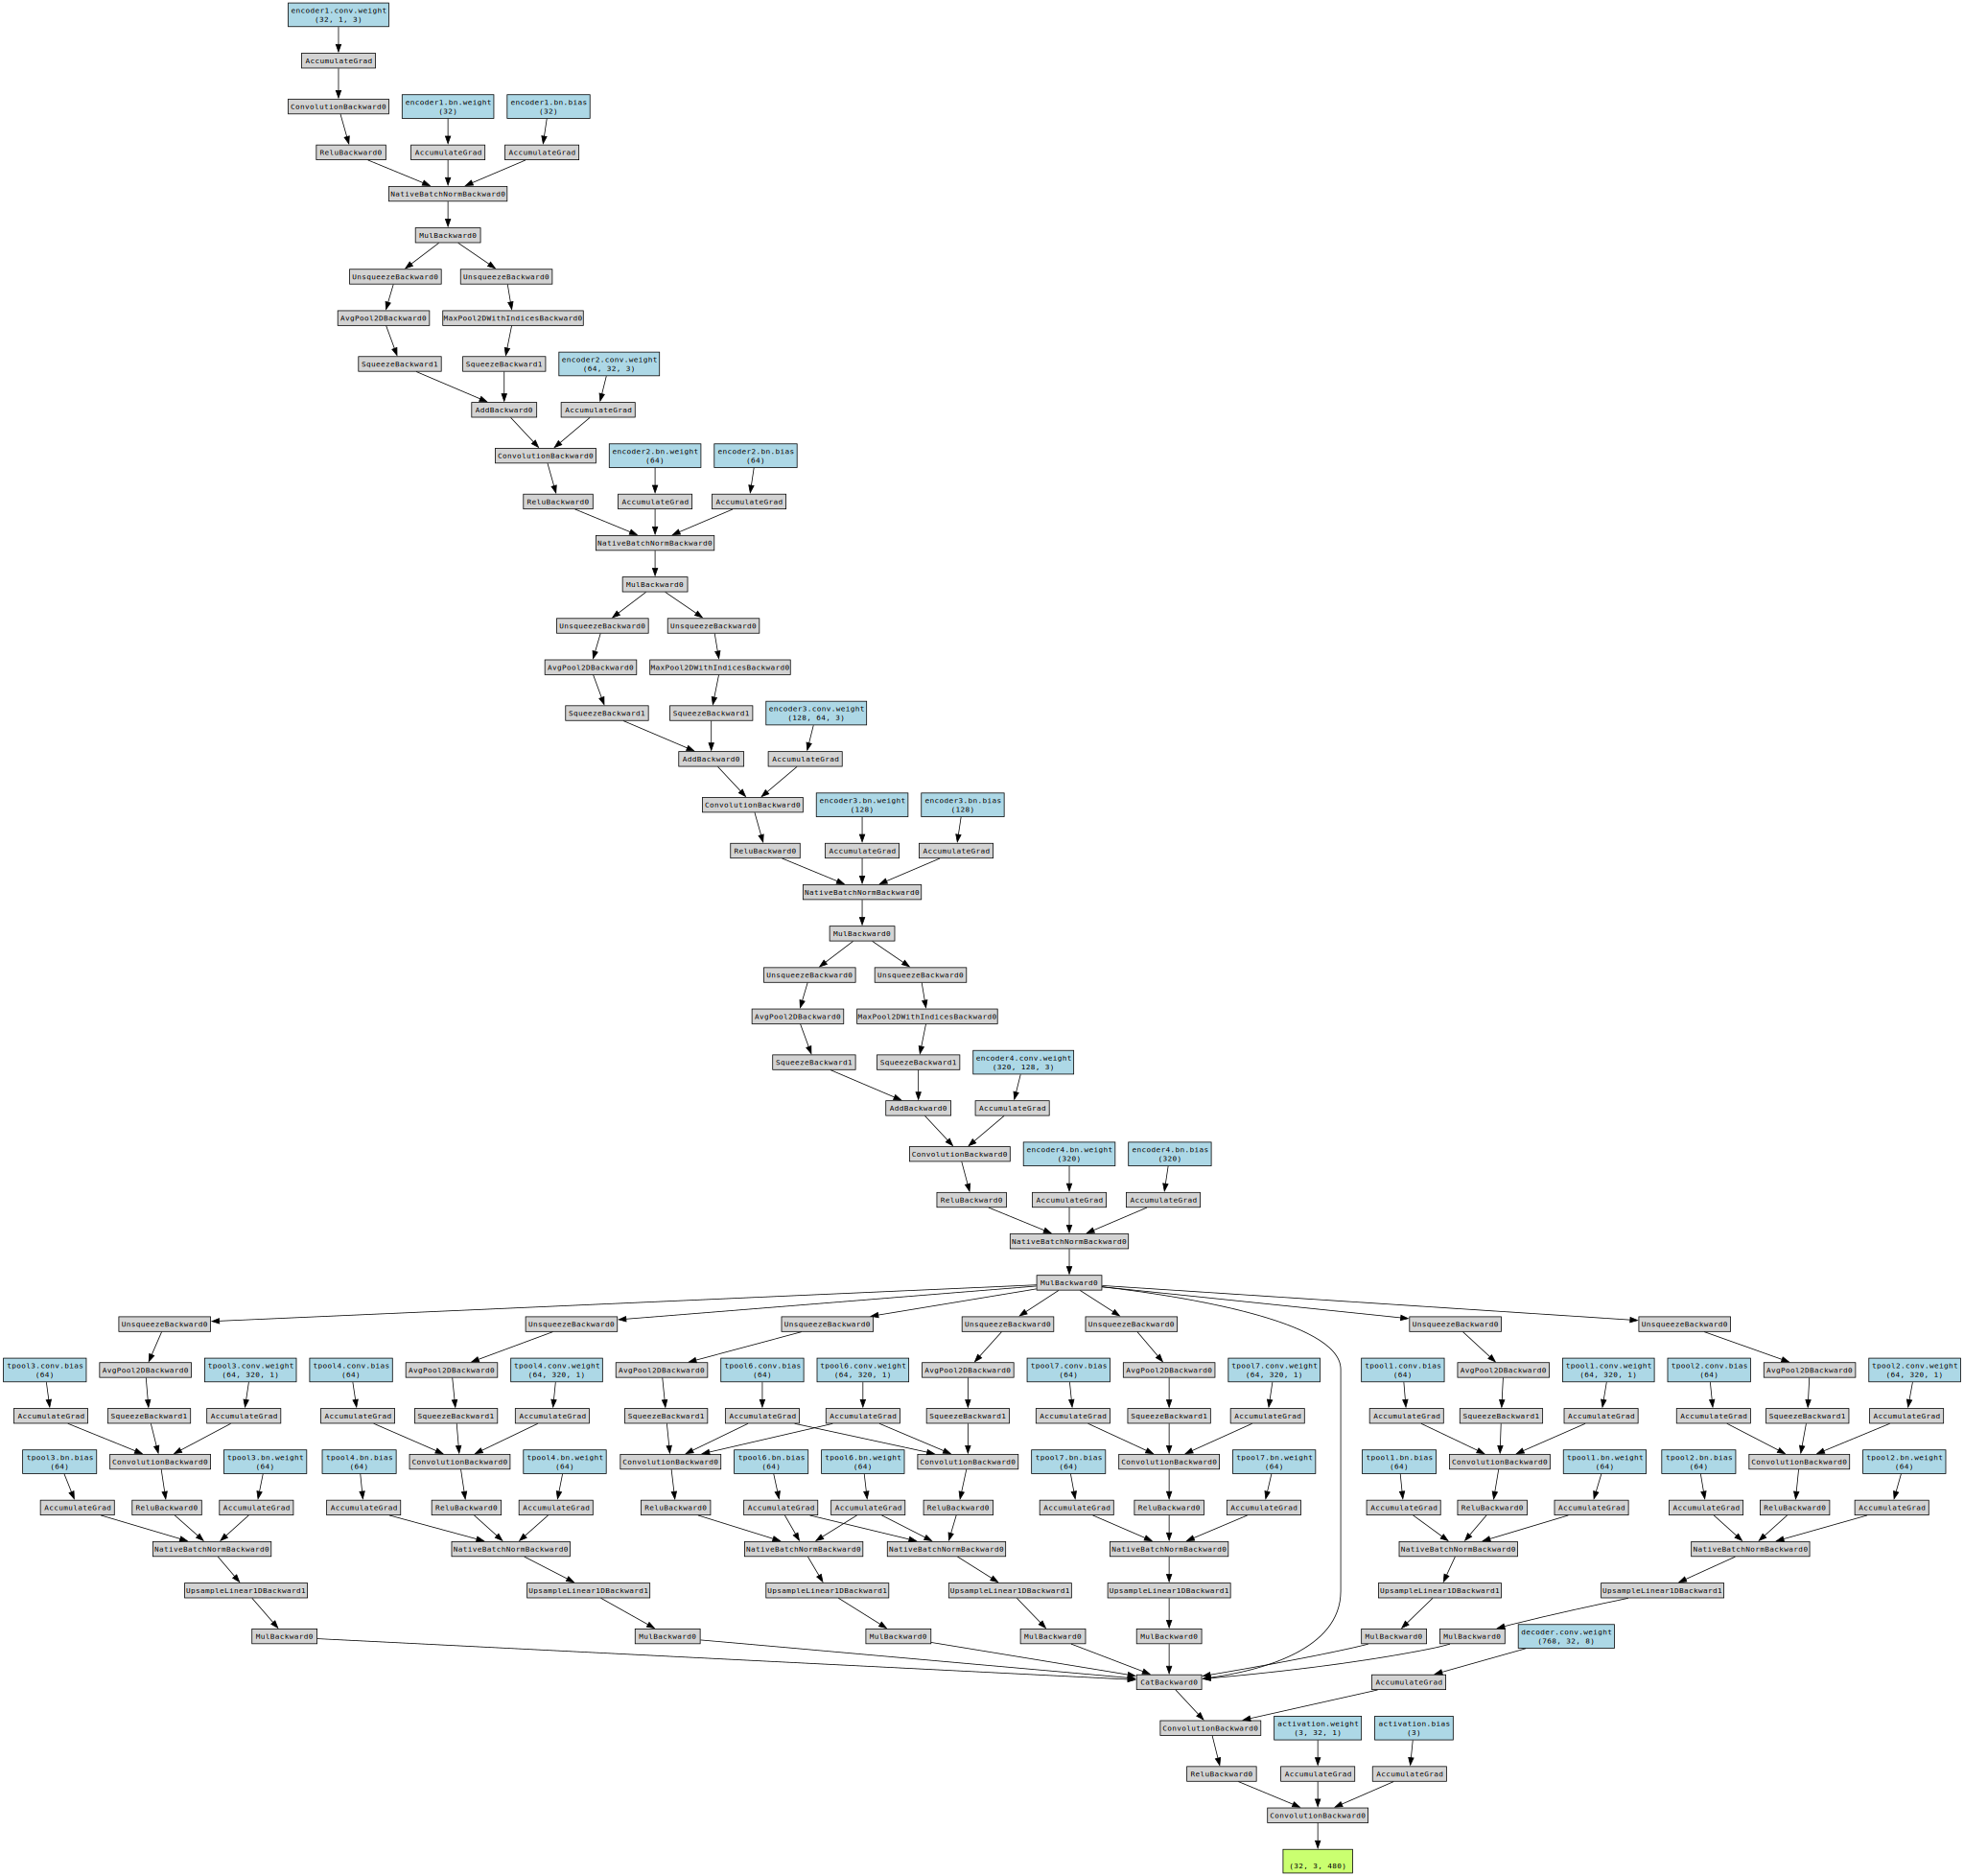

In [9]:
dot

In [19]:
def train_model(model, batch_size, n_epochs, filename):
    
    # 用于跟踪训练过程中的训练损失
    train_losses = []
    # 用于跟踪训练过程中的验证损失
    valid_losses = []
    # 用于跟踪训练过程中的测试损失
    test_losses = []
    # 用于跟踪每个 epoch 的平均训练损失
    avg_train_losses = []
    # 用于跟踪每个 epoch 的平均验证损失
    avg_valid_losses = [] 
    # 用于跟踪每个 epoch 的平均测试损失
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    # 初始化 early_stopping 对象
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # 训练模型 #
        ###################
        model.train() # 准备模型进行训练
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 清除所有优化变量的梯度
            optimizer.zero_grad()
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 反向传播：计算损失相对于模型参数的梯度
            loss.backward()
            # 执行单次优化步骤（参数更新）
            optimizer.step()
            # 记录训练损失
            train_losses.append(loss.item())

        ######################    
        # 验证模型 #
        ######################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录验证损失
            valid_losses.append(loss.item())

        ##################    
        # 测试模型 #
        ##################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录测试损失
            test_losses.append(loss.item())

        # 打印训练/验证统计信息
        # 计算一个 epoch 的平均损失
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # 清空列表以跟踪下一个 epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping 需要验证损失来检查是否有减少，
        # 如果有减少，它将创建当前模型的检查点
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'验证损失减少 ({min_loss:.6f} --> {valid_loss:.6f}). 正在保存模型...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # 加载具有最佳模型的最后一个检查点
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses


In [56]:
def train_model(model, batch_size, n_epochs, filename):
    
    # 用于跟踪训练过程中的训练损失
    train_losses = []
    # 用于跟踪训练过程中的验证损失
    valid_losses = []
    # 用于跟踪训练过程中的测试损失
    test_losses = []
    # 用于跟踪每个 epoch 的平均训练损失
    avg_train_losses = []
    # 用于跟踪每个 epoch 的平均验证损失
    avg_valid_losses = [] 
    # 用于跟踪每个 epoch 的平均测试损失
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    # 初始化 early_stopping 对象
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # 训练模型 #
        ###################
        model.train() # 准备模型进行训练
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 清除所有优化变量的梯度
            optimizer.zero_grad()
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 反向传播：计算损失相对于模型参数的梯度
            loss.backward()
            # 执行单次优化步骤（参数更新）
            optimizer.step()
            # 记录训练损失
            train_losses.append(loss.item())

        ######################    
        # 验证模型 #
        ######################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录验证损失
            valid_losses.append(loss.item())

        ##################    
        # 测试模型 #
        ##################
        model.eval() # 准备模型进行评估
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # 前向传播：通过将输入传递给模型来计算预测输出
            output_status = model(data).permute(0,2,1)
            # 计算损失
            loss = criterion(output_status, target_status)
            # 记录测试损失
            test_losses.append(loss.item())

        # 打印训练/验证统计信息
        # 计算一个 epoch 的平均损失
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # 清空列表以跟踪下一个 epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping 需要验证损失来检查是否有减少，
        # 如果有减少，它将创建当前模型的检查点
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'验证损失减少 ({min_loss:.6f} --> {valid_loss:.6f}). 正在保存模型...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # 加载具有最佳模型的最后一个检查点
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses


这段代码定义了一个训练模型的函数train_model，用于训练神经网络模型。在训练过程中，该函数会迭代多个epoch，每个epoch会对训练集、验证集和测试集进行一次前向传播和反向传播，并计算损失值。在每个epoch结束时，该函数会输出该epoch的平均训练损失、平均验证损失和平均测试损失，并将最好的模型保存下来。该函数的返回值包括训练好的模型和每个epoch的平均损失值。

In [19]:
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            sh = torch.sigmoid(sh[:,a,:])
            
            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

这段代码是一个函数，用于评估模型在给定数据集上的激活结果。

首先，在函数内部定义了四个空列表：x_true、s_true、p_true和s_hat，用于存储计算结果。

接下来，将模型设置为评估模式，即model.eval()。

然后，通过一个循环遍历数据加载器loader中的每个批次。在每个批次中，执行以下操作：

将输入数据x从(batch_size, sequence_length)的形状转换为(batch_size, 1, sequence_length)的形状，并将其移到GPU上（假设有可用的CUDA设备）。
使用permute函数对位置编码p和状态s进行维度转换，将其从(batch_size, num_features, sequence_length)的形状转换为(batch_size, sequence_length)的形状，并选择第a个特征。
将处理后的输入数据x输入到模型中，得到输出sh。使用sigmoid函数对输出进行激活，只选择第a个特征。
将激活结果sh展平并转换为NumPy数组，然后将其添加到s_hat列表中。
对输入数据x、位置编码p和状态s进行类似的处理，将它们展平并转换为NumPy数组，然后分别添加到x_true、s_true和p_true列表中。
在循环结束后，将x_true、s_true、p_true和s_hat列表中的所有元素堆叠起来，得到最终的结果x_true、p_true、s_true和s_hat。

最后，将这四个结果作为函数的返回值。

x_true: 包含了模型输入数据经过处理后的真实值。在该代码中，x_true 是一个一维数组，保存了经过处理后的输入数据 x 的值。

p_true: 包含了模型在数据加载器上对应位置的真实标签。在该代码中，p_true 是一个一维数组，保存了真实的标签值 p。

s_true: 包含了模型在数据加载器上对应位置的真实输出值。在该代码中，s_true 是一个一维数组，保存了真实的输出值 s。

s_hat: 包含了模型在数据加载器上对应位置的预测输出值。在该代码中，s_hat 是一个一维数组，保存了模型对应位置的预测输出值。

In [15]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*2   #输出时间序列长度1440
BORDER = 16   #边界宽度
#输入为SEQ_LEN+BORDER*2-2=1470
BATCH_SIZE = 32

MAX_POWER = 2000.

In [16]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('./UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    print(ds)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

                            aggregate  kettle     fridge  washing_machine  \
datetime                                                                    
2013-04-12 00:00:00+00:00  166.416672     0.0   0.000000              0.0   
2013-04-12 00:01:00+00:00  166.816666     0.0   0.000000              0.0   
2013-04-12 00:02:00+00:00  168.083328     0.0   0.000000              0.0   
2013-04-12 00:03:00+00:00  167.199997     0.0   0.000000              0.0   
2013-04-12 00:04:00+00:00  167.383331     0.0   0.000000              0.0   
...                               ...     ...        ...              ...   
2014-12-14 23:56:00+00:00  210.449997     0.0  78.066666              0.0   
2014-12-14 23:57:00+00:00  208.533340     0.0  79.699997              0.0   
2014-12-14 23:58:00+00:00  209.333328     0.0  76.900002              0.0   
2014-12-14 23:59:00+00:00  186.516663     0.0  50.049999              0.0   
2014-12-15 00:00:00+00:00  165.399994     0.0   0.000000              0.0   

这段代码首先定义了一些常量，包括家电的名称、阈值、最小开启时间和最小关闭时间，以及一些数据处理相关的参数。然后，通过循环读取5个训练数据集，并将其存储在ds_meter、ds_appliance和ds_status列表中。其中，ds_meter存储了总用电量数据，ds_appliance存储了各个家电的用电量数据，ds_status存储了家电的状态数据。

In [21]:
ds_meter[0]

datetime
2013-04-12 00:00:00+00:00    166.416672
2013-04-12 00:01:00+00:00    166.816666
2013-04-12 00:02:00+00:00    168.083328
2013-04-12 00:03:00+00:00    167.199997
2013-04-12 00:04:00+00:00    167.383331
                                ...    
2014-12-14 23:56:00+00:00    210.449997
2014-12-14 23:57:00+00:00    208.533340
2014-12-14 23:58:00+00:00    209.333328
2014-12-14 23:59:00+00:00    186.516663
2014-12-15 00:00:00+00:00    165.399994
Name: aggregate, Length: 881281, dtype: float32

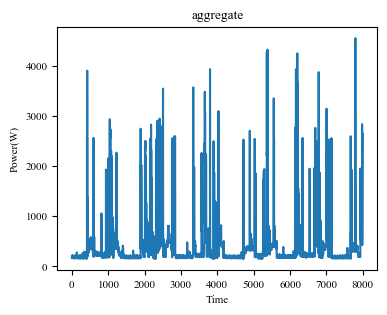

In [50]:
data = [
    (i, value) for i, value in enumerate(ds_meter[0][:8000])
]

# 提取序列号和值
indices = [d[0] for d in data]
values = [d[1] for d in data]

# 设置字体和大小
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用于正确显示中文标签
matplotlib.rcParams['font.size'] = 8  # 设置字体大小为8磅
matplotlib.rcParams['axes.unicode_minus'] = False  # 用于正确显示负号
matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置英文字体为Times New Roman
# 设置图表尺寸，以适应半栏A4宽度
plt.figure(figsize=(4.13, 3.15))  # A4纸张半栏宽度约为4.13英寸

# 创建折线图
plt.plot(indices, values)



# 添加标题和标签
plt.title('aggregate')
plt.xlabel('Time')
plt.ylabel('Power(W)')

# 显示图形
#plt.show()

# 设置分辨率为600ppi
dpi = 600

# 设置图表尺寸，以英寸为单位
#fig = plt.figure(figsize=(8, 6))  # 这里将宽度设置为8英寸，高度设置为6英寸，你可以根据需要进行调整

# 选择文件路径和文件名，保存为PNG格式
save_path = r'D:\NILM\小论文\SKNILM\绘图\状态图\image.png'


# 导出图片
plt.savefig(save_path, dpi=dpi)

plt.show()

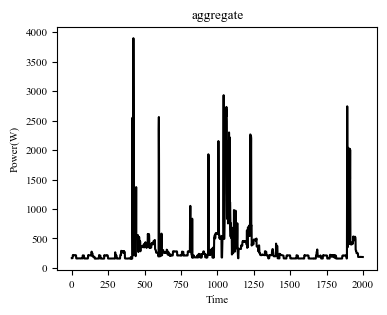

In [30]:
import matplotlib.pyplot as plt
import matplotlib

# 设置字体和大小
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用于正确显示中文标签
matplotlib.rcParams['font.size'] = 8  # 设置字体大小为8磅
matplotlib.rcParams['axes.unicode_minus'] = False  # 用于正确显示负号
matplotlib.rcParams['font.family'] = 'Times New Roman'  # 设置英文字体为Times New Roman

# 设置图表尺寸，以适应半栏A4宽度
plt.figure(figsize=(4.13, 3.15))  # A4纸张半栏宽度约为4.13英寸

# 假设 ds_meter[0][:2000] 是您的数据源
data = [(i, value) for i, value in enumerate(ds_meter[0][:2000])]

# 提取序列号和值
indices = [d[0] for d in data]
values = [d[1] for d in data]

# 创建黑白折线图，将颜色设置为黑色
plt.plot(indices, values, color='black')

# 添加标题和标签
plt.title('aggregate')
plt.xlabel('Time')
plt.ylabel('Power(W)')

# 设置分辨率为600ppi
dpi = 600

# 选择文件路径和文件名，保存为PNG格式
save_path = r'D:\NILM\小论文\中文小论文\投稿\灰度图\image.png'

# 导出图片，设置为灰度格式
plt.savefig(save_path, dpi=dpi, format='png', cmap='gray')

# 显示图形
plt.show()


接下来，代码统计了ds_status[1]中状态变化为1的次数，并对ds_status[1]进行了描述性统计。

In [17]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

这段代码定义了多个数据集和数据加载器，用于训练和测试神经网络模型。首先，代码根据数据集的长度将数据集分为训练集、验证集和测试集，并将每个家庭的数据存储在不同的数据集中。然后，代码使用`ConcatDataset`将不同家庭的数据集合并成一个数据集，并将其传递给`DataLoader`进行批量加载。其中，`dl_train_seen`和`dl_valid_seen`是已知家电的训练集和验证集数据加载器，`dl_test_seen`是已知家电的测试集数据加载器，`dl_train_unseen`和`dl_valid_unseen`是未知家电的训练集和验证集数据加载器，`dl_test_unseen`是未知家电的测试集数据加载器。

最后，代码定义了多个用于单独加载每个家庭数据的数据加载器`dl_house_test`、`dl_house_valid`和`dl_house_total`。

In [57]:
batch_size = BATCH_SIZE
n_epochs = 500

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen

#i = 0
for i in range(20):
#for i in range(1):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    #model = LSTMModel(input_size, hidden_size, output_size).cuda()
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_seen_01_01%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/500] train_loss: 0.32598 valid_loss: 0.22979 test_loss: 0.23192 
验证损失减少 (inf --> 0.229790). 正在保存模型...
[  2/500] train_loss: 0.17772 valid_loss: 0.17494 test_loss: 0.17699 
验证损失减少 (0.229790 --> 0.174944). 正在保存模型...
[  3/500] train_loss: 0.14843 valid_loss: 0.15311 test_loss: 0.15612 
验证损失减少 (0.174944 --> 0.153107). 正在保存模型...
[  4/500] train_loss: 0.13414 valid_loss: 0.13490 test_loss: 0.14057 
验证损失减少 (0.153107 --> 0.134903). 正在保存模型...
[  5/500] train_loss: 0.12663 valid_loss: 0.12641 test_loss: 0.13319 
验证损失减少 (0.134903 --> 0.126412). 正在保存模型...
[  6/500] train_loss: 0.11950 valid_loss: 0.12356 test_loss: 0.13088 
验证损失减少 (0.126412 --> 0.123557). 正在保存模型...
[  7/500] train_loss: 0.11629 valid_loss: 0.12083 test_loss: 0.12677 
验证损失减少 (0.123557 --> 0.120835). 正在保存模型...
[  8/500] train_loss: 0.11430 valid_loss: 0.11659 test_loss: 0.12419 
验证损失减少 (0.120835 --> 0.116589). 正在保存模型...
[  9/500] train_loss: 0.11037 valid_loss: 0.11376 test_loss: 0.12155 
验证损失减少 (0.116589 --> 0

[ 93/500] train_loss: 0.06840 valid_loss: 0.07623 test_loss: 0.08362 
[ 94/500] train_loss: 0.06703 valid_loss: 0.07561 test_loss: 0.08320 
[ 95/500] train_loss: 0.06617 valid_loss: 0.07824 test_loss: 0.08444 
[ 96/500] train_loss: 0.06481 valid_loss: 0.07787 test_loss: 0.08443 
[ 97/500] train_loss: 0.06540 valid_loss: 0.07629 test_loss: 0.08237 
[ 98/500] train_loss: 0.06830 valid_loss: 0.07695 test_loss: 0.08205 
[ 99/500] train_loss: 0.06736 valid_loss: 0.07583 test_loss: 0.08176 
[100/500] train_loss: 0.06677 valid_loss: 0.07982 test_loss: 0.08602 
[101/500] train_loss: 0.06430 valid_loss: 0.07760 test_loss: 0.08295 
[102/500] train_loss: 0.06642 valid_loss: 0.07691 test_loss: 0.08282 
[103/500] train_loss: 0.06529 valid_loss: 0.07516 test_loss: 0.08206 
验证损失减少 (0.075594 --> 0.075162). 正在保存模型...
[104/500] train_loss: 0.06550 valid_loss: 0.07723 test_loss: 0.08295 
[105/500] train_loss: 0.06464 valid_loss: 0.07645 test_loss: 0.08314 
[106/500] train_loss: 0.06653 valid_loss: 0.0765

[205/500] train_loss: 0.05510 valid_loss: 0.07188 test_loss: 0.07984 
[206/500] train_loss: 0.05606 valid_loss: 0.07248 test_loss: 0.08002 
[207/500] train_loss: 0.05629 valid_loss: 0.07121 test_loss: 0.07978 
[208/500] train_loss: 0.05489 valid_loss: 0.07207 test_loss: 0.08008 
[209/500] train_loss: 0.05561 valid_loss: 0.07414 test_loss: 0.07982 
[210/500] train_loss: 0.05464 valid_loss: 0.07053 test_loss: 0.07857 
验证损失减少 (0.070830 --> 0.070531). 正在保存模型...
[211/500] train_loss: 0.05378 valid_loss: 0.07181 test_loss: 0.07990 
[212/500] train_loss: 0.05410 valid_loss: 0.07203 test_loss: 0.07931 
[213/500] train_loss: 0.05351 valid_loss: 0.07148 test_loss: 0.07886 
[214/500] train_loss: 0.05471 valid_loss: 0.07159 test_loss: 0.07915 
[215/500] train_loss: 0.05294 valid_loss: 0.07058 test_loss: 0.07934 
[216/500] train_loss: 0.05264 valid_loss: 0.07240 test_loss: 0.07864 
[217/500] train_loss: 0.05613 valid_loss: 0.07203 test_loss: 0.07915 
[218/500] train_loss: 0.05338 valid_loss: 0.0737

[321/500] train_loss: 0.04779 valid_loss: 0.07232 test_loss: 0.08176 
[322/500] train_loss: 0.04774 valid_loss: 0.07262 test_loss: 0.08113 
[323/500] train_loss: 0.04765 valid_loss: 0.07257 test_loss: 0.08127 
[324/500] train_loss: 0.04729 valid_loss: 0.07239 test_loss: 0.08037 
[325/500] train_loss: 0.04742 valid_loss: 0.07133 test_loss: 0.08068 
[326/500] train_loss: 0.04728 valid_loss: 0.07019 test_loss: 0.07992 
[327/500] train_loss: 0.04723 valid_loss: 0.07206 test_loss: 0.08068 
[328/500] train_loss: 0.04830 valid_loss: 0.07230 test_loss: 0.08065 
[329/500] train_loss: 0.04849 valid_loss: 0.07088 test_loss: 0.08111 
[330/500] train_loss: 0.04647 valid_loss: 0.07199 test_loss: 0.08251 
[331/500] train_loss: 0.04787 valid_loss: 0.07152 test_loss: 0.08210 
[332/500] train_loss: 0.04779 valid_loss: 0.07284 test_loss: 0.08273 
[333/500] train_loss: 0.04728 valid_loss: 0.07296 test_loss: 0.08151 
[334/500] train_loss: 0.04646 valid_loss: 0.07337 test_loss: 0.08100 
[335/500] train_loss

[439/500] train_loss: 0.04382 valid_loss: 0.07398 test_loss: 0.08168 
[440/500] train_loss: 0.04331 valid_loss: 0.07411 test_loss: 0.07989 
[441/500] train_loss: 0.04291 valid_loss: 0.07417 test_loss: 0.08047 
[442/500] train_loss: 0.04373 valid_loss: 0.07312 test_loss: 0.08086 
[443/500] train_loss: 0.04487 valid_loss: 0.07262 test_loss: 0.08119 
[444/500] train_loss: 0.04294 valid_loss: 0.07442 test_loss: 0.08073 
[445/500] train_loss: 0.04250 valid_loss: 0.07423 test_loss: 0.08115 
[446/500] train_loss: 0.04381 valid_loss: 0.07474 test_loss: 0.08264 
[447/500] train_loss: 0.04288 valid_loss: 0.07291 test_loss: 0.08060 
[448/500] train_loss: 0.04336 valid_loss: 0.07364 test_loss: 0.08200 
[449/500] train_loss: 0.04268 valid_loss: 0.07485 test_loss: 0.08093 
[450/500] train_loss: 0.04377 valid_loss: 0.07404 test_loss: 0.08159 
[451/500] train_loss: 0.04297 valid_loss: 0.07595 test_loss: 0.08372 
[452/500] train_loss: 0.04330 valid_loss: 0.07302 test_loss: 0.08014 
[453/500] train_loss

[ 41/500] train_loss: 0.08289 valid_loss: 0.08518 test_loss: 0.09447 
验证损失减少 (0.085977 --> 0.085176). 正在保存模型...
[ 42/500] train_loss: 0.07921 valid_loss: 0.08628 test_loss: 0.09418 
[ 43/500] train_loss: 0.07959 valid_loss: 0.08594 test_loss: 0.09406 
[ 44/500] train_loss: 0.08098 valid_loss: 0.08397 test_loss: 0.09206 
验证损失减少 (0.085176 --> 0.083965). 正在保存模型...
[ 45/500] train_loss: 0.08084 valid_loss: 0.08455 test_loss: 0.09271 
[ 46/500] train_loss: 0.07846 valid_loss: 0.08349 test_loss: 0.09167 
验证损失减少 (0.083965 --> 0.083491). 正在保存模型...
[ 47/500] train_loss: 0.07968 valid_loss: 0.08467 test_loss: 0.09234 
[ 48/500] train_loss: 0.08030 valid_loss: 0.08378 test_loss: 0.09062 
[ 49/500] train_loss: 0.07998 valid_loss: 0.08416 test_loss: 0.09082 
[ 50/500] train_loss: 0.07886 valid_loss: 0.08414 test_loss: 0.09202 
[ 51/500] train_loss: 0.07885 valid_loss: 0.08253 test_loss: 0.09103 
验证损失减少 (0.083491 --> 0.082527). 正在保存模型...
[ 52/500] train_loss: 0.07909 valid_loss: 0.08363 test_loss: 0

[147/500] train_loss: 0.06032 valid_loss: 0.07488 test_loss: 0.08168 
[148/500] train_loss: 0.06033 valid_loss: 0.07485 test_loss: 0.08155 
[149/500] train_loss: 0.06093 valid_loss: 0.07609 test_loss: 0.08258 
[150/500] train_loss: 0.05797 valid_loss: 0.07586 test_loss: 0.08135 
[151/500] train_loss: 0.05974 valid_loss: 0.07578 test_loss: 0.08167 
[152/500] train_loss: 0.06050 valid_loss: 0.07843 test_loss: 0.08156 
[153/500] train_loss: 0.05953 valid_loss: 0.07492 test_loss: 0.08151 
[154/500] train_loss: 0.05932 valid_loss: 0.07542 test_loss: 0.08186 
[155/500] train_loss: 0.06017 valid_loss: 0.07516 test_loss: 0.08302 
[156/500] train_loss: 0.05945 valid_loss: 0.07594 test_loss: 0.08104 
[157/500] train_loss: 0.05936 valid_loss: 0.07523 test_loss: 0.08238 
[158/500] train_loss: 0.05921 valid_loss: 0.07591 test_loss: 0.08235 
[159/500] train_loss: 0.05857 valid_loss: 0.07510 test_loss: 0.08141 
[160/500] train_loss: 0.05761 valid_loss: 0.07376 test_loss: 0.08022 
[161/500] train_loss

[262/500] train_loss: 0.05136 valid_loss: 0.07425 test_loss: 0.08118 
[263/500] train_loss: 0.05041 valid_loss: 0.07427 test_loss: 0.08036 
[264/500] train_loss: 0.05198 valid_loss: 0.07407 test_loss: 0.08016 
[265/500] train_loss: 0.05097 valid_loss: 0.07449 test_loss: 0.08127 
[266/500] train_loss: 0.04998 valid_loss: 0.07352 test_loss: 0.08092 
[267/500] train_loss: 0.04961 valid_loss: 0.07478 test_loss: 0.08234 
[268/500] train_loss: 0.04993 valid_loss: 0.07528 test_loss: 0.08129 
[269/500] train_loss: 0.04997 valid_loss: 0.07372 test_loss: 0.08131 
[270/500] train_loss: 0.04938 valid_loss: 0.07616 test_loss: 0.08183 
[271/500] train_loss: 0.05163 valid_loss: 0.07491 test_loss: 0.08200 
[272/500] train_loss: 0.05194 valid_loss: 0.07303 test_loss: 0.08003 
[273/500] train_loss: 0.04947 valid_loss: 0.07266 test_loss: 0.08158 
[274/500] train_loss: 0.05080 valid_loss: 0.07388 test_loss: 0.08188 
[275/500] train_loss: 0.05049 valid_loss: 0.07588 test_loss: 0.08315 
[276/500] train_loss

[380/500] train_loss: 0.04553 valid_loss: 0.07318 test_loss: 0.08234 
[381/500] train_loss: 0.04486 valid_loss: 0.07324 test_loss: 0.08176 
[382/500] train_loss: 0.04426 valid_loss: 0.07469 test_loss: 0.08150 
[383/500] train_loss: 0.04447 valid_loss: 0.07515 test_loss: 0.08269 
[384/500] train_loss: 0.04437 valid_loss: 0.07481 test_loss: 0.08175 
[385/500] train_loss: 0.04565 valid_loss: 0.07443 test_loss: 0.08248 
[386/500] train_loss: 0.04546 valid_loss: 0.07360 test_loss: 0.08419 
[387/500] train_loss: 0.04491 valid_loss: 0.07412 test_loss: 0.08391 
[388/500] train_loss: 0.04480 valid_loss: 0.07558 test_loss: 0.08402 
[389/500] train_loss: 0.04392 valid_loss: 0.07956 test_loss: 0.08251 
[390/500] train_loss: 0.04453 valid_loss: 0.07456 test_loss: 0.08377 
[391/500] train_loss: 0.04462 valid_loss: 0.07534 test_loss: 0.08390 
[392/500] train_loss: 0.04365 valid_loss: 0.07550 test_loss: 0.08361 
[393/500] train_loss: 0.04565 valid_loss: 0.07428 test_loss: 0.08214 
[394/500] train_loss

[498/500] train_loss: 0.04164 valid_loss: 0.07619 test_loss: 0.08157 
[499/500] train_loss: 0.04181 valid_loss: 0.07602 test_loss: 0.08207 
[500/500] train_loss: 0.04178 valid_loss: 0.07632 test_loss: 0.08139 
TRAINING MODEL 2
[  1/500] train_loss: 0.35372 valid_loss: 0.25025 test_loss: 0.25564 
验证损失减少 (inf --> 0.250249). 正在保存模型...
[  2/500] train_loss: 0.18991 valid_loss: 0.17937 test_loss: 0.18445 
验证损失减少 (0.250249 --> 0.179373). 正在保存模型...
[  3/500] train_loss: 0.15233 valid_loss: 0.15891 test_loss: 0.16964 
验证损失减少 (0.179373 --> 0.158914). 正在保存模型...
[  4/500] train_loss: 0.13802 valid_loss: 0.13874 test_loss: 0.14461 
验证损失减少 (0.158914 --> 0.138741). 正在保存模型...
[  5/500] train_loss: 0.12907 valid_loss: 0.13111 test_loss: 0.13966 
验证损失减少 (0.138741 --> 0.131113). 正在保存模型...
[  6/500] train_loss: 0.12381 valid_loss: 0.12599 test_loss: 0.13356 
验证损失减少 (0.131113 --> 0.125989). 正在保存模型...
[  7/500] train_loss: 0.11829 valid_loss: 0.12085 test_loss: 0.12776 
验证损失减少 (0.125989 --> 0.120849). 正在保存

[ 92/500] train_loss: 0.06987 valid_loss: 0.08112 test_loss: 0.08451 
[ 93/500] train_loss: 0.06772 valid_loss: 0.07678 test_loss: 0.08638 
[ 94/500] train_loss: 0.06849 valid_loss: 0.07751 test_loss: 0.08381 
[ 95/500] train_loss: 0.06701 valid_loss: 0.07832 test_loss: 0.08477 
[ 96/500] train_loss: 0.06645 valid_loss: 0.07808 test_loss: 0.08503 
[ 97/500] train_loss: 0.06754 valid_loss: 0.07634 test_loss: 0.08183 
验证损失减少 (0.076415 --> 0.076342). 正在保存模型...
[ 98/500] train_loss: 0.06607 valid_loss: 0.07661 test_loss: 0.08375 
[ 99/500] train_loss: 0.06564 valid_loss: 0.07589 test_loss: 0.08428 
验证损失减少 (0.076342 --> 0.075894). 正在保存模型...
[100/500] train_loss: 0.06646 valid_loss: 0.07561 test_loss: 0.08408 
验证损失减少 (0.075894 --> 0.075607). 正在保存模型...
[101/500] train_loss: 0.06681 valid_loss: 0.07683 test_loss: 0.08363 
[102/500] train_loss: 0.06569 valid_loss: 0.07732 test_loss: 0.08263 
[103/500] train_loss: 0.06622 valid_loss: 0.07624 test_loss: 0.08300 
[104/500] train_loss: 0.06605 vali

[204/500] train_loss: 0.05400 valid_loss: 0.07337 test_loss: 0.08073 
[205/500] train_loss: 0.05369 valid_loss: 0.07467 test_loss: 0.07951 
[206/500] train_loss: 0.05377 valid_loss: 0.07499 test_loss: 0.08187 
[207/500] train_loss: 0.05495 valid_loss: 0.07788 test_loss: 0.07969 
[208/500] train_loss: 0.05218 valid_loss: 0.07424 test_loss: 0.08248 
[209/500] train_loss: 0.05430 valid_loss: 0.07556 test_loss: 0.08234 
[210/500] train_loss: 0.05279 valid_loss: 0.07371 test_loss: 0.08076 
[211/500] train_loss: 0.05319 valid_loss: 0.07513 test_loss: 0.08149 
[212/500] train_loss: 0.05228 valid_loss: 0.07702 test_loss: 0.08103 
[213/500] train_loss: 0.05297 valid_loss: 0.07644 test_loss: 0.08226 
[214/500] train_loss: 0.05488 valid_loss: 0.07558 test_loss: 0.08025 
[215/500] train_loss: 0.05290 valid_loss: 0.07435 test_loss: 0.08079 
[216/500] train_loss: 0.05347 valid_loss: 0.07616 test_loss: 0.08045 
[217/500] train_loss: 0.05340 valid_loss: 0.07661 test_loss: 0.08007 
[218/500] train_loss

[321/500] train_loss: 0.04788 valid_loss: 0.07553 test_loss: 0.08080 
[322/500] train_loss: 0.04603 valid_loss: 0.07403 test_loss: 0.08072 
[323/500] train_loss: 0.04695 valid_loss: 0.07549 test_loss: 0.08072 
[324/500] train_loss: 0.04751 valid_loss: 0.07519 test_loss: 0.08116 
[325/500] train_loss: 0.04806 valid_loss: 0.07366 test_loss: 0.08108 
[326/500] train_loss: 0.04728 valid_loss: 0.07359 test_loss: 0.08105 
[327/500] train_loss: 0.04763 valid_loss: 0.07498 test_loss: 0.08225 
[328/500] train_loss: 0.04663 valid_loss: 0.07438 test_loss: 0.08091 
[329/500] train_loss: 0.04620 valid_loss: 0.07550 test_loss: 0.08232 
[330/500] train_loss: 0.04785 valid_loss: 0.07537 test_loss: 0.08096 
[331/500] train_loss: 0.04790 valid_loss: 0.07565 test_loss: 0.08073 
[332/500] train_loss: 0.04674 valid_loss: 0.07426 test_loss: 0.08353 
[333/500] train_loss: 0.04605 valid_loss: 0.07458 test_loss: 0.08119 
[334/500] train_loss: 0.04618 valid_loss: 0.07454 test_loss: 0.08085 
[335/500] train_loss

[439/500] train_loss: 0.04194 valid_loss: 0.07505 test_loss: 0.08296 
[440/500] train_loss: 0.04336 valid_loss: 0.07680 test_loss: 0.08442 
[441/500] train_loss: 0.04298 valid_loss: 0.07590 test_loss: 0.08382 
[442/500] train_loss: 0.04200 valid_loss: 0.07512 test_loss: 0.08273 
[443/500] train_loss: 0.04309 valid_loss: 0.07548 test_loss: 0.08204 
[444/500] train_loss: 0.04230 valid_loss: 0.07564 test_loss: 0.08274 
[445/500] train_loss: 0.04288 valid_loss: 0.07722 test_loss: 0.08400 
[446/500] train_loss: 0.04232 valid_loss: 0.07708 test_loss: 0.08377 
[447/500] train_loss: 0.04157 valid_loss: 0.07651 test_loss: 0.08349 
[448/500] train_loss: 0.04289 valid_loss: 0.07533 test_loss: 0.08308 
[449/500] train_loss: 0.04197 valid_loss: 0.07506 test_loss: 0.08437 
[450/500] train_loss: 0.04174 valid_loss: 0.07654 test_loss: 0.08411 
[451/500] train_loss: 0.04263 valid_loss: 0.07722 test_loss: 0.08562 
[452/500] train_loss: 0.04491 valid_loss: 0.07629 test_loss: 0.08522 
[453/500] train_loss

[ 40/500] train_loss: 0.07941 valid_loss: 0.08708 test_loss: 0.09324 
[ 41/500] train_loss: 0.08061 valid_loss: 0.08975 test_loss: 0.09303 
[ 42/500] train_loss: 0.08069 valid_loss: 0.08896 test_loss: 0.09475 
[ 43/500] train_loss: 0.07902 valid_loss: 0.08651 test_loss: 0.09445 
[ 44/500] train_loss: 0.07938 valid_loss: 0.08776 test_loss: 0.09198 
[ 45/500] train_loss: 0.07907 valid_loss: 0.08477 test_loss: 0.09143 
验证损失减少 (0.085513 --> 0.084773). 正在保存模型...
[ 46/500] train_loss: 0.07996 valid_loss: 0.08364 test_loss: 0.09368 
验证损失减少 (0.084773 --> 0.083642). 正在保存模型...
[ 47/500] train_loss: 0.07921 valid_loss: 0.08408 test_loss: 0.09215 
[ 48/500] train_loss: 0.07807 valid_loss: 0.08213 test_loss: 0.09170 
验证损失减少 (0.083642 --> 0.082131). 正在保存模型...
[ 49/500] train_loss: 0.07698 valid_loss: 0.08283 test_loss: 0.09055 
[ 50/500] train_loss: 0.07764 valid_loss: 0.08195 test_loss: 0.09093 
验证损失减少 (0.082131 --> 0.081952). 正在保存模型...
[ 51/500] train_loss: 0.07748 valid_loss: 0.08473 test_loss: 0

[145/500] train_loss: 0.05934 valid_loss: 0.07608 test_loss: 0.08181 
[146/500] train_loss: 0.05929 valid_loss: 0.07346 test_loss: 0.08157 
验证损失减少 (0.073580 --> 0.073461). 正在保存模型...
[147/500] train_loss: 0.05872 valid_loss: 0.07300 test_loss: 0.08293 
验证损失减少 (0.073461 --> 0.072998). 正在保存模型...
[148/500] train_loss: 0.05828 valid_loss: 0.07587 test_loss: 0.08479 
[149/500] train_loss: 0.05940 valid_loss: 0.07733 test_loss: 0.08259 
[150/500] train_loss: 0.05853 valid_loss: 0.07458 test_loss: 0.08188 
[151/500] train_loss: 0.05913 valid_loss: 0.07542 test_loss: 0.08483 
[152/500] train_loss: 0.06043 valid_loss: 0.07370 test_loss: 0.08237 
[153/500] train_loss: 0.05714 valid_loss: 0.07477 test_loss: 0.08172 
[154/500] train_loss: 0.05816 valid_loss: 0.07476 test_loss: 0.08278 
[155/500] train_loss: 0.05762 valid_loss: 0.07433 test_loss: 0.08142 
[156/500] train_loss: 0.05906 valid_loss: 0.07402 test_loss: 0.08106 
[157/500] train_loss: 0.05801 valid_loss: 0.07367 test_loss: 0.08122 
[158/5

[260/500] train_loss: 0.04998 valid_loss: 0.07200 test_loss: 0.08104 
[261/500] train_loss: 0.05029 valid_loss: 0.07155 test_loss: 0.08126 
[262/500] train_loss: 0.05074 valid_loss: 0.07614 test_loss: 0.08344 
[263/500] train_loss: 0.05071 valid_loss: 0.07409 test_loss: 0.08080 
[264/500] train_loss: 0.05142 valid_loss: 0.07179 test_loss: 0.08123 
[265/500] train_loss: 0.04937 valid_loss: 0.07306 test_loss: 0.08188 
[266/500] train_loss: 0.05023 valid_loss: 0.07137 test_loss: 0.08178 
[267/500] train_loss: 0.05002 valid_loss: 0.07198 test_loss: 0.08188 
[268/500] train_loss: 0.04871 valid_loss: 0.07292 test_loss: 0.08067 
[269/500] train_loss: 0.04976 valid_loss: 0.07134 test_loss: 0.07970 
[270/500] train_loss: 0.04992 valid_loss: 0.07246 test_loss: 0.08323 
[271/500] train_loss: 0.04895 valid_loss: 0.07114 test_loss: 0.08371 
验证损失减少 (0.071253 --> 0.071142). 正在保存模型...
[272/500] train_loss: 0.04932 valid_loss: 0.07105 test_loss: 0.08099 
验证损失减少 (0.071142 --> 0.071047). 正在保存模型...
[273/5

[376/500] train_loss: 0.04477 valid_loss: 0.07441 test_loss: 0.08355 
[377/500] train_loss: 0.04545 valid_loss: 0.07450 test_loss: 0.08149 
[378/500] train_loss: 0.04429 valid_loss: 0.07240 test_loss: 0.08241 
[379/500] train_loss: 0.04427 valid_loss: 0.07276 test_loss: 0.08382 
[380/500] train_loss: 0.04371 valid_loss: 0.07741 test_loss: 0.08319 
[381/500] train_loss: 0.04463 valid_loss: 0.07289 test_loss: 0.08322 
[382/500] train_loss: 0.04339 valid_loss: 0.07476 test_loss: 0.08330 
[383/500] train_loss: 0.04439 valid_loss: 0.07437 test_loss: 0.08455 
[384/500] train_loss: 0.04545 valid_loss: 0.07283 test_loss: 0.08272 
[385/500] train_loss: 0.04450 valid_loss: 0.07279 test_loss: 0.08352 
[386/500] train_loss: 0.04411 valid_loss: 0.07377 test_loss: 0.08319 
[387/500] train_loss: 0.04483 valid_loss: 0.07409 test_loss: 0.08390 
[388/500] train_loss: 0.04425 valid_loss: 0.07376 test_loss: 0.08369 
[389/500] train_loss: 0.04397 valid_loss: 0.07410 test_loss: 0.08432 
[390/500] train_loss

[494/500] train_loss: 0.04015 valid_loss: 0.07546 test_loss: 0.08469 
[495/500] train_loss: 0.04044 valid_loss: 0.07460 test_loss: 0.08428 
[496/500] train_loss: 0.04008 valid_loss: 0.07740 test_loss: 0.08466 
[497/500] train_loss: 0.04056 valid_loss: 0.07481 test_loss: 0.08537 
[498/500] train_loss: 0.04100 valid_loss: 0.07251 test_loss: 0.08423 
[499/500] train_loss: 0.04081 valid_loss: 0.07394 test_loss: 0.08480 
[500/500] train_loss: 0.04107 valid_loss: 0.07302 test_loss: 0.08608 
TRAINING MODEL 4
[  1/500] train_loss: 0.32799 valid_loss: 0.24929 test_loss: 0.25806 
验证损失减少 (inf --> 0.249285). 正在保存模型...
[  2/500] train_loss: 0.19054 valid_loss: 0.17724 test_loss: 0.18638 
验证损失减少 (0.249285 --> 0.177244). 正在保存模型...
[  3/500] train_loss: 0.15257 valid_loss: 0.14785 test_loss: 0.15743 
验证损失减少 (0.177244 --> 0.147846). 正在保存模型...
[  4/500] train_loss: 0.14018 valid_loss: 0.13579 test_loss: 0.14478 
验证损失减少 (0.147846 --> 0.135792). 正在保存模型...
[  5/500] train_loss: 0.12803 valid_loss: 0.12884 

[ 86/500] train_loss: 0.06872 valid_loss: 0.07902 test_loss: 0.08706 
[ 87/500] train_loss: 0.06881 valid_loss: 0.07650 test_loss: 0.08489 
验证损失减少 (0.076855 --> 0.076499). 正在保存模型...
[ 88/500] train_loss: 0.06835 valid_loss: 0.07656 test_loss: 0.08594 
[ 89/500] train_loss: 0.06877 valid_loss: 0.07625 test_loss: 0.08502 
验证损失减少 (0.076499 --> 0.076253). 正在保存模型...
[ 90/500] train_loss: 0.06674 valid_loss: 0.07614 test_loss: 0.08482 
验证损失减少 (0.076253 --> 0.076145). 正在保存模型...
[ 91/500] train_loss: 0.06993 valid_loss: 0.07665 test_loss: 0.08422 
[ 92/500] train_loss: 0.06734 valid_loss: 0.07723 test_loss: 0.08435 
[ 93/500] train_loss: 0.06747 valid_loss: 0.07563 test_loss: 0.08453 
验证损失减少 (0.076145 --> 0.075634). 正在保存模型...
[ 94/500] train_loss: 0.06797 valid_loss: 0.07720 test_loss: 0.08502 
[ 95/500] train_loss: 0.06855 valid_loss: 0.07605 test_loss: 0.08601 
[ 96/500] train_loss: 0.06790 valid_loss: 0.07602 test_loss: 0.08495 
[ 97/500] train_loss: 0.06501 valid_loss: 0.07562 test_loss: 0

[192/500] train_loss: 0.05548 valid_loss: 0.07273 test_loss: 0.07853 
[193/500] train_loss: 0.05556 valid_loss: 0.07287 test_loss: 0.08000 
[194/500] train_loss: 0.05620 valid_loss: 0.07271 test_loss: 0.07844 
[195/500] train_loss: 0.05420 valid_loss: 0.07312 test_loss: 0.07931 
[196/500] train_loss: 0.05393 valid_loss: 0.07299 test_loss: 0.08056 
[197/500] train_loss: 0.05668 valid_loss: 0.07274 test_loss: 0.07916 
[198/500] train_loss: 0.05500 valid_loss: 0.07198 test_loss: 0.07853 
[199/500] train_loss: 0.05578 valid_loss: 0.07318 test_loss: 0.08153 
[200/500] train_loss: 0.05539 valid_loss: 0.07339 test_loss: 0.07754 
[201/500] train_loss: 0.05495 valid_loss: 0.07388 test_loss: 0.08090 
[202/500] train_loss: 0.05595 valid_loss: 0.07458 test_loss: 0.07908 
[203/500] train_loss: 0.05419 valid_loss: 0.07354 test_loss: 0.08011 
[204/500] train_loss: 0.05410 valid_loss: 0.07492 test_loss: 0.07865 
[205/500] train_loss: 0.05518 valid_loss: 0.07316 test_loss: 0.07905 
[206/500] train_loss

[308/500] train_loss: 0.04779 valid_loss: 0.07267 test_loss: 0.07872 
[309/500] train_loss: 0.04788 valid_loss: 0.07508 test_loss: 0.08003 
[310/500] train_loss: 0.04810 valid_loss: 0.07353 test_loss: 0.07978 
[311/500] train_loss: 0.04800 valid_loss: 0.07221 test_loss: 0.07843 
[312/500] train_loss: 0.04742 valid_loss: 0.07458 test_loss: 0.07963 
[313/500] train_loss: 0.04827 valid_loss: 0.07442 test_loss: 0.08124 
[314/500] train_loss: 0.04785 valid_loss: 0.07718 test_loss: 0.07957 
[315/500] train_loss: 0.04894 valid_loss: 0.07668 test_loss: 0.07944 
[316/500] train_loss: 0.04897 valid_loss: 0.07171 test_loss: 0.07760 
[317/500] train_loss: 0.04770 valid_loss: 0.07383 test_loss: 0.08011 
[318/500] train_loss: 0.04858 valid_loss: 0.07343 test_loss: 0.07966 
[319/500] train_loss: 0.04772 valid_loss: 0.07325 test_loss: 0.07928 
[320/500] train_loss: 0.04875 valid_loss: 0.07278 test_loss: 0.08017 
[321/500] train_loss: 0.04785 valid_loss: 0.07298 test_loss: 0.07881 
[322/500] train_loss

[426/500] train_loss: 0.04345 valid_loss: 0.07195 test_loss: 0.07844 
[427/500] train_loss: 0.04307 valid_loss: 0.07280 test_loss: 0.08113 
[428/500] train_loss: 0.04345 valid_loss: 0.07221 test_loss: 0.07803 
[429/500] train_loss: 0.04296 valid_loss: 0.07103 test_loss: 0.07892 
[430/500] train_loss: 0.04386 valid_loss: 0.07199 test_loss: 0.07891 
[431/500] train_loss: 0.04370 valid_loss: 0.07121 test_loss: 0.07775 
[432/500] train_loss: 0.04240 valid_loss: 0.07400 test_loss: 0.07926 
[433/500] train_loss: 0.04418 valid_loss: 0.07279 test_loss: 0.07868 
[434/500] train_loss: 0.04272 valid_loss: 0.07400 test_loss: 0.07945 
[435/500] train_loss: 0.04276 valid_loss: 0.07433 test_loss: 0.07975 
[436/500] train_loss: 0.04216 valid_loss: 0.07398 test_loss: 0.07837 
[437/500] train_loss: 0.04382 valid_loss: 0.07203 test_loss: 0.07865 
[438/500] train_loss: 0.04317 valid_loss: 0.07379 test_loss: 0.07839 
[439/500] train_loss: 0.04247 valid_loss: 0.07241 test_loss: 0.07877 
[440/500] train_loss

[ 31/500] train_loss: 0.08484 valid_loss: 0.09236 test_loss: 0.09988 
[ 32/500] train_loss: 0.08860 valid_loss: 0.09090 test_loss: 0.09991 
[ 33/500] train_loss: 0.08372 valid_loss: 0.09125 test_loss: 0.09792 
[ 34/500] train_loss: 0.08499 valid_loss: 0.08626 test_loss: 0.09752 
验证损失减少 (0.089919 --> 0.086261). 正在保存模型...
[ 35/500] train_loss: 0.08293 valid_loss: 0.08885 test_loss: 0.09813 
[ 36/500] train_loss: 0.08491 valid_loss: 0.08747 test_loss: 0.09685 
[ 37/500] train_loss: 0.08433 valid_loss: 0.08710 test_loss: 0.09558 
[ 38/500] train_loss: 0.08372 valid_loss: 0.08668 test_loss: 0.09472 
[ 39/500] train_loss: 0.08399 valid_loss: 0.08716 test_loss: 0.09444 
[ 40/500] train_loss: 0.08026 valid_loss: 0.08717 test_loss: 0.09812 
[ 41/500] train_loss: 0.08168 valid_loss: 0.08494 test_loss: 0.09538 
验证损失减少 (0.086261 --> 0.084942). 正在保存模型...
[ 42/500] train_loss: 0.08135 valid_loss: 0.08534 test_loss: 0.09695 
[ 43/500] train_loss: 0.07968 valid_loss: 0.08672 test_loss: 0.09761 
[ 44/5

[138/500] train_loss: 0.06163 valid_loss: 0.07779 test_loss: 0.08219 
[139/500] train_loss: 0.06114 valid_loss: 0.07562 test_loss: 0.08121 
验证损失减少 (0.076255 --> 0.075622). 正在保存模型...
[140/500] train_loss: 0.06020 valid_loss: 0.07626 test_loss: 0.08260 
[141/500] train_loss: 0.05882 valid_loss: 0.07408 test_loss: 0.08125 
验证损失减少 (0.075622 --> 0.074076). 正在保存模型...
[142/500] train_loss: 0.06029 valid_loss: 0.07617 test_loss: 0.08181 
[143/500] train_loss: 0.05947 valid_loss: 0.07441 test_loss: 0.08131 
[144/500] train_loss: 0.05948 valid_loss: 0.07554 test_loss: 0.08167 
[145/500] train_loss: 0.05990 valid_loss: 0.07408 test_loss: 0.08130 
[146/500] train_loss: 0.06056 valid_loss: 0.07657 test_loss: 0.08147 
[147/500] train_loss: 0.05935 valid_loss: 0.07727 test_loss: 0.08159 
[148/500] train_loss: 0.06037 valid_loss: 0.07539 test_loss: 0.08217 
[149/500] train_loss: 0.05801 valid_loss: 0.07543 test_loss: 0.08177 
[150/500] train_loss: 0.05858 valid_loss: 0.07643 test_loss: 0.08143 
[151/5

[254/500] train_loss: 0.05067 valid_loss: 0.07658 test_loss: 0.08224 
[255/500] train_loss: 0.05071 valid_loss: 0.07686 test_loss: 0.08018 
[256/500] train_loss: 0.05089 valid_loss: 0.07719 test_loss: 0.08026 
[257/500] train_loss: 0.05030 valid_loss: 0.07824 test_loss: 0.08029 
[258/500] train_loss: 0.04991 valid_loss: 0.07661 test_loss: 0.07912 
[259/500] train_loss: 0.05048 valid_loss: 0.07542 test_loss: 0.07891 
[260/500] train_loss: 0.05068 valid_loss: 0.07679 test_loss: 0.08000 
[261/500] train_loss: 0.05038 valid_loss: 0.07749 test_loss: 0.08029 
[262/500] train_loss: 0.05076 valid_loss: 0.07579 test_loss: 0.07961 
[263/500] train_loss: 0.04935 valid_loss: 0.07707 test_loss: 0.08076 
[264/500] train_loss: 0.04963 valid_loss: 0.07571 test_loss: 0.07966 
[265/500] train_loss: 0.05057 valid_loss: 0.07613 test_loss: 0.08109 
[266/500] train_loss: 0.05070 valid_loss: 0.07645 test_loss: 0.08002 
[267/500] train_loss: 0.04950 valid_loss: 0.07664 test_loss: 0.08026 
[268/500] train_loss

[372/500] train_loss: 0.04636 valid_loss: 0.07976 test_loss: 0.07868 
[373/500] train_loss: 0.04602 valid_loss: 0.07669 test_loss: 0.08030 
[374/500] train_loss: 0.04514 valid_loss: 0.07735 test_loss: 0.07896 
[375/500] train_loss: 0.04470 valid_loss: 0.07631 test_loss: 0.07869 
[376/500] train_loss: 0.04605 valid_loss: 0.07683 test_loss: 0.08116 
[377/500] train_loss: 0.04464 valid_loss: 0.07679 test_loss: 0.08029 
[378/500] train_loss: 0.04394 valid_loss: 0.07716 test_loss: 0.07959 
[379/500] train_loss: 0.04532 valid_loss: 0.07807 test_loss: 0.08053 
[380/500] train_loss: 0.04606 valid_loss: 0.07578 test_loss: 0.07974 
[381/500] train_loss: 0.04435 valid_loss: 0.07680 test_loss: 0.07906 
[382/500] train_loss: 0.04565 valid_loss: 0.07946 test_loss: 0.08255 
[383/500] train_loss: 0.04532 valid_loss: 0.07594 test_loss: 0.08004 
[384/500] train_loss: 0.04483 valid_loss: 0.07689 test_loss: 0.08028 
[385/500] train_loss: 0.04418 valid_loss: 0.07705 test_loss: 0.08019 
[386/500] train_loss

[490/500] train_loss: 0.04020 valid_loss: 0.07525 test_loss: 0.08027 
[491/500] train_loss: 0.04289 valid_loss: 0.07708 test_loss: 0.08191 
[492/500] train_loss: 0.04155 valid_loss: 0.07719 test_loss: 0.08313 
[493/500] train_loss: 0.04211 valid_loss: 0.07834 test_loss: 0.08103 
[494/500] train_loss: 0.04161 valid_loss: 0.07742 test_loss: 0.08039 
[495/500] train_loss: 0.04206 valid_loss: 0.07816 test_loss: 0.08054 
[496/500] train_loss: 0.04047 valid_loss: 0.07772 test_loss: 0.08133 
[497/500] train_loss: 0.04033 valid_loss: 0.07962 test_loss: 0.08182 
[498/500] train_loss: 0.04030 valid_loss: 0.07949 test_loss: 0.08228 
[499/500] train_loss: 0.04164 valid_loss: 0.07932 test_loss: 0.08346 
[500/500] train_loss: 0.04169 valid_loss: 0.07931 test_loss: 0.08119 
TRAINING MODEL 6
[  1/500] train_loss: 0.35685 valid_loss: 0.24270 test_loss: 0.25079 
验证损失减少 (inf --> 0.242704). 正在保存模型...
[  2/500] train_loss: 0.18454 valid_loss: 0.18843 test_loss: 0.19728 
验证损失减少 (0.242704 --> 0.188425). 正在保存

[ 84/500] train_loss: 0.07018 valid_loss: 0.07773 test_loss: 0.08588 
验证损失减少 (0.078719 --> 0.077727). 正在保存模型...
[ 85/500] train_loss: 0.06999 valid_loss: 0.07793 test_loss: 0.08555 
[ 86/500] train_loss: 0.06898 valid_loss: 0.08068 test_loss: 0.08647 
[ 87/500] train_loss: 0.07113 valid_loss: 0.07780 test_loss: 0.08550 
[ 88/500] train_loss: 0.06870 valid_loss: 0.07845 test_loss: 0.08597 
[ 89/500] train_loss: 0.07033 valid_loss: 0.07841 test_loss: 0.08529 
[ 90/500] train_loss: 0.06867 valid_loss: 0.07739 test_loss: 0.08657 
验证损失减少 (0.077727 --> 0.077394). 正在保存模型...
[ 91/500] train_loss: 0.07054 valid_loss: 0.07735 test_loss: 0.08457 
验证损失减少 (0.077394 --> 0.077346). 正在保存模型...
[ 92/500] train_loss: 0.06831 valid_loss: 0.07803 test_loss: 0.08487 
[ 93/500] train_loss: 0.06793 valid_loss: 0.07777 test_loss: 0.08465 
[ 94/500] train_loss: 0.06758 valid_loss: 0.07785 test_loss: 0.08530 
[ 95/500] train_loss: 0.06703 valid_loss: 0.08004 test_loss: 0.08463 
[ 96/500] train_loss: 0.06760 vali

[194/500] train_loss: 0.05748 valid_loss: 0.07339 test_loss: 0.07810 
[195/500] train_loss: 0.05574 valid_loss: 0.07454 test_loss: 0.07969 
[196/500] train_loss: 0.05563 valid_loss: 0.07424 test_loss: 0.08024 
[197/500] train_loss: 0.05564 valid_loss: 0.07396 test_loss: 0.08193 
[198/500] train_loss: 0.05684 valid_loss: 0.07433 test_loss: 0.07976 
[199/500] train_loss: 0.05522 valid_loss: 0.07495 test_loss: 0.08102 
[200/500] train_loss: 0.05436 valid_loss: 0.07816 test_loss: 0.08279 
[201/500] train_loss: 0.05516 valid_loss: 0.07494 test_loss: 0.07946 
[202/500] train_loss: 0.05444 valid_loss: 0.07617 test_loss: 0.08011 
[203/500] train_loss: 0.05572 valid_loss: 0.07560 test_loss: 0.07982 
[204/500] train_loss: 0.05377 valid_loss: 0.07468 test_loss: 0.07945 
[205/500] train_loss: 0.05614 valid_loss: 0.07486 test_loss: 0.07927 
[206/500] train_loss: 0.05645 valid_loss: 0.07386 test_loss: 0.07915 
[207/500] train_loss: 0.05503 valid_loss: 0.07562 test_loss: 0.08023 
[208/500] train_loss

[312/500] train_loss: 0.04784 valid_loss: 0.07270 test_loss: 0.08040 
[313/500] train_loss: 0.04724 valid_loss: 0.07441 test_loss: 0.08056 
[314/500] train_loss: 0.04818 valid_loss: 0.07460 test_loss: 0.08072 
[315/500] train_loss: 0.04746 valid_loss: 0.07302 test_loss: 0.08102 
[316/500] train_loss: 0.04829 valid_loss: 0.07694 test_loss: 0.08053 
[317/500] train_loss: 0.04828 valid_loss: 0.07461 test_loss: 0.08113 
[318/500] train_loss: 0.04701 valid_loss: 0.07422 test_loss: 0.08031 
[319/500] train_loss: 0.04827 valid_loss: 0.07343 test_loss: 0.08002 
[320/500] train_loss: 0.04989 valid_loss: 0.07468 test_loss: 0.08078 
[321/500] train_loss: 0.04681 valid_loss: 0.07441 test_loss: 0.08175 
[322/500] train_loss: 0.04692 valid_loss: 0.07477 test_loss: 0.08156 
[323/500] train_loss: 0.04890 valid_loss: 0.07539 test_loss: 0.08145 
[324/500] train_loss: 0.04871 valid_loss: 0.07582 test_loss: 0.08043 
[325/500] train_loss: 0.04819 valid_loss: 0.07604 test_loss: 0.07970 
[326/500] train_loss

[430/500] train_loss: 0.04424 valid_loss: 0.07553 test_loss: 0.08128 
[431/500] train_loss: 0.04318 valid_loss: 0.07648 test_loss: 0.08175 
[432/500] train_loss: 0.04296 valid_loss: 0.07604 test_loss: 0.08223 
[433/500] train_loss: 0.04308 valid_loss: 0.07689 test_loss: 0.08314 
[434/500] train_loss: 0.04331 valid_loss: 0.07544 test_loss: 0.08140 
[435/500] train_loss: 0.04387 valid_loss: 0.07445 test_loss: 0.08352 
[436/500] train_loss: 0.04357 valid_loss: 0.07562 test_loss: 0.08114 
[437/500] train_loss: 0.04297 valid_loss: 0.07406 test_loss: 0.08114 
[438/500] train_loss: 0.04335 valid_loss: 0.07404 test_loss: 0.08148 
[439/500] train_loss: 0.04349 valid_loss: 0.07555 test_loss: 0.08157 
[440/500] train_loss: 0.04359 valid_loss: 0.07455 test_loss: 0.08180 
[441/500] train_loss: 0.04309 valid_loss: 0.07463 test_loss: 0.08177 
[442/500] train_loss: 0.04343 valid_loss: 0.07419 test_loss: 0.08102 
[443/500] train_loss: 0.04226 valid_loss: 0.07572 test_loss: 0.08179 
[444/500] train_loss

[ 33/500] train_loss: 0.08581 valid_loss: 0.08729 test_loss: 0.09559 
验证损失减少 (0.088213 --> 0.087293). 正在保存模型...
[ 34/500] train_loss: 0.08531 valid_loss: 0.08658 test_loss: 0.09575 
验证损失减少 (0.087293 --> 0.086584). 正在保存模型...
[ 35/500] train_loss: 0.08333 valid_loss: 0.08601 test_loss: 0.09487 
验证损失减少 (0.086584 --> 0.086013). 正在保存模型...
[ 36/500] train_loss: 0.08209 valid_loss: 0.08734 test_loss: 0.09533 
[ 37/500] train_loss: 0.08346 valid_loss: 0.08600 test_loss: 0.09388 
验证损失减少 (0.086013 --> 0.085999). 正在保存模型...
[ 38/500] train_loss: 0.08211 valid_loss: 0.08647 test_loss: 0.09627 
[ 39/500] train_loss: 0.08175 valid_loss: 0.08469 test_loss: 0.09398 
验证损失减少 (0.085999 --> 0.084686). 正在保存模型...
[ 40/500] train_loss: 0.07995 valid_loss: 0.08591 test_loss: 0.09337 
[ 41/500] train_loss: 0.07994 valid_loss: 0.08606 test_loss: 0.09280 
[ 42/500] train_loss: 0.08128 valid_loss: 0.08534 test_loss: 0.09758 
[ 43/500] train_loss: 0.07900 valid_loss: 0.08598 test_loss: 0.09348 
[ 44/500] train_loss

[136/500] train_loss: 0.06125 valid_loss: 0.07462 test_loss: 0.08168 
[137/500] train_loss: 0.06042 valid_loss: 0.07667 test_loss: 0.08514 
[138/500] train_loss: 0.06148 valid_loss: 0.07549 test_loss: 0.08205 
[139/500] train_loss: 0.05970 valid_loss: 0.07322 test_loss: 0.08261 
验证损失减少 (0.073723 --> 0.073215). 正在保存模型...
[140/500] train_loss: 0.06159 valid_loss: 0.07687 test_loss: 0.08175 
[141/500] train_loss: 0.06058 valid_loss: 0.07835 test_loss: 0.08146 
[142/500] train_loss: 0.06089 valid_loss: 0.07598 test_loss: 0.08176 
[143/500] train_loss: 0.06094 valid_loss: 0.07790 test_loss: 0.08099 
[144/500] train_loss: 0.05919 valid_loss: 0.07558 test_loss: 0.08147 
[145/500] train_loss: 0.06018 valid_loss: 0.07264 test_loss: 0.08255 
验证损失减少 (0.073215 --> 0.072637). 正在保存模型...
[146/500] train_loss: 0.06002 valid_loss: 0.07320 test_loss: 0.08070 
[147/500] train_loss: 0.05879 valid_loss: 0.07237 test_loss: 0.08249 
验证损失减少 (0.072637 --> 0.072370). 正在保存模型...
[148/500] train_loss: 0.05877 vali

[250/500] train_loss: 0.05167 valid_loss: 0.07311 test_loss: 0.08130 
[251/500] train_loss: 0.05254 valid_loss: 0.07147 test_loss: 0.08018 
[252/500] train_loss: 0.05079 valid_loss: 0.07260 test_loss: 0.08109 
[253/500] train_loss: 0.05088 valid_loss: 0.07283 test_loss: 0.08132 
[254/500] train_loss: 0.05287 valid_loss: 0.07294 test_loss: 0.08228 
[255/500] train_loss: 0.05107 valid_loss: 0.07424 test_loss: 0.08243 
[256/500] train_loss: 0.05027 valid_loss: 0.07324 test_loss: 0.08210 
[257/500] train_loss: 0.05074 valid_loss: 0.07249 test_loss: 0.08001 
[258/500] train_loss: 0.05084 valid_loss: 0.07169 test_loss: 0.08018 
[259/500] train_loss: 0.05016 valid_loss: 0.07350 test_loss: 0.08189 
[260/500] train_loss: 0.05032 valid_loss: 0.07368 test_loss: 0.08050 
[261/500] train_loss: 0.05041 valid_loss: 0.07376 test_loss: 0.08034 
[262/500] train_loss: 0.05023 valid_loss: 0.07335 test_loss: 0.08009 
[263/500] train_loss: 0.05065 valid_loss: 0.07295 test_loss: 0.07987 
[264/500] train_loss

[367/500] train_loss: 0.04594 valid_loss: 0.07317 test_loss: 0.08295 
[368/500] train_loss: 0.04544 valid_loss: 0.07369 test_loss: 0.08128 
[369/500] train_loss: 0.04545 valid_loss: 0.07344 test_loss: 0.08067 
[370/500] train_loss: 0.04570 valid_loss: 0.07337 test_loss: 0.07929 
[371/500] train_loss: 0.04638 valid_loss: 0.07287 test_loss: 0.07874 
[372/500] train_loss: 0.04550 valid_loss: 0.07214 test_loss: 0.07890 
[373/500] train_loss: 0.04564 valid_loss: 0.07103 test_loss: 0.07989 
[374/500] train_loss: 0.04501 valid_loss: 0.07292 test_loss: 0.08071 
[375/500] train_loss: 0.04570 valid_loss: 0.07185 test_loss: 0.08003 
[376/500] train_loss: 0.04412 valid_loss: 0.07229 test_loss: 0.07990 
[377/500] train_loss: 0.04560 valid_loss: 0.07155 test_loss: 0.08114 
[378/500] train_loss: 0.04544 valid_loss: 0.07294 test_loss: 0.08286 
[379/500] train_loss: 0.04573 valid_loss: 0.07367 test_loss: 0.08129 
[380/500] train_loss: 0.04413 valid_loss: 0.07182 test_loss: 0.08081 
[381/500] train_loss

[484/500] train_loss: 0.04108 valid_loss: 0.07357 test_loss: 0.08178 
[485/500] train_loss: 0.04064 valid_loss: 0.07283 test_loss: 0.08066 
[486/500] train_loss: 0.04213 valid_loss: 0.07498 test_loss: 0.08108 
[487/500] train_loss: 0.04208 valid_loss: 0.07362 test_loss: 0.08188 
[488/500] train_loss: 0.04172 valid_loss: 0.07471 test_loss: 0.08093 
[489/500] train_loss: 0.04086 valid_loss: 0.07500 test_loss: 0.08171 
[490/500] train_loss: 0.04167 valid_loss: 0.07484 test_loss: 0.08066 
[491/500] train_loss: 0.04137 valid_loss: 0.07326 test_loss: 0.08032 
[492/500] train_loss: 0.04170 valid_loss: 0.07276 test_loss: 0.08080 
[493/500] train_loss: 0.04166 valid_loss: 0.07290 test_loss: 0.08018 
[494/500] train_loss: 0.04298 valid_loss: 0.07453 test_loss: 0.08278 
[495/500] train_loss: 0.04172 valid_loss: 0.07427 test_loss: 0.08288 
[496/500] train_loss: 0.04170 valid_loss: 0.07549 test_loss: 0.08382 
[497/500] train_loss: 0.04058 valid_loss: 0.07389 test_loss: 0.08133 
[498/500] train_loss

[ 79/500] train_loss: 0.06774 valid_loss: 0.07712 test_loss: 0.08650 
[ 80/500] train_loss: 0.06813 valid_loss: 0.07607 test_loss: 0.08452 
[ 81/500] train_loss: 0.06800 valid_loss: 0.07796 test_loss: 0.08503 
[ 82/500] train_loss: 0.06877 valid_loss: 0.07498 test_loss: 0.08551 
验证损失减少 (0.075224 --> 0.074975). 正在保存模型...
[ 83/500] train_loss: 0.06840 valid_loss: 0.07744 test_loss: 0.08531 
[ 84/500] train_loss: 0.06769 valid_loss: 0.07717 test_loss: 0.08511 
[ 85/500] train_loss: 0.06575 valid_loss: 0.07578 test_loss: 0.08449 
[ 86/500] train_loss: 0.06774 valid_loss: 0.07820 test_loss: 0.08652 
[ 87/500] train_loss: 0.06545 valid_loss: 0.07711 test_loss: 0.08442 
[ 88/500] train_loss: 0.06636 valid_loss: 0.07761 test_loss: 0.08663 
[ 89/500] train_loss: 0.06826 valid_loss: 0.07735 test_loss: 0.08418 
[ 90/500] train_loss: 0.06553 valid_loss: 0.07904 test_loss: 0.08422 
[ 91/500] train_loss: 0.06620 valid_loss: 0.07894 test_loss: 0.08501 
[ 92/500] train_loss: 0.06727 valid_loss: 0.0766

[192/500] train_loss: 0.05522 valid_loss: 0.07380 test_loss: 0.07948 
[193/500] train_loss: 0.05427 valid_loss: 0.07172 test_loss: 0.08058 
[194/500] train_loss: 0.05479 valid_loss: 0.07279 test_loss: 0.08218 
[195/500] train_loss: 0.05415 valid_loss: 0.07361 test_loss: 0.08010 
[196/500] train_loss: 0.05303 valid_loss: 0.07346 test_loss: 0.08009 
[197/500] train_loss: 0.05605 valid_loss: 0.07421 test_loss: 0.08113 
[198/500] train_loss: 0.05453 valid_loss: 0.07374 test_loss: 0.08262 
[199/500] train_loss: 0.05435 valid_loss: 0.07298 test_loss: 0.08262 
[200/500] train_loss: 0.05459 valid_loss: 0.07567 test_loss: 0.08194 
[201/500] train_loss: 0.05352 valid_loss: 0.07467 test_loss: 0.08030 
[202/500] train_loss: 0.05315 valid_loss: 0.07444 test_loss: 0.08092 
[203/500] train_loss: 0.05340 valid_loss: 0.07205 test_loss: 0.08230 
[204/500] train_loss: 0.05406 valid_loss: 0.07193 test_loss: 0.08013 
[205/500] train_loss: 0.05482 valid_loss: 0.07255 test_loss: 0.08022 
[206/500] train_loss

[308/500] train_loss: 0.04609 valid_loss: 0.07257 test_loss: 0.08184 
[309/500] train_loss: 0.04747 valid_loss: 0.07367 test_loss: 0.08273 
[310/500] train_loss: 0.04633 valid_loss: 0.07357 test_loss: 0.08206 
[311/500] train_loss: 0.04741 valid_loss: 0.07507 test_loss: 0.08279 
[312/500] train_loss: 0.04726 valid_loss: 0.07625 test_loss: 0.08214 
[313/500] train_loss: 0.04783 valid_loss: 0.07279 test_loss: 0.08226 
[314/500] train_loss: 0.04842 valid_loss: 0.07447 test_loss: 0.08200 
[315/500] train_loss: 0.04733 valid_loss: 0.07429 test_loss: 0.08319 
[316/500] train_loss: 0.04631 valid_loss: 0.07360 test_loss: 0.08139 
[317/500] train_loss: 0.04751 valid_loss: 0.07386 test_loss: 0.08266 
[318/500] train_loss: 0.04692 valid_loss: 0.07290 test_loss: 0.08205 
[319/500] train_loss: 0.04769 valid_loss: 0.07361 test_loss: 0.08191 
[320/500] train_loss: 0.04721 valid_loss: 0.07410 test_loss: 0.08268 
[321/500] train_loss: 0.04835 valid_loss: 0.07395 test_loss: 0.08510 
[322/500] train_loss

[426/500] train_loss: 0.04347 valid_loss: 0.07377 test_loss: 0.08125 
[427/500] train_loss: 0.04303 valid_loss: 0.07350 test_loss: 0.08134 
[428/500] train_loss: 0.04281 valid_loss: 0.07520 test_loss: 0.08326 
[429/500] train_loss: 0.04353 valid_loss: 0.07742 test_loss: 0.08425 
[430/500] train_loss: 0.04297 valid_loss: 0.07366 test_loss: 0.08244 
[431/500] train_loss: 0.04237 valid_loss: 0.07463 test_loss: 0.08225 
[432/500] train_loss: 0.04400 valid_loss: 0.07335 test_loss: 0.08347 
[433/500] train_loss: 0.04287 valid_loss: 0.07529 test_loss: 0.08237 
[434/500] train_loss: 0.04281 valid_loss: 0.07287 test_loss: 0.08307 
[435/500] train_loss: 0.04254 valid_loss: 0.07424 test_loss: 0.08138 
[436/500] train_loss: 0.04083 valid_loss: 0.07464 test_loss: 0.08176 
[437/500] train_loss: 0.04267 valid_loss: 0.07373 test_loss: 0.08299 
[438/500] train_loss: 0.04208 valid_loss: 0.07828 test_loss: 0.08205 
[439/500] train_loss: 0.04235 valid_loss: 0.07714 test_loss: 0.08299 
[440/500] train_loss

[ 31/500] train_loss: 0.08562 valid_loss: 0.08932 test_loss: 0.10168 
验证损失减少 (0.090379 --> 0.089317). 正在保存模型...
[ 32/500] train_loss: 0.08646 valid_loss: 0.08914 test_loss: 0.09885 
验证损失减少 (0.089317 --> 0.089135). 正在保存模型...
[ 33/500] train_loss: 0.08625 valid_loss: 0.08841 test_loss: 0.09854 
验证损失减少 (0.089135 --> 0.088406). 正在保存模型...
[ 34/500] train_loss: 0.08537 valid_loss: 0.08730 test_loss: 0.09775 
验证损失减少 (0.088406 --> 0.087301). 正在保存模型...
[ 35/500] train_loss: 0.08569 valid_loss: 0.08721 test_loss: 0.09890 
验证损失减少 (0.087301 --> 0.087213). 正在保存模型...
[ 36/500] train_loss: 0.08306 valid_loss: 0.08892 test_loss: 0.09716 
[ 37/500] train_loss: 0.08504 valid_loss: 0.08583 test_loss: 0.09670 
验证损失减少 (0.087213 --> 0.085827). 正在保存模型...
[ 38/500] train_loss: 0.08248 valid_loss: 0.08743 test_loss: 0.09836 
[ 39/500] train_loss: 0.08259 valid_loss: 0.09283 test_loss: 0.09757 
[ 40/500] train_loss: 0.08365 valid_loss: 0.08662 test_loss: 0.09634 
[ 41/500] train_loss: 0.08359 valid_loss: 0.0873

[132/500] train_loss: 0.06155 valid_loss: 0.07534 test_loss: 0.08069 
[133/500] train_loss: 0.06129 valid_loss: 0.07266 test_loss: 0.08142 
验证损失减少 (0.072688 --> 0.072656). 正在保存模型...
[134/500] train_loss: 0.06057 valid_loss: 0.07465 test_loss: 0.08105 
[135/500] train_loss: 0.05878 valid_loss: 0.07555 test_loss: 0.08318 
[136/500] train_loss: 0.06014 valid_loss: 0.07384 test_loss: 0.08314 
[137/500] train_loss: 0.06020 valid_loss: 0.07314 test_loss: 0.08180 
[138/500] train_loss: 0.05989 valid_loss: 0.07251 test_loss: 0.08142 
验证损失减少 (0.072656 --> 0.072509). 正在保存模型...
[139/500] train_loss: 0.05981 valid_loss: 0.07425 test_loss: 0.08311 
[140/500] train_loss: 0.06040 valid_loss: 0.07299 test_loss: 0.08103 
[141/500] train_loss: 0.06117 valid_loss: 0.07603 test_loss: 0.08290 
[142/500] train_loss: 0.06054 valid_loss: 0.07303 test_loss: 0.08278 
[143/500] train_loss: 0.06009 valid_loss: 0.07304 test_loss: 0.08190 
[144/500] train_loss: 0.05829 valid_loss: 0.07338 test_loss: 0.08276 
[145/5

[245/500] train_loss: 0.05032 valid_loss: 0.07384 test_loss: 0.07964 
[246/500] train_loss: 0.05061 valid_loss: 0.07252 test_loss: 0.07969 
[247/500] train_loss: 0.05181 valid_loss: 0.07289 test_loss: 0.07967 
[248/500] train_loss: 0.05083 valid_loss: 0.07331 test_loss: 0.08015 
[249/500] train_loss: 0.05074 valid_loss: 0.07364 test_loss: 0.07967 
[250/500] train_loss: 0.05057 valid_loss: 0.07402 test_loss: 0.07973 
[251/500] train_loss: 0.05086 valid_loss: 0.07387 test_loss: 0.08042 
[252/500] train_loss: 0.04951 valid_loss: 0.07544 test_loss: 0.08049 
[253/500] train_loss: 0.05144 valid_loss: 0.07263 test_loss: 0.08096 
[254/500] train_loss: 0.04999 valid_loss: 0.07328 test_loss: 0.08134 
[255/500] train_loss: 0.04971 valid_loss: 0.07449 test_loss: 0.08175 
[256/500] train_loss: 0.04958 valid_loss: 0.07359 test_loss: 0.08150 
[257/500] train_loss: 0.04888 valid_loss: 0.07373 test_loss: 0.08323 
[258/500] train_loss: 0.05110 valid_loss: 0.07390 test_loss: 0.08290 
[259/500] train_loss

[362/500] train_loss: 0.04443 valid_loss: 0.07591 test_loss: 0.08253 
[363/500] train_loss: 0.04478 valid_loss: 0.07523 test_loss: 0.08393 
[364/500] train_loss: 0.04454 valid_loss: 0.07575 test_loss: 0.08176 
[365/500] train_loss: 0.04466 valid_loss: 0.07353 test_loss: 0.08275 
[366/500] train_loss: 0.04385 valid_loss: 0.07584 test_loss: 0.08335 
[367/500] train_loss: 0.04381 valid_loss: 0.07681 test_loss: 0.08431 
[368/500] train_loss: 0.04446 valid_loss: 0.07612 test_loss: 0.08301 
[369/500] train_loss: 0.04564 valid_loss: 0.07347 test_loss: 0.08246 
[370/500] train_loss: 0.04455 valid_loss: 0.07451 test_loss: 0.08209 
[371/500] train_loss: 0.04463 valid_loss: 0.07425 test_loss: 0.08142 
[372/500] train_loss: 0.04440 valid_loss: 0.07605 test_loss: 0.08165 
[373/500] train_loss: 0.04553 valid_loss: 0.07399 test_loss: 0.08180 
[374/500] train_loss: 0.04496 valid_loss: 0.07485 test_loss: 0.08260 
[375/500] train_loss: 0.04552 valid_loss: 0.07223 test_loss: 0.08242 
[376/500] train_loss

[480/500] train_loss: 0.04063 valid_loss: 0.07428 test_loss: 0.08506 
[481/500] train_loss: 0.04187 valid_loss: 0.07594 test_loss: 0.08475 
[482/500] train_loss: 0.04128 valid_loss: 0.07685 test_loss: 0.08532 
[483/500] train_loss: 0.04133 valid_loss: 0.07629 test_loss: 0.08519 
[484/500] train_loss: 0.04169 valid_loss: 0.07551 test_loss: 0.08380 
[485/500] train_loss: 0.04142 valid_loss: 0.07425 test_loss: 0.08397 
[486/500] train_loss: 0.04202 valid_loss: 0.07404 test_loss: 0.08419 
[487/500] train_loss: 0.04122 valid_loss: 0.07415 test_loss: 0.08491 
[488/500] train_loss: 0.04189 valid_loss: 0.07490 test_loss: 0.08557 
[489/500] train_loss: 0.04144 valid_loss: 0.07511 test_loss: 0.08481 
[490/500] train_loss: 0.04091 valid_loss: 0.07708 test_loss: 0.08530 
[491/500] train_loss: 0.04095 valid_loss: 0.07380 test_loss: 0.08402 
[492/500] train_loss: 0.04142 valid_loss: 0.07467 test_loss: 0.08243 
[493/500] train_loss: 0.04091 valid_loss: 0.07387 test_loss: 0.08225 
[494/500] train_loss

[ 72/500] train_loss: 0.06989 valid_loss: 0.07774 test_loss: 0.08678 
[ 73/500] train_loss: 0.07079 valid_loss: 0.07830 test_loss: 0.08587 
[ 74/500] train_loss: 0.07094 valid_loss: 0.07809 test_loss: 0.08386 
[ 75/500] train_loss: 0.07147 valid_loss: 0.07823 test_loss: 0.08581 
[ 76/500] train_loss: 0.07031 valid_loss: 0.07808 test_loss: 0.08371 
[ 77/500] train_loss: 0.06943 valid_loss: 0.07835 test_loss: 0.08290 
[ 78/500] train_loss: 0.07143 valid_loss: 0.07942 test_loss: 0.08415 
[ 79/500] train_loss: 0.06963 valid_loss: 0.07535 test_loss: 0.08279 
验证损失减少 (0.077175 --> 0.075345). 正在保存模型...
[ 80/500] train_loss: 0.06962 valid_loss: 0.07721 test_loss: 0.08387 
[ 81/500] train_loss: 0.06961 valid_loss: 0.07748 test_loss: 0.08356 
[ 82/500] train_loss: 0.06685 valid_loss: 0.07753 test_loss: 0.08309 
[ 83/500] train_loss: 0.06666 valid_loss: 0.07852 test_loss: 0.08474 
[ 84/500] train_loss: 0.06726 valid_loss: 0.07770 test_loss: 0.08281 
[ 85/500] train_loss: 0.06848 valid_loss: 0.0763

[184/500] train_loss: 0.05567 valid_loss: 0.07284 test_loss: 0.07799 
[185/500] train_loss: 0.05443 valid_loss: 0.07315 test_loss: 0.07757 
[186/500] train_loss: 0.05555 valid_loss: 0.07363 test_loss: 0.07790 
[187/500] train_loss: 0.05536 valid_loss: 0.07270 test_loss: 0.07642 
[188/500] train_loss: 0.05549 valid_loss: 0.07448 test_loss: 0.07834 
[189/500] train_loss: 0.05589 valid_loss: 0.07504 test_loss: 0.07810 
[190/500] train_loss: 0.05610 valid_loss: 0.07186 test_loss: 0.07702 
[191/500] train_loss: 0.05420 valid_loss: 0.07373 test_loss: 0.07834 
[192/500] train_loss: 0.05466 valid_loss: 0.07444 test_loss: 0.07826 
[193/500] train_loss: 0.05529 valid_loss: 0.07403 test_loss: 0.07968 
[194/500] train_loss: 0.05684 valid_loss: 0.07350 test_loss: 0.07813 
[195/500] train_loss: 0.05474 valid_loss: 0.07357 test_loss: 0.07787 
[196/500] train_loss: 0.05362 valid_loss: 0.07246 test_loss: 0.07776 
[197/500] train_loss: 0.05476 valid_loss: 0.07296 test_loss: 0.07887 
[198/500] train_loss

[302/500] train_loss: 0.04765 valid_loss: 0.07585 test_loss: 0.07848 
[303/500] train_loss: 0.04638 valid_loss: 0.07384 test_loss: 0.07882 
[304/500] train_loss: 0.04639 valid_loss: 0.07432 test_loss: 0.07759 
[305/500] train_loss: 0.04760 valid_loss: 0.07547 test_loss: 0.07807 
[306/500] train_loss: 0.04693 valid_loss: 0.07445 test_loss: 0.07699 
[307/500] train_loss: 0.04711 valid_loss: 0.07534 test_loss: 0.07745 
[308/500] train_loss: 0.04725 valid_loss: 0.07634 test_loss: 0.08029 
[309/500] train_loss: 0.04693 valid_loss: 0.07458 test_loss: 0.07784 
[310/500] train_loss: 0.04686 valid_loss: 0.07463 test_loss: 0.07826 
[311/500] train_loss: 0.04734 valid_loss: 0.07314 test_loss: 0.07820 
[312/500] train_loss: 0.04664 valid_loss: 0.07444 test_loss: 0.07904 
[313/500] train_loss: 0.04761 valid_loss: 0.07481 test_loss: 0.07845 
[314/500] train_loss: 0.04653 valid_loss: 0.07533 test_loss: 0.07836 
[315/500] train_loss: 0.04792 valid_loss: 0.07588 test_loss: 0.07943 
[316/500] train_loss

[420/500] train_loss: 0.04203 valid_loss: 0.07386 test_loss: 0.07987 
[421/500] train_loss: 0.04161 valid_loss: 0.07403 test_loss: 0.07968 
[422/500] train_loss: 0.04311 valid_loss: 0.07555 test_loss: 0.08164 
[423/500] train_loss: 0.04306 valid_loss: 0.07596 test_loss: 0.08091 
[424/500] train_loss: 0.04072 valid_loss: 0.07400 test_loss: 0.08061 
[425/500] train_loss: 0.04152 valid_loss: 0.07547 test_loss: 0.08018 
[426/500] train_loss: 0.04258 valid_loss: 0.07425 test_loss: 0.07915 
[427/500] train_loss: 0.04265 valid_loss: 0.07519 test_loss: 0.08089 
[428/500] train_loss: 0.04234 valid_loss: 0.07492 test_loss: 0.08101 
[429/500] train_loss: 0.04238 valid_loss: 0.07450 test_loss: 0.08003 
[430/500] train_loss: 0.04138 valid_loss: 0.07592 test_loss: 0.08083 
[431/500] train_loss: 0.04147 valid_loss: 0.07292 test_loss: 0.07996 
[432/500] train_loss: 0.04257 valid_loss: 0.07482 test_loss: 0.07972 
[433/500] train_loss: 0.04147 valid_loss: 0.07489 test_loss: 0.07995 
[434/500] train_loss

[ 25/500] train_loss: 0.09125 valid_loss: 0.09717 test_loss: 0.10501 
[ 26/500] train_loss: 0.09151 valid_loss: 0.09718 test_loss: 0.10374 
[ 27/500] train_loss: 0.09232 valid_loss: 0.09479 test_loss: 0.10277 
验证损失减少 (0.096336 --> 0.094792). 正在保存模型...
[ 28/500] train_loss: 0.09089 valid_loss: 0.09267 test_loss: 0.10138 
验证损失减少 (0.094792 --> 0.092671). 正在保存模型...
[ 29/500] train_loss: 0.08717 valid_loss: 0.09519 test_loss: 0.10522 
[ 30/500] train_loss: 0.08853 valid_loss: 0.08946 test_loss: 0.10101 
验证损失减少 (0.092671 --> 0.089462). 正在保存模型...
[ 31/500] train_loss: 0.08742 valid_loss: 0.09198 test_loss: 0.10133 
[ 32/500] train_loss: 0.08692 valid_loss: 0.09047 test_loss: 0.10041 
[ 33/500] train_loss: 0.08624 valid_loss: 0.09078 test_loss: 0.09887 
[ 34/500] train_loss: 0.08540 valid_loss: 0.08894 test_loss: 0.09787 
验证损失减少 (0.089462 --> 0.088937). 正在保存模型...
[ 35/500] train_loss: 0.08605 valid_loss: 0.08830 test_loss: 0.09739 
验证损失减少 (0.088937 --> 0.088297). 正在保存模型...
[ 36/500] train_loss

[128/500] train_loss: 0.06139 valid_loss: 0.07552 test_loss: 0.08283 
[129/500] train_loss: 0.06175 valid_loss: 0.07678 test_loss: 0.08337 
[130/500] train_loss: 0.06325 valid_loss: 0.07499 test_loss: 0.08190 
[131/500] train_loss: 0.06173 valid_loss: 0.07573 test_loss: 0.08296 
[132/500] train_loss: 0.06083 valid_loss: 0.07744 test_loss: 0.08529 
[133/500] train_loss: 0.06054 valid_loss: 0.07514 test_loss: 0.08144 
[134/500] train_loss: 0.06067 valid_loss: 0.07666 test_loss: 0.08184 
[135/500] train_loss: 0.06105 valid_loss: 0.07644 test_loss: 0.08147 
[136/500] train_loss: 0.06137 valid_loss: 0.07532 test_loss: 0.08136 
[137/500] train_loss: 0.06179 valid_loss: 0.07577 test_loss: 0.08170 
[138/500] train_loss: 0.06118 valid_loss: 0.07379 test_loss: 0.08188 
验证损失减少 (0.074795 --> 0.073794). 正在保存模型...
[139/500] train_loss: 0.05980 valid_loss: 0.07493 test_loss: 0.08299 
[140/500] train_loss: 0.06138 valid_loss: 0.07671 test_loss: 0.08276 
[141/500] train_loss: 0.06238 valid_loss: 0.0808

[241/500] train_loss: 0.05226 valid_loss: 0.07210 test_loss: 0.08076 
[242/500] train_loss: 0.05256 valid_loss: 0.07133 test_loss: 0.08035 
[243/500] train_loss: 0.05289 valid_loss: 0.07162 test_loss: 0.07969 
[244/500] train_loss: 0.05114 valid_loss: 0.07171 test_loss: 0.08012 
[245/500] train_loss: 0.05105 valid_loss: 0.07282 test_loss: 0.08242 
[246/500] train_loss: 0.05084 valid_loss: 0.07103 test_loss: 0.08079 
[247/500] train_loss: 0.05278 valid_loss: 0.07308 test_loss: 0.08050 
[248/500] train_loss: 0.05019 valid_loss: 0.07280 test_loss: 0.07975 
[249/500] train_loss: 0.05130 valid_loss: 0.07131 test_loss: 0.08250 
[250/500] train_loss: 0.05163 valid_loss: 0.07378 test_loss: 0.08316 
[251/500] train_loss: 0.05088 valid_loss: 0.07206 test_loss: 0.08186 
[252/500] train_loss: 0.05184 valid_loss: 0.07435 test_loss: 0.08101 
[253/500] train_loss: 0.05056 valid_loss: 0.07309 test_loss: 0.08100 
[254/500] train_loss: 0.05075 valid_loss: 0.07246 test_loss: 0.08054 
[255/500] train_loss

[357/500] train_loss: 0.04502 valid_loss: 0.07287 test_loss: 0.07981 
[358/500] train_loss: 0.04608 valid_loss: 0.07518 test_loss: 0.08116 
[359/500] train_loss: 0.04537 valid_loss: 0.07529 test_loss: 0.08164 
[360/500] train_loss: 0.04502 valid_loss: 0.07338 test_loss: 0.07875 
[361/500] train_loss: 0.04538 valid_loss: 0.07289 test_loss: 0.08057 
[362/500] train_loss: 0.04469 valid_loss: 0.07298 test_loss: 0.07920 
[363/500] train_loss: 0.04629 valid_loss: 0.07293 test_loss: 0.07938 
[364/500] train_loss: 0.04718 valid_loss: 0.07373 test_loss: 0.08037 
[365/500] train_loss: 0.04612 valid_loss: 0.07306 test_loss: 0.08024 
[366/500] train_loss: 0.04617 valid_loss: 0.07374 test_loss: 0.07976 
[367/500] train_loss: 0.04629 valid_loss: 0.07527 test_loss: 0.08198 
[368/500] train_loss: 0.04411 valid_loss: 0.07294 test_loss: 0.08058 
[369/500] train_loss: 0.04569 valid_loss: 0.07508 test_loss: 0.08063 
[370/500] train_loss: 0.04467 valid_loss: 0.07458 test_loss: 0.08025 
[371/500] train_loss

[475/500] train_loss: 0.04267 valid_loss: 0.07370 test_loss: 0.08099 
[476/500] train_loss: 0.04176 valid_loss: 0.07455 test_loss: 0.08121 
[477/500] train_loss: 0.04227 valid_loss: 0.07426 test_loss: 0.08151 
[478/500] train_loss: 0.04216 valid_loss: 0.07420 test_loss: 0.08038 
[479/500] train_loss: 0.04218 valid_loss: 0.07287 test_loss: 0.08146 
[480/500] train_loss: 0.04240 valid_loss: 0.07303 test_loss: 0.08079 
[481/500] train_loss: 0.04231 valid_loss: 0.07338 test_loss: 0.07972 
[482/500] train_loss: 0.04125 valid_loss: 0.07514 test_loss: 0.08229 
[483/500] train_loss: 0.04234 valid_loss: 0.07325 test_loss: 0.08032 
[484/500] train_loss: 0.04290 valid_loss: 0.07152 test_loss: 0.08014 
[485/500] train_loss: 0.04073 valid_loss: 0.07629 test_loss: 0.08156 
[486/500] train_loss: 0.04160 valid_loss: 0.07425 test_loss: 0.08224 
[487/500] train_loss: 0.04186 valid_loss: 0.07423 test_loss: 0.08138 
[488/500] train_loss: 0.04101 valid_loss: 0.07308 test_loss: 0.08266 
[489/500] train_loss

[ 70/500] train_loss: 0.07199 valid_loss: 0.07663 test_loss: 0.08601 
验证损失减少 (0.077446 --> 0.076625). 正在保存模型...
[ 71/500] train_loss: 0.07035 valid_loss: 0.07735 test_loss: 0.08612 
[ 72/500] train_loss: 0.06881 valid_loss: 0.07858 test_loss: 0.08733 
[ 73/500] train_loss: 0.06989 valid_loss: 0.07692 test_loss: 0.08625 
[ 74/500] train_loss: 0.06891 valid_loss: 0.07796 test_loss: 0.08672 
[ 75/500] train_loss: 0.06964 valid_loss: 0.07768 test_loss: 0.08855 
[ 76/500] train_loss: 0.06910 valid_loss: 0.07732 test_loss: 0.08528 
[ 77/500] train_loss: 0.07049 valid_loss: 0.07750 test_loss: 0.08565 
[ 78/500] train_loss: 0.07018 valid_loss: 0.07685 test_loss: 0.08761 
[ 79/500] train_loss: 0.07087 valid_loss: 0.07559 test_loss: 0.08452 
验证损失减少 (0.076625 --> 0.075594). 正在保存模型...
[ 80/500] train_loss: 0.06912 valid_loss: 0.07514 test_loss: 0.08439 
验证损失减少 (0.075594 --> 0.075138). 正在保存模型...
[ 81/500] train_loss: 0.06905 valid_loss: 0.07748 test_loss: 0.08532 
[ 82/500] train_loss: 0.06787 vali

[182/500] train_loss: 0.05528 valid_loss: 0.07358 test_loss: 0.08095 
[183/500] train_loss: 0.05663 valid_loss: 0.07227 test_loss: 0.08003 
[184/500] train_loss: 0.05529 valid_loss: 0.07440 test_loss: 0.08076 
[185/500] train_loss: 0.05540 valid_loss: 0.07381 test_loss: 0.08044 
[186/500] train_loss: 0.05634 valid_loss: 0.07179 test_loss: 0.07918 
[187/500] train_loss: 0.05564 valid_loss: 0.07397 test_loss: 0.08054 
[188/500] train_loss: 0.05574 valid_loss: 0.07226 test_loss: 0.07950 
[189/500] train_loss: 0.05453 valid_loss: 0.07458 test_loss: 0.08012 
[190/500] train_loss: 0.05517 valid_loss: 0.07509 test_loss: 0.08161 
[191/500] train_loss: 0.05525 valid_loss: 0.07320 test_loss: 0.08000 
[192/500] train_loss: 0.05450 valid_loss: 0.07317 test_loss: 0.08063 
[193/500] train_loss: 0.05481 valid_loss: 0.07391 test_loss: 0.08100 
[194/500] train_loss: 0.05450 valid_loss: 0.07339 test_loss: 0.08014 
[195/500] train_loss: 0.05473 valid_loss: 0.07286 test_loss: 0.08008 
[196/500] train_loss

[300/500] train_loss: 0.04876 valid_loss: 0.07433 test_loss: 0.07880 
[301/500] train_loss: 0.04810 valid_loss: 0.07440 test_loss: 0.07921 
[302/500] train_loss: 0.04869 valid_loss: 0.07377 test_loss: 0.07899 
[303/500] train_loss: 0.04571 valid_loss: 0.07268 test_loss: 0.07837 
[304/500] train_loss: 0.04681 valid_loss: 0.07373 test_loss: 0.07792 
[305/500] train_loss: 0.04737 valid_loss: 0.07399 test_loss: 0.07818 
[306/500] train_loss: 0.04788 valid_loss: 0.07739 test_loss: 0.07810 
[307/500] train_loss: 0.04821 valid_loss: 0.07526 test_loss: 0.07829 
[308/500] train_loss: 0.04729 valid_loss: 0.07425 test_loss: 0.07885 
[309/500] train_loss: 0.04825 valid_loss: 0.07445 test_loss: 0.07846 
[310/500] train_loss: 0.04801 valid_loss: 0.07511 test_loss: 0.07917 
[311/500] train_loss: 0.04850 valid_loss: 0.07458 test_loss: 0.07947 
[312/500] train_loss: 0.04825 valid_loss: 0.07303 test_loss: 0.07734 
[313/500] train_loss: 0.04778 valid_loss: 0.07403 test_loss: 0.07806 
[314/500] train_loss

[418/500] train_loss: 0.04224 valid_loss: 0.07478 test_loss: 0.07995 
[419/500] train_loss: 0.04346 valid_loss: 0.07383 test_loss: 0.08100 
[420/500] train_loss: 0.04353 valid_loss: 0.07268 test_loss: 0.08019 
[421/500] train_loss: 0.04407 valid_loss: 0.07315 test_loss: 0.08101 
[422/500] train_loss: 0.04213 valid_loss: 0.07466 test_loss: 0.08110 
[423/500] train_loss: 0.04229 valid_loss: 0.07418 test_loss: 0.07969 
[424/500] train_loss: 0.04363 valid_loss: 0.07415 test_loss: 0.07941 
[425/500] train_loss: 0.04352 valid_loss: 0.07404 test_loss: 0.08014 
[426/500] train_loss: 0.04243 valid_loss: 0.07673 test_loss: 0.08135 
[427/500] train_loss: 0.04277 valid_loss: 0.07448 test_loss: 0.08088 
[428/500] train_loss: 0.04435 valid_loss: 0.07392 test_loss: 0.08050 
[429/500] train_loss: 0.04300 valid_loss: 0.07485 test_loss: 0.08048 
[430/500] train_loss: 0.04244 valid_loss: 0.07657 test_loss: 0.08090 
[431/500] train_loss: 0.04292 valid_loss: 0.07551 test_loss: 0.08098 
[432/500] train_loss

[ 24/500] train_loss: 0.09197 valid_loss: 0.09589 test_loss: 0.10648 
[ 25/500] train_loss: 0.09136 valid_loss: 0.09345 test_loss: 0.10388 
验证损失减少 (0.094274 --> 0.093452). 正在保存模型...
[ 26/500] train_loss: 0.09164 valid_loss: 0.09245 test_loss: 0.10244 
验证损失减少 (0.093452 --> 0.092449). 正在保存模型...
[ 27/500] train_loss: 0.09038 valid_loss: 0.09356 test_loss: 0.10305 
[ 28/500] train_loss: 0.08752 valid_loss: 0.09145 test_loss: 0.10053 
验证损失减少 (0.092449 --> 0.091446). 正在保存模型...
[ 29/500] train_loss: 0.08735 valid_loss: 0.08927 test_loss: 0.10104 
验证损失减少 (0.091446 --> 0.089269). 正在保存模型...
[ 30/500] train_loss: 0.08677 valid_loss: 0.08848 test_loss: 0.10046 
验证损失减少 (0.089269 --> 0.088480). 正在保存模型...
[ 31/500] train_loss: 0.08617 valid_loss: 0.09191 test_loss: 0.09988 
[ 32/500] train_loss: 0.08665 valid_loss: 0.08850 test_loss: 0.09848 
[ 33/500] train_loss: 0.08524 valid_loss: 0.08914 test_loss: 0.10010 
[ 34/500] train_loss: 0.08435 valid_loss: 0.08792 test_loss: 0.09896 
验证损失减少 (0.088480 -->

[128/500] train_loss: 0.06288 valid_loss: 0.07553 test_loss: 0.08169 
[129/500] train_loss: 0.06229 valid_loss: 0.07520 test_loss: 0.08162 
[130/500] train_loss: 0.06070 valid_loss: 0.07489 test_loss: 0.08155 
[131/500] train_loss: 0.05979 valid_loss: 0.07496 test_loss: 0.08086 
[132/500] train_loss: 0.06096 valid_loss: 0.07573 test_loss: 0.08231 
[133/500] train_loss: 0.06034 valid_loss: 0.07477 test_loss: 0.08270 
[134/500] train_loss: 0.06206 valid_loss: 0.07359 test_loss: 0.08173 
验证损失减少 (0.073845 --> 0.073585). 正在保存模型...
[135/500] train_loss: 0.06066 valid_loss: 0.07524 test_loss: 0.08169 
[136/500] train_loss: 0.06050 valid_loss: 0.07493 test_loss: 0.08159 
[137/500] train_loss: 0.06006 valid_loss: 0.07524 test_loss: 0.08235 
[138/500] train_loss: 0.06001 valid_loss: 0.07482 test_loss: 0.08172 
[139/500] train_loss: 0.06029 valid_loss: 0.07515 test_loss: 0.08154 
[140/500] train_loss: 0.06112 valid_loss: 0.07563 test_loss: 0.08100 
[141/500] train_loss: 0.06043 valid_loss: 0.0751

[244/500] train_loss: 0.05167 valid_loss: 0.07406 test_loss: 0.08020 
[245/500] train_loss: 0.04986 valid_loss: 0.07293 test_loss: 0.08234 
验证损失减少 (0.073056 --> 0.072935). 正在保存模型...
[246/500] train_loss: 0.05153 valid_loss: 0.07685 test_loss: 0.08203 
[247/500] train_loss: 0.05205 valid_loss: 0.07323 test_loss: 0.08024 
[248/500] train_loss: 0.04992 valid_loss: 0.07380 test_loss: 0.07967 
[249/500] train_loss: 0.05026 valid_loss: 0.07487 test_loss: 0.08063 
[250/500] train_loss: 0.05125 valid_loss: 0.07602 test_loss: 0.08025 
[251/500] train_loss: 0.05170 valid_loss: 0.07465 test_loss: 0.08161 
[252/500] train_loss: 0.05118 valid_loss: 0.07423 test_loss: 0.07953 
[253/500] train_loss: 0.05052 valid_loss: 0.07349 test_loss: 0.07983 
[254/500] train_loss: 0.05102 valid_loss: 0.07249 test_loss: 0.08032 
验证损失减少 (0.072935 --> 0.072490). 正在保存模型...
[255/500] train_loss: 0.05072 valid_loss: 0.07455 test_loss: 0.08164 
[256/500] train_loss: 0.04974 valid_loss: 0.07516 test_loss: 0.08103 
[257/5

[360/500] train_loss: 0.04587 valid_loss: 0.07523 test_loss: 0.08079 
[361/500] train_loss: 0.04625 valid_loss: 0.07352 test_loss: 0.08155 
[362/500] train_loss: 0.04441 valid_loss: 0.07564 test_loss: 0.08343 
[363/500] train_loss: 0.04575 valid_loss: 0.07325 test_loss: 0.08159 
[364/500] train_loss: 0.04480 valid_loss: 0.07431 test_loss: 0.08160 
[365/500] train_loss: 0.04503 valid_loss: 0.07388 test_loss: 0.08152 
[366/500] train_loss: 0.04479 valid_loss: 0.07323 test_loss: 0.08133 
[367/500] train_loss: 0.04451 valid_loss: 0.07402 test_loss: 0.08065 
[368/500] train_loss: 0.04473 valid_loss: 0.07293 test_loss: 0.08135 
[369/500] train_loss: 0.04503 valid_loss: 0.07696 test_loss: 0.08163 
[370/500] train_loss: 0.04572 valid_loss: 0.07507 test_loss: 0.08090 
[371/500] train_loss: 0.04475 valid_loss: 0.07538 test_loss: 0.08254 
[372/500] train_loss: 0.04473 valid_loss: 0.07448 test_loss: 0.08226 
[373/500] train_loss: 0.04574 valid_loss: 0.07463 test_loss: 0.08231 
[374/500] train_loss

[477/500] train_loss: 0.04215 valid_loss: 0.07357 test_loss: 0.08286 
[478/500] train_loss: 0.04233 valid_loss: 0.07474 test_loss: 0.08287 
[479/500] train_loss: 0.04228 valid_loss: 0.07300 test_loss: 0.08408 
[480/500] train_loss: 0.04116 valid_loss: 0.07366 test_loss: 0.08125 
[481/500] train_loss: 0.04195 valid_loss: 0.07361 test_loss: 0.08432 
[482/500] train_loss: 0.04156 valid_loss: 0.07337 test_loss: 0.08274 
[483/500] train_loss: 0.04215 valid_loss: 0.07431 test_loss: 0.08369 
[484/500] train_loss: 0.04204 valid_loss: 0.07394 test_loss: 0.08351 
[485/500] train_loss: 0.04166 valid_loss: 0.07387 test_loss: 0.08249 
[486/500] train_loss: 0.04060 valid_loss: 0.07489 test_loss: 0.08260 
[487/500] train_loss: 0.04296 valid_loss: 0.07401 test_loss: 0.08457 
[488/500] train_loss: 0.04160 valid_loss: 0.07420 test_loss: 0.08341 
[489/500] train_loss: 0.04252 valid_loss: 0.07382 test_loss: 0.08339 
[490/500] train_loss: 0.04179 valid_loss: 0.07406 test_loss: 0.08511 
[491/500] train_loss

[ 69/500] train_loss: 0.07060 valid_loss: 0.07876 test_loss: 0.08645 
[ 70/500] train_loss: 0.07010 valid_loss: 0.07968 test_loss: 0.08599 
[ 71/500] train_loss: 0.07048 valid_loss: 0.07811 test_loss: 0.08627 
验证损失减少 (0.078496 --> 0.078106). 正在保存模型...
[ 72/500] train_loss: 0.06930 valid_loss: 0.07935 test_loss: 0.08606 
[ 73/500] train_loss: 0.06759 valid_loss: 0.07668 test_loss: 0.08608 
验证损失减少 (0.078106 --> 0.076685). 正在保存模型...
[ 74/500] train_loss: 0.06843 valid_loss: 0.07843 test_loss: 0.08614 
[ 75/500] train_loss: 0.06900 valid_loss: 0.07947 test_loss: 0.08620 
[ 76/500] train_loss: 0.06562 valid_loss: 0.08058 test_loss: 0.08645 
[ 77/500] train_loss: 0.06680 valid_loss: 0.08198 test_loss: 0.08536 
[ 78/500] train_loss: 0.06859 valid_loss: 0.07781 test_loss: 0.08477 
[ 79/500] train_loss: 0.06758 valid_loss: 0.07832 test_loss: 0.08572 
[ 80/500] train_loss: 0.06902 valid_loss: 0.07754 test_loss: 0.08379 
[ 81/500] train_loss: 0.07003 valid_loss: 0.07716 test_loss: 0.08456 
[ 82/5

[179/500] train_loss: 0.05535 valid_loss: 0.07133 test_loss: 0.07848 
[180/500] train_loss: 0.05479 valid_loss: 0.07787 test_loss: 0.08020 
[181/500] train_loss: 0.05552 valid_loss: 0.07259 test_loss: 0.07946 
[182/500] train_loss: 0.05540 valid_loss: 0.07270 test_loss: 0.07997 
[183/500] train_loss: 0.05455 valid_loss: 0.07112 test_loss: 0.07853 
[184/500] train_loss: 0.05403 valid_loss: 0.07190 test_loss: 0.07806 
[185/500] train_loss: 0.05394 valid_loss: 0.07331 test_loss: 0.07978 
[186/500] train_loss: 0.05442 valid_loss: 0.07528 test_loss: 0.07872 
[187/500] train_loss: 0.05321 valid_loss: 0.07515 test_loss: 0.07877 
[188/500] train_loss: 0.05202 valid_loss: 0.07249 test_loss: 0.07878 
[189/500] train_loss: 0.05414 valid_loss: 0.07258 test_loss: 0.08134 
[190/500] train_loss: 0.05525 valid_loss: 0.07224 test_loss: 0.07889 
[191/500] train_loss: 0.05229 valid_loss: 0.07157 test_loss: 0.07945 
[192/500] train_loss: 0.05350 valid_loss: 0.07175 test_loss: 0.07773 
[193/500] train_loss

[297/500] train_loss: 0.04622 valid_loss: 0.07288 test_loss: 0.08020 
[298/500] train_loss: 0.04516 valid_loss: 0.07285 test_loss: 0.08118 
[299/500] train_loss: 0.04740 valid_loss: 0.07424 test_loss: 0.08016 
[300/500] train_loss: 0.04645 valid_loss: 0.07379 test_loss: 0.08019 
[301/500] train_loss: 0.04699 valid_loss: 0.07210 test_loss: 0.07885 
[302/500] train_loss: 0.04644 valid_loss: 0.07216 test_loss: 0.08035 
[303/500] train_loss: 0.04515 valid_loss: 0.07211 test_loss: 0.07943 
[304/500] train_loss: 0.04565 valid_loss: 0.07257 test_loss: 0.08050 
[305/500] train_loss: 0.04533 valid_loss: 0.07206 test_loss: 0.08039 
[306/500] train_loss: 0.04684 valid_loss: 0.07176 test_loss: 0.07938 
[307/500] train_loss: 0.04596 valid_loss: 0.07200 test_loss: 0.08032 
[308/500] train_loss: 0.04691 valid_loss: 0.07222 test_loss: 0.07938 
[309/500] train_loss: 0.04585 valid_loss: 0.07293 test_loss: 0.08137 
[310/500] train_loss: 0.04573 valid_loss: 0.07171 test_loss: 0.07946 
[311/500] train_loss

[415/500] train_loss: 0.04140 valid_loss: 0.07422 test_loss: 0.08056 
[416/500] train_loss: 0.04196 valid_loss: 0.07386 test_loss: 0.08081 
[417/500] train_loss: 0.04240 valid_loss: 0.07354 test_loss: 0.08070 
[418/500] train_loss: 0.04159 valid_loss: 0.07371 test_loss: 0.08122 
[419/500] train_loss: 0.04327 valid_loss: 0.07682 test_loss: 0.08157 
[420/500] train_loss: 0.04188 valid_loss: 0.07337 test_loss: 0.08194 
[421/500] train_loss: 0.04159 valid_loss: 0.07370 test_loss: 0.08119 
[422/500] train_loss: 0.04122 valid_loss: 0.07340 test_loss: 0.08031 
[423/500] train_loss: 0.04102 valid_loss: 0.07335 test_loss: 0.08198 
[424/500] train_loss: 0.04184 valid_loss: 0.07422 test_loss: 0.08118 
[425/500] train_loss: 0.04191 valid_loss: 0.07402 test_loss: 0.08203 
[426/500] train_loss: 0.04270 valid_loss: 0.07444 test_loss: 0.08289 
[427/500] train_loss: 0.04108 valid_loss: 0.07338 test_loss: 0.08294 
[428/500] train_loss: 0.04224 valid_loss: 0.07267 test_loss: 0.08114 
[429/500] train_loss

[ 22/500] train_loss: 0.09154 valid_loss: 0.09498 test_loss: 0.10431 
[ 23/500] train_loss: 0.08793 valid_loss: 0.09248 test_loss: 0.10294 
验证损失减少 (0.094849 --> 0.092475). 正在保存模型...
[ 24/500] train_loss: 0.08931 valid_loss: 0.09348 test_loss: 0.10184 
[ 25/500] train_loss: 0.08946 valid_loss: 0.09417 test_loss: 0.10031 
[ 26/500] train_loss: 0.08932 valid_loss: 0.09436 test_loss: 0.10558 
[ 27/500] train_loss: 0.08704 valid_loss: 0.09164 test_loss: 0.10150 
验证损失减少 (0.092475 --> 0.091643). 正在保存模型...
[ 28/500] train_loss: 0.08752 valid_loss: 0.09171 test_loss: 0.09767 
[ 29/500] train_loss: 0.08648 valid_loss: 0.09005 test_loss: 0.10019 
验证损失减少 (0.091643 --> 0.090049). 正在保存模型...
[ 30/500] train_loss: 0.08428 valid_loss: 0.09583 test_loss: 0.09927 
[ 31/500] train_loss: 0.08652 valid_loss: 0.09077 test_loss: 0.10114 
[ 32/500] train_loss: 0.08403 valid_loss: 0.08914 test_loss: 0.09710 
验证损失减少 (0.090049 --> 0.089141). 正在保存模型...
[ 33/500] train_loss: 0.08544 valid_loss: 0.08944 test_loss: 0

[125/500] train_loss: 0.06132 valid_loss: 0.07433 test_loss: 0.08096 
[126/500] train_loss: 0.06190 valid_loss: 0.07451 test_loss: 0.08135 
[127/500] train_loss: 0.06320 valid_loss: 0.07486 test_loss: 0.08225 
[128/500] train_loss: 0.06147 valid_loss: 0.07451 test_loss: 0.08069 
[129/500] train_loss: 0.06149 valid_loss: 0.07927 test_loss: 0.08194 
[130/500] train_loss: 0.06335 valid_loss: 0.07718 test_loss: 0.08187 
[131/500] train_loss: 0.06085 valid_loss: 0.07767 test_loss: 0.08482 
[132/500] train_loss: 0.06032 valid_loss: 0.07483 test_loss: 0.08155 
[133/500] train_loss: 0.06062 valid_loss: 0.07677 test_loss: 0.08236 
[134/500] train_loss: 0.06077 valid_loss: 0.07611 test_loss: 0.08198 
[135/500] train_loss: 0.05995 valid_loss: 0.07567 test_loss: 0.08140 
[136/500] train_loss: 0.06183 valid_loss: 0.07592 test_loss: 0.08002 
[137/500] train_loss: 0.06005 valid_loss: 0.07792 test_loss: 0.08191 
[138/500] train_loss: 0.06037 valid_loss: 0.07580 test_loss: 0.08267 
[139/500] train_loss

[240/500] train_loss: 0.05014 valid_loss: 0.07099 test_loss: 0.07920 
[241/500] train_loss: 0.05067 valid_loss: 0.07396 test_loss: 0.08233 
[242/500] train_loss: 0.05142 valid_loss: 0.07295 test_loss: 0.08010 
[243/500] train_loss: 0.05187 valid_loss: 0.07298 test_loss: 0.08162 
[244/500] train_loss: 0.04968 valid_loss: 0.07275 test_loss: 0.08126 
[245/500] train_loss: 0.05156 valid_loss: 0.07149 test_loss: 0.08184 
[246/500] train_loss: 0.05188 valid_loss: 0.07376 test_loss: 0.08046 
[247/500] train_loss: 0.05173 valid_loss: 0.07131 test_loss: 0.08045 
[248/500] train_loss: 0.05102 valid_loss: 0.07001 test_loss: 0.07958 
[249/500] train_loss: 0.05065 valid_loss: 0.06941 test_loss: 0.07942 
[250/500] train_loss: 0.05111 valid_loss: 0.07199 test_loss: 0.08037 
[251/500] train_loss: 0.04977 valid_loss: 0.06898 test_loss: 0.08000 
验证损失减少 (0.069397 --> 0.068981). 正在保存模型...
[252/500] train_loss: 0.05039 valid_loss: 0.07229 test_loss: 0.08047 
[253/500] train_loss: 0.05039 valid_loss: 0.0719

[356/500] train_loss: 0.04482 valid_loss: 0.07051 test_loss: 0.08100 
[357/500] train_loss: 0.04456 valid_loss: 0.07155 test_loss: 0.08108 
[358/500] train_loss: 0.04638 valid_loss: 0.07077 test_loss: 0.08049 
[359/500] train_loss: 0.04494 valid_loss: 0.07116 test_loss: 0.07948 
[360/500] train_loss: 0.04465 valid_loss: 0.07600 test_loss: 0.08086 
[361/500] train_loss: 0.04428 valid_loss: 0.07017 test_loss: 0.08201 
[362/500] train_loss: 0.04474 valid_loss: 0.07021 test_loss: 0.07996 
[363/500] train_loss: 0.04458 valid_loss: 0.06883 test_loss: 0.08005 
[364/500] train_loss: 0.04517 valid_loss: 0.07111 test_loss: 0.08142 
[365/500] train_loss: 0.04416 valid_loss: 0.07036 test_loss: 0.08198 
[366/500] train_loss: 0.04494 valid_loss: 0.07047 test_loss: 0.08209 
[367/500] train_loss: 0.04326 valid_loss: 0.06927 test_loss: 0.08152 
[368/500] train_loss: 0.04631 valid_loss: 0.07038 test_loss: 0.08189 
[369/500] train_loss: 0.04453 valid_loss: 0.07517 test_loss: 0.08333 
[370/500] train_loss

[474/500] train_loss: 0.04161 valid_loss: 0.07135 test_loss: 0.08215 
[475/500] train_loss: 0.04143 valid_loss: 0.06974 test_loss: 0.08262 
[476/500] train_loss: 0.04147 valid_loss: 0.07142 test_loss: 0.08330 
[477/500] train_loss: 0.04060 valid_loss: 0.07078 test_loss: 0.08212 
[478/500] train_loss: 0.04027 valid_loss: 0.07150 test_loss: 0.08224 
[479/500] train_loss: 0.04095 valid_loss: 0.07110 test_loss: 0.08248 
[480/500] train_loss: 0.04124 valid_loss: 0.07074 test_loss: 0.08449 
[481/500] train_loss: 0.04094 valid_loss: 0.07128 test_loss: 0.08311 
[482/500] train_loss: 0.03907 valid_loss: 0.07225 test_loss: 0.08309 
[483/500] train_loss: 0.04102 valid_loss: 0.07045 test_loss: 0.08119 
[484/500] train_loss: 0.04105 valid_loss: 0.07064 test_loss: 0.08112 
[485/500] train_loss: 0.04210 valid_loss: 0.07058 test_loss: 0.08316 
[486/500] train_loss: 0.04028 valid_loss: 0.07163 test_loss: 0.08376 
[487/500] train_loss: 0.04197 valid_loss: 0.07129 test_loss: 0.08367 
[488/500] train_loss

[ 67/500] train_loss: 0.07315 valid_loss: 0.07894 test_loss: 0.08659 
[ 68/500] train_loss: 0.07130 valid_loss: 0.07985 test_loss: 0.08681 
[ 69/500] train_loss: 0.07168 valid_loss: 0.07708 test_loss: 0.08643 
[ 70/500] train_loss: 0.07154 valid_loss: 0.07665 test_loss: 0.08569 
验证损失减少 (0.076673 --> 0.076653). 正在保存模型...
[ 71/500] train_loss: 0.07219 valid_loss: 0.07840 test_loss: 0.08739 
[ 72/500] train_loss: 0.07086 valid_loss: 0.07671 test_loss: 0.08614 
[ 73/500] train_loss: 0.07147 valid_loss: 0.07765 test_loss: 0.08711 
[ 74/500] train_loss: 0.07085 valid_loss: 0.07726 test_loss: 0.08661 
[ 75/500] train_loss: 0.07027 valid_loss: 0.07615 test_loss: 0.08596 
验证损失减少 (0.076653 --> 0.076146). 正在保存模型...
[ 76/500] train_loss: 0.06769 valid_loss: 0.07727 test_loss: 0.08550 
[ 77/500] train_loss: 0.06821 valid_loss: 0.07718 test_loss: 0.08517 
[ 78/500] train_loss: 0.07034 valid_loss: 0.07630 test_loss: 0.08719 
[ 79/500] train_loss: 0.06832 valid_loss: 0.07771 test_loss: 0.08609 
[ 80/5

[176/500] train_loss: 0.05464 valid_loss: 0.07178 test_loss: 0.07879 
[177/500] train_loss: 0.05640 valid_loss: 0.07333 test_loss: 0.07862 
[178/500] train_loss: 0.05732 valid_loss: 0.07246 test_loss: 0.08016 
[179/500] train_loss: 0.05537 valid_loss: 0.07184 test_loss: 0.07907 
[180/500] train_loss: 0.05507 valid_loss: 0.07305 test_loss: 0.07916 
[181/500] train_loss: 0.05585 valid_loss: 0.07163 test_loss: 0.07861 
[182/500] train_loss: 0.05525 valid_loss: 0.07132 test_loss: 0.07962 
[183/500] train_loss: 0.05730 valid_loss: 0.07116 test_loss: 0.07784 
[184/500] train_loss: 0.05619 valid_loss: 0.07007 test_loss: 0.07747 
验证损失减少 (0.070194 --> 0.070072). 正在保存模型...
[185/500] train_loss: 0.05536 valid_loss: 0.07103 test_loss: 0.07806 
[186/500] train_loss: 0.05532 valid_loss: 0.07175 test_loss: 0.07872 
[187/500] train_loss: 0.05651 valid_loss: 0.07107 test_loss: 0.07873 
[188/500] train_loss: 0.05542 valid_loss: 0.07384 test_loss: 0.07878 
[189/500] train_loss: 0.05571 valid_loss: 0.0722

[291/500] train_loss: 0.04763 valid_loss: 0.07049 test_loss: 0.08062 
[292/500] train_loss: 0.04766 valid_loss: 0.07025 test_loss: 0.07897 
[293/500] train_loss: 0.04794 valid_loss: 0.07085 test_loss: 0.08149 
[294/500] train_loss: 0.04602 valid_loss: 0.07194 test_loss: 0.08021 
[295/500] train_loss: 0.04875 valid_loss: 0.07084 test_loss: 0.07934 
[296/500] train_loss: 0.04875 valid_loss: 0.07058 test_loss: 0.08012 
[297/500] train_loss: 0.04724 valid_loss: 0.07218 test_loss: 0.08058 
[298/500] train_loss: 0.04681 valid_loss: 0.07146 test_loss: 0.08054 
[299/500] train_loss: 0.04624 valid_loss: 0.07347 test_loss: 0.08167 
[300/500] train_loss: 0.04768 valid_loss: 0.07192 test_loss: 0.07992 
[301/500] train_loss: 0.04730 valid_loss: 0.07214 test_loss: 0.08105 
[302/500] train_loss: 0.04638 valid_loss: 0.07026 test_loss: 0.07978 
[303/500] train_loss: 0.04690 valid_loss: 0.07008 test_loss: 0.08016 
[304/500] train_loss: 0.04763 valid_loss: 0.07106 test_loss: 0.08111 
[305/500] train_loss

[408/500] train_loss: 0.04271 valid_loss: 0.07244 test_loss: 0.08093 
[409/500] train_loss: 0.04333 valid_loss: 0.07293 test_loss: 0.07966 
[410/500] train_loss: 0.04442 valid_loss: 0.07214 test_loss: 0.08000 
[411/500] train_loss: 0.04411 valid_loss: 0.07392 test_loss: 0.08143 
[412/500] train_loss: 0.04263 valid_loss: 0.07291 test_loss: 0.08163 
[413/500] train_loss: 0.04274 valid_loss: 0.07124 test_loss: 0.08210 
[414/500] train_loss: 0.04206 valid_loss: 0.07276 test_loss: 0.08125 
[415/500] train_loss: 0.04222 valid_loss: 0.07340 test_loss: 0.08192 
[416/500] train_loss: 0.04443 valid_loss: 0.07188 test_loss: 0.07950 
[417/500] train_loss: 0.04334 valid_loss: 0.07395 test_loss: 0.08233 
[418/500] train_loss: 0.04275 valid_loss: 0.07159 test_loss: 0.07973 
[419/500] train_loss: 0.04294 valid_loss: 0.07119 test_loss: 0.08005 
[420/500] train_loss: 0.04322 valid_loss: 0.07141 test_loss: 0.07996 
[421/500] train_loss: 0.04285 valid_loss: 0.07221 test_loss: 0.07980 
[422/500] train_loss

[ 17/500] train_loss: 0.09863 valid_loss: 0.10397 test_loss: 0.10864 
验证损失减少 (0.104089 --> 0.103970). 正在保存模型...
[ 18/500] train_loss: 0.09695 valid_loss: 0.09989 test_loss: 0.10763 
验证损失减少 (0.103970 --> 0.099893). 正在保存模型...
[ 19/500] train_loss: 0.09503 valid_loss: 0.10119 test_loss: 0.11034 
[ 20/500] train_loss: 0.09321 valid_loss: 0.09789 test_loss: 0.10628 
验证损失减少 (0.099893 --> 0.097894). 正在保存模型...
[ 21/500] train_loss: 0.09183 valid_loss: 0.09803 test_loss: 0.10574 
[ 22/500] train_loss: 0.09459 valid_loss: 0.09434 test_loss: 0.10641 
验证损失减少 (0.097894 --> 0.094343). 正在保存模型...
[ 23/500] train_loss: 0.09529 valid_loss: 0.09754 test_loss: 0.10611 
[ 24/500] train_loss: 0.09139 valid_loss: 0.09594 test_loss: 0.10227 
[ 25/500] train_loss: 0.09221 valid_loss: 0.09514 test_loss: 0.10163 
[ 26/500] train_loss: 0.08916 valid_loss: 0.09612 test_loss: 0.10244 
[ 27/500] train_loss: 0.08981 valid_loss: 0.09099 test_loss: 0.10147 
验证损失减少 (0.094343 --> 0.090991). 正在保存模型...
[ 28/500] train_loss

[121/500] train_loss: 0.06340 valid_loss: 0.07580 test_loss: 0.08139 
[122/500] train_loss: 0.06177 valid_loss: 0.07526 test_loss: 0.08218 
[123/500] train_loss: 0.06228 valid_loss: 0.07928 test_loss: 0.08263 
[124/500] train_loss: 0.06291 valid_loss: 0.07757 test_loss: 0.08207 
[125/500] train_loss: 0.06164 valid_loss: 0.07555 test_loss: 0.08218 
[126/500] train_loss: 0.06141 valid_loss: 0.07550 test_loss: 0.08193 
[127/500] train_loss: 0.06361 valid_loss: 0.07595 test_loss: 0.08286 
[128/500] train_loss: 0.06159 valid_loss: 0.07807 test_loss: 0.08464 
[129/500] train_loss: 0.06256 valid_loss: 0.07637 test_loss: 0.08454 
[130/500] train_loss: 0.06079 valid_loss: 0.07496 test_loss: 0.08213 
[131/500] train_loss: 0.06175 valid_loss: 0.07731 test_loss: 0.08265 
[132/500] train_loss: 0.06082 valid_loss: 0.07827 test_loss: 0.08213 
[133/500] train_loss: 0.06243 valid_loss: 0.07825 test_loss: 0.08320 
[134/500] train_loss: 0.06125 valid_loss: 0.07531 test_loss: 0.08193 
[135/500] train_loss

[234/500] train_loss: 0.05151 valid_loss: 0.07284 test_loss: 0.07967 
[235/500] train_loss: 0.05176 valid_loss: 0.07298 test_loss: 0.08120 
[236/500] train_loss: 0.05163 valid_loss: 0.07504 test_loss: 0.08114 
[237/500] train_loss: 0.05203 valid_loss: 0.07433 test_loss: 0.08140 
[238/500] train_loss: 0.05070 valid_loss: 0.07394 test_loss: 0.08151 
[239/500] train_loss: 0.05240 valid_loss: 0.07391 test_loss: 0.08144 
[240/500] train_loss: 0.05270 valid_loss: 0.07351 test_loss: 0.08119 
[241/500] train_loss: 0.05111 valid_loss: 0.07409 test_loss: 0.08121 
[242/500] train_loss: 0.05035 valid_loss: 0.07336 test_loss: 0.08080 
[243/500] train_loss: 0.05042 valid_loss: 0.07627 test_loss: 0.08115 
[244/500] train_loss: 0.05121 valid_loss: 0.07355 test_loss: 0.08078 
[245/500] train_loss: 0.05054 valid_loss: 0.07389 test_loss: 0.07994 
[246/500] train_loss: 0.05085 valid_loss: 0.07646 test_loss: 0.08202 
[247/500] train_loss: 0.05052 valid_loss: 0.07508 test_loss: 0.08227 
[248/500] train_loss

[351/500] train_loss: 0.04648 valid_loss: 0.07298 test_loss: 0.08110 
[352/500] train_loss: 0.04583 valid_loss: 0.07414 test_loss: 0.08149 
[353/500] train_loss: 0.04532 valid_loss: 0.07434 test_loss: 0.08127 
[354/500] train_loss: 0.04446 valid_loss: 0.07519 test_loss: 0.08111 
[355/500] train_loss: 0.04630 valid_loss: 0.07496 test_loss: 0.08173 
[356/500] train_loss: 0.04558 valid_loss: 0.07418 test_loss: 0.08109 
[357/500] train_loss: 0.04558 valid_loss: 0.07471 test_loss: 0.08144 
[358/500] train_loss: 0.04542 valid_loss: 0.07646 test_loss: 0.08097 
[359/500] train_loss: 0.04418 valid_loss: 0.07394 test_loss: 0.08389 
[360/500] train_loss: 0.04455 valid_loss: 0.07401 test_loss: 0.08169 
[361/500] train_loss: 0.04464 valid_loss: 0.07477 test_loss: 0.08315 
[362/500] train_loss: 0.04548 valid_loss: 0.07378 test_loss: 0.08279 
[363/500] train_loss: 0.04593 valid_loss: 0.07484 test_loss: 0.08215 
[364/500] train_loss: 0.04447 valid_loss: 0.07382 test_loss: 0.08433 
[365/500] train_loss

[469/500] train_loss: 0.04199 valid_loss: 0.07333 test_loss: 0.08199 
[470/500] train_loss: 0.04203 valid_loss: 0.07445 test_loss: 0.08335 
[471/500] train_loss: 0.04191 valid_loss: 0.07342 test_loss: 0.08261 
[472/500] train_loss: 0.04118 valid_loss: 0.07458 test_loss: 0.08179 
[473/500] train_loss: 0.04073 valid_loss: 0.07476 test_loss: 0.08114 
[474/500] train_loss: 0.04198 valid_loss: 0.07600 test_loss: 0.08263 
[475/500] train_loss: 0.04129 valid_loss: 0.07317 test_loss: 0.08213 
[476/500] train_loss: 0.04156 valid_loss: 0.07360 test_loss: 0.08089 
[477/500] train_loss: 0.04131 valid_loss: 0.07595 test_loss: 0.08258 
[478/500] train_loss: 0.04233 valid_loss: 0.07459 test_loss: 0.08132 
[479/500] train_loss: 0.04160 valid_loss: 0.07378 test_loss: 0.08158 
[480/500] train_loss: 0.04300 valid_loss: 0.07421 test_loss: 0.08103 
[481/500] train_loss: 0.04039 valid_loss: 0.07422 test_loss: 0.08146 
[482/500] train_loss: 0.04097 valid_loss: 0.07389 test_loss: 0.08190 
[483/500] train_loss

[ 64/500] train_loss: 0.07203 valid_loss: 0.08121 test_loss: 0.08997 
[ 65/500] train_loss: 0.07486 valid_loss: 0.07993 test_loss: 0.08853 
[ 66/500] train_loss: 0.07310 valid_loss: 0.08013 test_loss: 0.09101 
[ 67/500] train_loss: 0.07280 valid_loss: 0.08024 test_loss: 0.08959 
[ 68/500] train_loss: 0.07054 valid_loss: 0.07936 test_loss: 0.08775 
验证损失减少 (0.079702 --> 0.079360). 正在保存模型...
[ 69/500] train_loss: 0.07310 valid_loss: 0.07867 test_loss: 0.08843 
验证损失减少 (0.079360 --> 0.078667). 正在保存模型...
[ 70/500] train_loss: 0.07036 valid_loss: 0.08071 test_loss: 0.08809 
[ 71/500] train_loss: 0.07233 valid_loss: 0.08004 test_loss: 0.08859 
[ 72/500] train_loss: 0.07162 valid_loss: 0.07931 test_loss: 0.08811 
[ 73/500] train_loss: 0.07121 valid_loss: 0.07978 test_loss: 0.08863 
[ 74/500] train_loss: 0.06921 valid_loss: 0.07969 test_loss: 0.08798 
[ 75/500] train_loss: 0.07102 valid_loss: 0.08120 test_loss: 0.08775 
[ 76/500] train_loss: 0.07164 valid_loss: 0.08090 test_loss: 0.08875 
[ 77/5

[174/500] train_loss: 0.05732 valid_loss: 0.07395 test_loss: 0.08386 
[175/500] train_loss: 0.05671 valid_loss: 0.07304 test_loss: 0.08162 
[176/500] train_loss: 0.05722 valid_loss: 0.07297 test_loss: 0.08198 
[177/500] train_loss: 0.05641 valid_loss: 0.07277 test_loss: 0.08169 
[178/500] train_loss: 0.05663 valid_loss: 0.07278 test_loss: 0.08122 
[179/500] train_loss: 0.05639 valid_loss: 0.07265 test_loss: 0.08218 
[180/500] train_loss: 0.05740 valid_loss: 0.07260 test_loss: 0.08080 
[181/500] train_loss: 0.05656 valid_loss: 0.07275 test_loss: 0.08226 
[182/500] train_loss: 0.05700 valid_loss: 0.07594 test_loss: 0.08184 
[183/500] train_loss: 0.05680 valid_loss: 0.07246 test_loss: 0.08156 
验证损失减少 (0.072525 --> 0.072459). 正在保存模型...
[184/500] train_loss: 0.05558 valid_loss: 0.07244 test_loss: 0.08098 
验证损失减少 (0.072459 --> 0.072440). 正在保存模型...
[185/500] train_loss: 0.05664 valid_loss: 0.07160 test_loss: 0.08153 
验证损失减少 (0.072440 --> 0.071602). 正在保存模型...
[186/500] train_loss: 0.05597 vali

[288/500] train_loss: 0.04989 valid_loss: 0.07211 test_loss: 0.08231 
[289/500] train_loss: 0.04843 valid_loss: 0.07292 test_loss: 0.08405 
[290/500] train_loss: 0.04855 valid_loss: 0.07305 test_loss: 0.08206 
[291/500] train_loss: 0.04822 valid_loss: 0.07178 test_loss: 0.08280 
[292/500] train_loss: 0.04839 valid_loss: 0.07383 test_loss: 0.08371 
[293/500] train_loss: 0.04944 valid_loss: 0.07204 test_loss: 0.08358 
[294/500] train_loss: 0.04903 valid_loss: 0.07295 test_loss: 0.08205 
[295/500] train_loss: 0.04931 valid_loss: 0.07373 test_loss: 0.08325 
[296/500] train_loss: 0.05025 valid_loss: 0.07338 test_loss: 0.08359 
[297/500] train_loss: 0.04825 valid_loss: 0.07379 test_loss: 0.08447 
[298/500] train_loss: 0.04814 valid_loss: 0.07157 test_loss: 0.08189 
[299/500] train_loss: 0.04851 valid_loss: 0.07156 test_loss: 0.08336 
[300/500] train_loss: 0.04810 valid_loss: 0.07149 test_loss: 0.08254 
[301/500] train_loss: 0.04733 valid_loss: 0.07396 test_loss: 0.08230 
[302/500] train_loss

[406/500] train_loss: 0.04380 valid_loss: 0.07356 test_loss: 0.08283 
[407/500] train_loss: 0.04307 valid_loss: 0.07282 test_loss: 0.08267 
[408/500] train_loss: 0.04490 valid_loss: 0.07406 test_loss: 0.08385 
[409/500] train_loss: 0.04387 valid_loss: 0.07168 test_loss: 0.08164 
[410/500] train_loss: 0.04396 valid_loss: 0.07370 test_loss: 0.08289 
[411/500] train_loss: 0.04394 valid_loss: 0.07141 test_loss: 0.08131 
[412/500] train_loss: 0.04346 valid_loss: 0.07246 test_loss: 0.08271 
[413/500] train_loss: 0.04369 valid_loss: 0.07309 test_loss: 0.08238 
[414/500] train_loss: 0.04239 valid_loss: 0.07294 test_loss: 0.08268 
[415/500] train_loss: 0.04434 valid_loss: 0.07247 test_loss: 0.08237 
[416/500] train_loss: 0.04425 valid_loss: 0.07312 test_loss: 0.08393 
[417/500] train_loss: 0.04485 valid_loss: 0.07362 test_loss: 0.08238 
[418/500] train_loss: 0.04537 valid_loss: 0.07346 test_loss: 0.08214 
[419/500] train_loss: 0.04355 valid_loss: 0.07389 test_loss: 0.08423 
[420/500] train_loss

[ 16/500] train_loss: 0.10069 valid_loss: 0.10033 test_loss: 0.11203 
验证损失减少 (0.103942 --> 0.100327). 正在保存模型...
[ 17/500] train_loss: 0.09854 valid_loss: 0.10345 test_loss: 0.11400 
[ 18/500] train_loss: 0.09650 valid_loss: 0.09751 test_loss: 0.10894 
验证损失减少 (0.100327 --> 0.097512). 正在保存模型...
[ 19/500] train_loss: 0.09482 valid_loss: 0.09844 test_loss: 0.10958 
[ 20/500] train_loss: 0.09453 valid_loss: 0.09663 test_loss: 0.10897 
验证损失减少 (0.097512 --> 0.096634). 正在保存模型...
[ 21/500] train_loss: 0.09663 valid_loss: 0.09528 test_loss: 0.10692 
验证损失减少 (0.096634 --> 0.095283). 正在保存模型...
[ 22/500] train_loss: 0.09216 valid_loss: 0.09694 test_loss: 0.10721 
[ 23/500] train_loss: 0.09152 valid_loss: 0.09383 test_loss: 0.10553 
验证损失减少 (0.095283 --> 0.093835). 正在保存模型...
[ 24/500] train_loss: 0.09262 valid_loss: 0.09336 test_loss: 0.10319 
验证损失减少 (0.093835 --> 0.093363). 正在保存模型...
[ 25/500] train_loss: 0.09284 valid_loss: 0.09608 test_loss: 0.10588 
[ 26/500] train_loss: 0.08772 valid_loss: 0.0957

[120/500] train_loss: 0.06404 valid_loss: 0.07494 test_loss: 0.08301 
[121/500] train_loss: 0.06121 valid_loss: 0.07658 test_loss: 0.08256 
[122/500] train_loss: 0.06317 valid_loss: 0.07725 test_loss: 0.08357 
[123/500] train_loss: 0.06289 valid_loss: 0.07762 test_loss: 0.08584 
[124/500] train_loss: 0.06398 valid_loss: 0.07691 test_loss: 0.08365 
[125/500] train_loss: 0.06191 valid_loss: 0.07465 test_loss: 0.08344 
[126/500] train_loss: 0.06241 valid_loss: 0.07462 test_loss: 0.08334 
[127/500] train_loss: 0.06288 valid_loss: 0.07472 test_loss: 0.08279 
[128/500] train_loss: 0.06163 valid_loss: 0.07525 test_loss: 0.08349 
[129/500] train_loss: 0.06302 valid_loss: 0.07346 test_loss: 0.08168 
验证损失减少 (0.073952 --> 0.073460). 正在保存模型...
[130/500] train_loss: 0.06419 valid_loss: 0.07539 test_loss: 0.08263 
[131/500] train_loss: 0.06193 valid_loss: 0.07632 test_loss: 0.08251 
[132/500] train_loss: 0.06262 valid_loss: 0.07525 test_loss: 0.08375 
[133/500] train_loss: 0.06086 valid_loss: 0.0745

[233/500] train_loss: 0.05375 valid_loss: 0.07235 test_loss: 0.08222 
[234/500] train_loss: 0.05258 valid_loss: 0.07272 test_loss: 0.08229 
[235/500] train_loss: 0.05409 valid_loss: 0.07302 test_loss: 0.08231 
[236/500] train_loss: 0.05361 valid_loss: 0.07206 test_loss: 0.08074 
[237/500] train_loss: 0.05326 valid_loss: 0.07395 test_loss: 0.08248 
[238/500] train_loss: 0.05319 valid_loss: 0.07292 test_loss: 0.08050 
[239/500] train_loss: 0.05204 valid_loss: 0.07433 test_loss: 0.08475 
[240/500] train_loss: 0.05494 valid_loss: 0.07631 test_loss: 0.08226 
[241/500] train_loss: 0.05282 valid_loss: 0.07376 test_loss: 0.08112 
[242/500] train_loss: 0.05268 valid_loss: 0.07303 test_loss: 0.08125 
[243/500] train_loss: 0.05304 valid_loss: 0.07288 test_loss: 0.08241 
[244/500] train_loss: 0.05216 valid_loss: 0.07307 test_loss: 0.08132 
[245/500] train_loss: 0.05202 valid_loss: 0.07317 test_loss: 0.08140 
[246/500] train_loss: 0.05259 valid_loss: 0.07348 test_loss: 0.08276 
[247/500] train_loss

[349/500] train_loss: 0.04631 valid_loss: 0.07400 test_loss: 0.08186 
[350/500] train_loss: 0.04769 valid_loss: 0.07408 test_loss: 0.08198 
[351/500] train_loss: 0.04571 valid_loss: 0.07513 test_loss: 0.08291 
[352/500] train_loss: 0.04808 valid_loss: 0.07278 test_loss: 0.08206 
[353/500] train_loss: 0.04573 valid_loss: 0.07409 test_loss: 0.08171 
[354/500] train_loss: 0.04584 valid_loss: 0.07456 test_loss: 0.08136 
[355/500] train_loss: 0.04580 valid_loss: 0.07482 test_loss: 0.08341 
[356/500] train_loss: 0.04612 valid_loss: 0.07413 test_loss: 0.08253 
[357/500] train_loss: 0.04628 valid_loss: 0.07479 test_loss: 0.08127 
[358/500] train_loss: 0.04574 valid_loss: 0.07544 test_loss: 0.08270 
[359/500] train_loss: 0.04603 valid_loss: 0.07513 test_loss: 0.08259 
[360/500] train_loss: 0.04658 valid_loss: 0.07362 test_loss: 0.08031 
[361/500] train_loss: 0.04556 valid_loss: 0.07475 test_loss: 0.08309 
[362/500] train_loss: 0.04592 valid_loss: 0.07520 test_loss: 0.08163 
[363/500] train_loss

[467/500] train_loss: 0.04158 valid_loss: 0.07304 test_loss: 0.08467 
[468/500] train_loss: 0.04199 valid_loss: 0.07433 test_loss: 0.08410 
[469/500] train_loss: 0.04352 valid_loss: 0.07349 test_loss: 0.08324 
[470/500] train_loss: 0.04236 valid_loss: 0.07266 test_loss: 0.08206 
[471/500] train_loss: 0.04304 valid_loss: 0.07461 test_loss: 0.08408 
[472/500] train_loss: 0.04309 valid_loss: 0.07532 test_loss: 0.08392 
[473/500] train_loss: 0.04141 valid_loss: 0.07322 test_loss: 0.08332 
[474/500] train_loss: 0.04192 valid_loss: 0.07291 test_loss: 0.08308 
[475/500] train_loss: 0.04194 valid_loss: 0.07366 test_loss: 0.08441 
[476/500] train_loss: 0.04260 valid_loss: 0.07399 test_loss: 0.08235 
[477/500] train_loss: 0.04303 valid_loss: 0.07419 test_loss: 0.08221 
[478/500] train_loss: 0.04179 valid_loss: 0.07520 test_loss: 0.08364 
[479/500] train_loss: 0.04079 valid_loss: 0.07402 test_loss: 0.08270 
[480/500] train_loss: 0.04282 valid_loss: 0.07645 test_loss: 0.08376 
[481/500] train_loss

这段代码的作用是训练模型。首先，设置了批量大小（batch_size）和训练轮数（n_epochs）。然后，分别设置了训练数据集（train_loader）、验证数据集（valid_loader）和测试数据集（test_loader）的加载器。接下来，通过循环来训练多个模型（在这里只训练一个模型）。

在循环内部，首先打印出当前正在训练的模型的信息。然后，实例化了一个PTPNet模型，并将其移动到GPU上进行加速。接着，定义了优化器（optimizer）和损失函数（criterion）。最后，指定了保存模型的文件名（fn），并调用train_model函数来训练模型，并将训练过程中的损失值保存在train_loss、valid_loss和test_loss变量中。

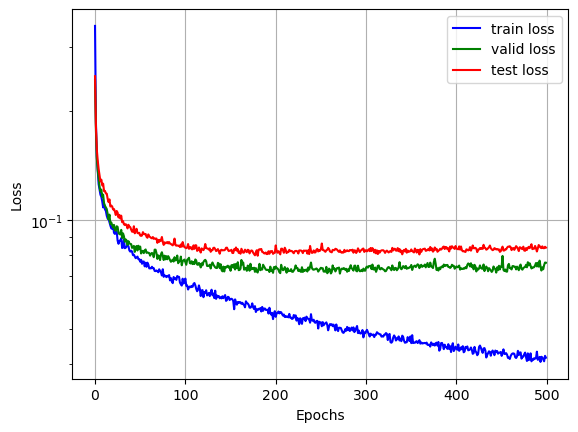

In [58]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

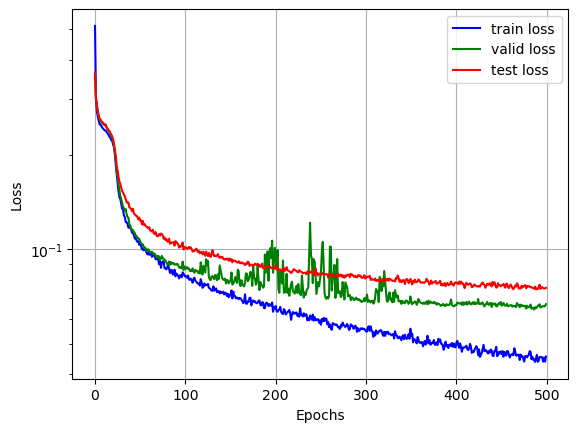

In [41]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

In [54]:
batch_size = BATCH_SIZE
n_epochs = 200

train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen

#i = 0
for i in range(20):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model =PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_unseen_01_10%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/200] train_loss: 0.38802 valid_loss: 0.26677 test_loss: 0.23387 
验证损失减少 (inf --> 0.233868). 正在保存模型...
[  2/200] train_loss: 0.20869 valid_loss: 0.18862 test_loss: 0.14938 
验证损失减少 (0.266766 --> 0.149376). 正在保存模型...
[  3/200] train_loss: 0.16021 valid_loss: 0.16388 test_loss: 0.13240 
验证损失减少 (0.188623 --> 0.132398). 正在保存模型...
[  4/200] train_loss: 0.14411 valid_loss: 0.14412 test_loss: 0.12451 
验证损失减少 (0.163882 --> 0.124511). 正在保存模型...
[  5/200] train_loss: 0.13400 valid_loss: 0.13952 test_loss: 0.12297 
验证损失减少 (0.144123 --> 0.122969). 正在保存模型...
[  6/200] train_loss: 0.12639 valid_loss: 0.13324 test_loss: 0.11513 
验证损失减少 (0.139519 --> 0.115131). 正在保存模型...
[  7/200] train_loss: 0.12574 valid_loss: 0.12512 test_loss: 0.11161 
验证损失减少 (0.133238 --> 0.111611). 正在保存模型...
[  8/200] train_loss: 0.11850 valid_loss: 0.12272 test_loss: 0.11025 
验证损失减少 (0.125123 --> 0.110247). 正在保存模型...
[  9/200] train_loss: 0.11884 valid_loss: 0.11871 test_loss: 0.10656 
验证损失减少 (0.122716 --> 0

[106/200] train_loss: 0.06388 valid_loss: 0.07875 test_loss: 0.09077 
[107/200] train_loss: 0.06559 valid_loss: 0.08090 test_loss: 0.09187 
[108/200] train_loss: 0.06639 valid_loss: 0.07751 test_loss: 0.08780 
[109/200] train_loss: 0.06506 valid_loss: 0.07881 test_loss: 0.21528 
[110/200] train_loss: 0.06605 valid_loss: 0.07851 test_loss: 0.08732 
[111/200] train_loss: 0.06489 valid_loss: 0.08017 test_loss: 0.09313 
[112/200] train_loss: 0.06364 valid_loss: 0.08110 test_loss: 0.12814 
[113/200] train_loss: 0.06386 valid_loss: 0.07826 test_loss: 0.09078 
[114/200] train_loss: 0.06350 valid_loss: 0.07782 test_loss: 0.09218 
[115/200] train_loss: 0.06239 valid_loss: 0.07785 test_loss: 0.09830 
[116/200] train_loss: 0.06474 valid_loss: 0.07849 test_loss: 0.09800 
[117/200] train_loss: 0.06343 valid_loss: 0.07817 test_loss: 0.08903 
[118/200] train_loss: 0.06626 valid_loss: 0.07750 test_loss: 0.11227 
[119/200] train_loss: 0.06263 valid_loss: 0.07897 test_loss: 0.11026 
[120/200] train_loss

[ 15/200] train_loss: 0.10872 valid_loss: 0.11263 test_loss: 0.10982 
验证损失减少 (0.115559 --> 0.109816). 正在保存模型...
[ 16/200] train_loss: 0.10427 valid_loss: 0.11260 test_loss: 0.10890 
验证损失减少 (0.112627 --> 0.108904). 正在保存模型...
[ 17/200] train_loss: 0.10380 valid_loss: 0.11683 test_loss: 0.11139 
验证损失减少 (0.112596 --> 0.111388). 正在保存模型...
[ 18/200] train_loss: 0.10182 valid_loss: 0.11024 test_loss: 0.10605 
验证损失减少 (0.116832 --> 0.106049). 正在保存模型...
[ 19/200] train_loss: 0.10139 valid_loss: 0.10594 test_loss: 0.10310 
验证损失减少 (0.110238 --> 0.103102). 正在保存模型...
[ 20/200] train_loss: 0.09985 valid_loss: 0.10582 test_loss: 0.10679 
[ 21/200] train_loss: 0.09937 valid_loss: 0.10748 test_loss: 0.10504 
验证损失减少 (0.105942 --> 0.105038). 正在保存模型...
[ 22/200] train_loss: 0.09827 valid_loss: 0.10426 test_loss: 0.10709 
验证损失减少 (0.107479 --> 0.107092). 正在保存模型...
[ 23/200] train_loss: 0.09934 valid_loss: 0.10484 test_loss: 0.13807 
[ 24/200] train_loss: 0.09788 valid_loss: 0.10386 test_loss: 0.15913 
[ 25/2

[127/200] train_loss: 0.06641 valid_loss: 0.07984 test_loss: 0.10042 
[128/200] train_loss: 0.06393 valid_loss: 0.07794 test_loss: 0.31683 
[129/200] train_loss: 0.06382 valid_loss: 0.08093 test_loss: 0.10058 
[130/200] train_loss: 0.06469 valid_loss: 0.08335 test_loss: 0.10348 
[131/200] train_loss: 0.06566 valid_loss: 0.08024 test_loss: 0.09547 
[132/200] train_loss: 0.06505 valid_loss: 0.08090 test_loss: 0.09557 
[133/200] train_loss: 0.06636 valid_loss: 0.08088 test_loss: 0.09364 
[134/200] train_loss: 0.06382 valid_loss: 0.07864 test_loss: 0.09583 
[135/200] train_loss: 0.06310 valid_loss: 0.08144 test_loss: 0.09610 
[136/200] train_loss: 0.06425 valid_loss: 0.08308 test_loss: 0.09676 
[137/200] train_loss: 0.06438 valid_loss: 0.08368 test_loss: 0.09733 
[138/200] train_loss: 0.06381 valid_loss: 0.07994 test_loss: 0.10044 
[139/200] train_loss: 0.06405 valid_loss: 0.08084 test_loss: 0.10211 
[140/200] train_loss: 0.06384 valid_loss: 0.08077 test_loss: 0.09723 
[141/200] train_loss

[ 32/200] train_loss: 0.08688 valid_loss: 0.09030 test_loss: 0.12934 
[ 33/200] train_loss: 0.08599 valid_loss: 0.09230 test_loss: 0.10672 
[ 34/200] train_loss: 0.08650 valid_loss: 0.09034 test_loss: 0.10634 
[ 35/200] train_loss: 0.08439 valid_loss: 0.09323 test_loss: 0.10694 
[ 36/200] train_loss: 0.08223 valid_loss: 0.08967 test_loss: 0.11081 
[ 37/200] train_loss: 0.08422 valid_loss: 0.08919 test_loss: 0.10310 
[ 38/200] train_loss: 0.08219 valid_loss: 0.08852 test_loss: 0.10201 
[ 39/200] train_loss: 0.08309 valid_loss: 0.08779 test_loss: 0.11586 
[ 40/200] train_loss: 0.08222 valid_loss: 0.08670 test_loss: 0.11558 
[ 41/200] train_loss: 0.07968 valid_loss: 0.08834 test_loss: 0.09330 
[ 42/200] train_loss: 0.08116 valid_loss: 0.08632 test_loss: 0.38823 
[ 43/200] train_loss: 0.08184 valid_loss: 0.08556 test_loss: 0.09317 
[ 44/200] train_loss: 0.08182 valid_loss: 0.08586 test_loss: 0.20875 
[ 45/200] train_loss: 0.08033 valid_loss: 0.08606 test_loss: 0.10887 
[ 46/200] train_loss

[149/200] train_loss: 0.06068 valid_loss: 0.07547 test_loss: 0.13416 
[150/200] train_loss: 0.05769 valid_loss: 0.07572 test_loss: 0.10930 
[151/200] train_loss: 0.06018 valid_loss: 0.07623 test_loss: 0.18003 
[152/200] train_loss: 0.05955 valid_loss: 0.07750 test_loss: 0.09277 
[153/200] train_loss: 0.05916 valid_loss: 0.07813 test_loss: 0.09323 
[154/200] train_loss: 0.05837 valid_loss: 0.08118 test_loss: 0.09208 
[155/200] train_loss: 0.05917 valid_loss: 0.08030 test_loss: 0.25319 
[156/200] train_loss: 0.05867 valid_loss: 0.07559 test_loss: 0.09200 
[157/200] train_loss: 0.05989 valid_loss: 0.07882 test_loss: 0.08833 
[158/200] train_loss: 0.05829 valid_loss: 0.07513 test_loss: 0.28588 
[159/200] train_loss: 0.05785 valid_loss: 0.07693 test_loss: 0.10127 
[160/200] train_loss: 0.05946 valid_loss: 0.07679 test_loss: 0.08853 
[161/200] train_loss: 0.05935 valid_loss: 0.07627 test_loss: 0.11449 
[162/200] train_loss: 0.05769 valid_loss: 0.08064 test_loss: 0.09227 
[163/200] train_loss

[ 54/200] train_loss: 0.07879 valid_loss: 0.08766 test_loss: 0.17525 
[ 55/200] train_loss: 0.07776 valid_loss: 0.08658 test_loss: 0.13379 
[ 56/200] train_loss: 0.07805 valid_loss: 0.08403 test_loss: 0.21735 
[ 57/200] train_loss: 0.07677 valid_loss: 0.08633 test_loss: 0.10363 
[ 58/200] train_loss: 0.07667 valid_loss: 0.08540 test_loss: 0.23581 
[ 59/200] train_loss: 0.07591 valid_loss: 0.08751 test_loss: 0.19418 
[ 60/200] train_loss: 0.07610 valid_loss: 0.08445 test_loss: 0.30742 
[ 61/200] train_loss: 0.07597 valid_loss: 0.08457 test_loss: 0.10869 
[ 62/200] train_loss: 0.07831 valid_loss: 0.08371 test_loss: 0.09267 
验证损失减少 (0.092961 --> 0.092670). 正在保存模型...
[ 63/200] train_loss: 0.07564 valid_loss: 0.08483 test_loss: 0.09257 
[ 64/200] train_loss: 0.07550 valid_loss: 0.08416 test_loss: 0.09022 
[ 65/200] train_loss: 0.07637 valid_loss: 0.08463 test_loss: 0.09008 
[ 66/200] train_loss: 0.07576 valid_loss: 0.08442 test_loss: 0.10997 
[ 67/200] train_loss: 0.07463 valid_loss: 0.0834

[171/200] train_loss: 0.05864 valid_loss: 0.07654 test_loss: 0.65782 
[172/200] train_loss: 0.05843 valid_loss: 0.07749 test_loss: 0.12812 
[173/200] train_loss: 0.05875 valid_loss: 0.07832 test_loss: 0.09085 
[174/200] train_loss: 0.05953 valid_loss: 0.07746 test_loss: 0.09365 
[175/200] train_loss: 0.05771 valid_loss: 0.07864 test_loss: 0.09762 
[176/200] train_loss: 0.05845 valid_loss: 0.07787 test_loss: 0.09001 
[177/200] train_loss: 0.05747 valid_loss: 0.07932 test_loss: 0.52696 
[178/200] train_loss: 0.05612 valid_loss: 0.07952 test_loss: 0.09317 
[179/200] train_loss: 0.05788 valid_loss: 0.07769 test_loss: 0.09500 
[180/200] train_loss: 0.05857 valid_loss: 0.07984 test_loss: 0.09533 
[181/200] train_loss: 0.05808 valid_loss: 0.07794 test_loss: 0.09726 
[182/200] train_loss: 0.05789 valid_loss: 0.07823 test_loss: 0.09327 
[183/200] train_loss: 0.05836 valid_loss: 0.07869 test_loss: 0.09114 
[184/200] train_loss: 0.05671 valid_loss: 0.07944 test_loss: 0.09131 
[185/200] train_loss

[ 75/200] train_loss: 0.07173 valid_loss: 0.08364 test_loss: 0.09541 
[ 76/200] train_loss: 0.07431 valid_loss: 0.08319 test_loss: 0.09325 
[ 77/200] train_loss: 0.07476 valid_loss: 0.08253 test_loss: 0.09230 
[ 78/200] train_loss: 0.07290 valid_loss: 0.08015 test_loss: 0.09973 
[ 79/200] train_loss: 0.07167 valid_loss: 0.08368 test_loss: 0.12292 
[ 80/200] train_loss: 0.07355 valid_loss: 0.08130 test_loss: 0.10203 
[ 81/200] train_loss: 0.07296 valid_loss: 0.08305 test_loss: 0.21157 
[ 82/200] train_loss: 0.07225 valid_loss: 0.08326 test_loss: 0.10400 
[ 83/200] train_loss: 0.07151 valid_loss: 0.07997 test_loss: 0.09189 
[ 84/200] train_loss: 0.07209 valid_loss: 0.08314 test_loss: 0.28450 
[ 85/200] train_loss: 0.07132 valid_loss: 0.08115 test_loss: 0.08985 
[ 86/200] train_loss: 0.07028 valid_loss: 0.08060 test_loss: 0.15216 
[ 87/200] train_loss: 0.07137 valid_loss: 0.08037 test_loss: 0.13794 
[ 88/200] train_loss: 0.07065 valid_loss: 0.08080 test_loss: 0.11905 
[ 89/200] train_loss

[193/200] train_loss: 0.05688 valid_loss: 0.07709 test_loss: 0.09679 
[194/200] train_loss: 0.05661 valid_loss: 0.07744 test_loss: 0.09808 
[195/200] train_loss: 0.05553 valid_loss: 0.07599 test_loss: 0.09313 
[196/200] train_loss: 0.05744 valid_loss: 0.07606 test_loss: 0.09558 
[197/200] train_loss: 0.05562 valid_loss: 0.07824 test_loss: 0.09673 
[198/200] train_loss: 0.05684 valid_loss: 0.08061 test_loss: 0.09667 
[199/200] train_loss: 0.05700 valid_loss: 0.07683 test_loss: 0.09719 
[200/200] train_loss: 0.05687 valid_loss: 0.07619 test_loss: 0.09430 
TRAINING MODEL 5
[  1/200] train_loss: 0.36712 valid_loss: 0.26435 test_loss: 0.23319 
验证损失减少 (inf --> 0.233187). 正在保存模型...
[  2/200] train_loss: 0.20855 valid_loss: 0.19354 test_loss: 0.14839 
验证损失减少 (0.264352 --> 0.148394). 正在保存模型...
[  3/200] train_loss: 0.16295 valid_loss: 0.15904 test_loss: 0.12844 
验证损失减少 (0.193537 --> 0.128441). 正在保存模型...
[  4/200] train_loss: 0.14715 valid_loss: 0.15295 test_loss: 0.12506 
验证损失减少 (0.159040 --> 0

[ 98/200] train_loss: 0.06789 valid_loss: 0.08193 test_loss: 0.11529 
[ 99/200] train_loss: 0.06813 valid_loss: 0.08220 test_loss: 0.33796 
[100/200] train_loss: 0.06730 valid_loss: 0.08033 test_loss: 0.14208 
[101/200] train_loss: 0.06649 valid_loss: 0.08124 test_loss: 0.09526 
[102/200] train_loss: 0.06770 valid_loss: 0.08057 test_loss: 0.09391 
[103/200] train_loss: 0.06859 valid_loss: 0.08459 test_loss: 0.09753 
[104/200] train_loss: 0.06762 valid_loss: 0.08043 test_loss: 0.09193 
[105/200] train_loss: 0.06611 valid_loss: 0.08447 test_loss: 0.09227 
[106/200] train_loss: 0.06447 valid_loss: 0.08225 test_loss: 0.09069 
[107/200] train_loss: 0.06632 valid_loss: 0.08331 test_loss: 0.09654 
[108/200] train_loss: 0.06630 valid_loss: 0.08123 test_loss: 0.09629 
[109/200] train_loss: 0.06651 valid_loss: 0.08049 test_loss: 0.09028 
[110/200] train_loss: 0.06643 valid_loss: 0.08190 test_loss: 0.14143 
[111/200] train_loss: 0.06613 valid_loss: 0.08421 test_loss: 0.09691 
[112/200] train_loss

[ 10/200] train_loss: 0.11383 valid_loss: 0.11767 test_loss: 0.10769 
验证损失减少 (0.120675 --> 0.107685). 正在保存模型...
[ 11/200] train_loss: 0.11296 valid_loss: 0.11563 test_loss: 0.10902 
验证损失减少 (0.117665 --> 0.109017). 正在保存模型...
[ 12/200] train_loss: 0.10977 valid_loss: 0.11951 test_loss: 0.11073 
验证损失减少 (0.115629 --> 0.110733). 正在保存模型...
[ 13/200] train_loss: 0.10640 valid_loss: 0.11149 test_loss: 0.10512 
验证损失减少 (0.119512 --> 0.105122). 正在保存模型...
[ 14/200] train_loss: 0.10450 valid_loss: 0.11237 test_loss: 0.10525 
验证损失减少 (0.111493 --> 0.105248). 正在保存模型...
[ 15/200] train_loss: 0.10360 valid_loss: 0.10682 test_loss: 0.10961 
验证损失减少 (0.112369 --> 0.109611). 正在保存模型...
[ 16/200] train_loss: 0.10286 valid_loss: 0.10313 test_loss: 0.12707 
[ 17/200] train_loss: 0.10370 valid_loss: 0.10455 test_loss: 0.10500 
验证损失减少 (0.106825 --> 0.104999). 正在保存模型...
[ 18/200] train_loss: 0.10114 valid_loss: 0.10463 test_loss: 0.12324 
[ 19/200] train_loss: 0.09941 valid_loss: 0.10469 test_loss: 0.10218 
验证损失减少

[120/200] train_loss: 0.06282 valid_loss: 0.07736 test_loss: 0.09100 
[121/200] train_loss: 0.06045 valid_loss: 0.07886 test_loss: 0.09163 
[122/200] train_loss: 0.06304 valid_loss: 0.07826 test_loss: 0.09194 
[123/200] train_loss: 0.06449 valid_loss: 0.07667 test_loss: 0.09842 
[124/200] train_loss: 0.06253 valid_loss: 0.07667 test_loss: 0.09398 
[125/200] train_loss: 0.06342 valid_loss: 0.07742 test_loss: 0.08854 
[126/200] train_loss: 0.06476 valid_loss: 0.07737 test_loss: 0.09479 
[127/200] train_loss: 0.06199 valid_loss: 0.07742 test_loss: 0.11588 
[128/200] train_loss: 0.06293 valid_loss: 0.07696 test_loss: 0.09363 
[129/200] train_loss: 0.06230 valid_loss: 0.07787 test_loss: 0.09408 
[130/200] train_loss: 0.06349 valid_loss: 0.07655 test_loss: 0.10703 
[131/200] train_loss: 0.06323 valid_loss: 0.07608 test_loss: 0.10819 
[132/200] train_loss: 0.06258 valid_loss: 0.07582 test_loss: 0.09094 
[133/200] train_loss: 0.06251 valid_loss: 0.07695 test_loss: 0.14418 
[134/200] train_loss

[ 28/200] train_loss: 0.09303 valid_loss: 0.09596 test_loss: 0.12505 
[ 29/200] train_loss: 0.09075 valid_loss: 0.09493 test_loss: 0.24764 
[ 30/200] train_loss: 0.09072 valid_loss: 0.09628 test_loss: 0.20177 
[ 31/200] train_loss: 0.09107 valid_loss: 0.09522 test_loss: 0.09825 
[ 32/200] train_loss: 0.08993 valid_loss: 0.09330 test_loss: 0.10021 
[ 33/200] train_loss: 0.08690 valid_loss: 0.09329 test_loss: 0.13684 
[ 34/200] train_loss: 0.08823 valid_loss: 0.09673 test_loss: 0.09508 
验证损失减少 (0.096935 --> 0.095079). 正在保存模型...
[ 35/200] train_loss: 0.08637 valid_loss: 0.09304 test_loss: 0.09673 
[ 36/200] train_loss: 0.08817 valid_loss: 0.09170 test_loss: 0.09619 
验证损失减少 (0.096727 --> 0.096186). 正在保存模型...
[ 37/200] train_loss: 0.08487 valid_loss: 0.09028 test_loss: 0.11018 
[ 38/200] train_loss: 0.08766 valid_loss: 0.09333 test_loss: 0.26110 
[ 39/200] train_loss: 0.08476 valid_loss: 0.09142 test_loss: 0.34748 
[ 40/200] train_loss: 0.08458 valid_loss: 0.09148 test_loss: 0.13047 
[ 41/2

[144/200] train_loss: 0.06171 valid_loss: 0.07807 test_loss: 0.09424 
[145/200] train_loss: 0.06153 valid_loss: 0.07574 test_loss: 0.11639 
[146/200] train_loss: 0.06183 valid_loss: 0.07757 test_loss: 0.09580 
[147/200] train_loss: 0.06220 valid_loss: 0.07739 test_loss: 0.09531 
[148/200] train_loss: 0.06231 valid_loss: 0.07648 test_loss: 0.09671 
[149/200] train_loss: 0.06272 valid_loss: 0.07786 test_loss: 0.09638 
[150/200] train_loss: 0.06245 valid_loss: 0.07638 test_loss: 0.09243 
[151/200] train_loss: 0.06241 valid_loss: 0.07662 test_loss: 0.09712 
[152/200] train_loss: 0.06194 valid_loss: 0.07678 test_loss: 0.10976 
[153/200] train_loss: 0.06220 valid_loss: 0.07757 test_loss: 0.09207 
[154/200] train_loss: 0.06154 valid_loss: 0.07744 test_loss: 0.09453 
[155/200] train_loss: 0.06272 valid_loss: 0.07610 test_loss: 0.09233 
[156/200] train_loss: 0.05998 valid_loss: 0.07736 test_loss: 0.09659 
[157/200] train_loss: 0.06246 valid_loss: 0.07860 test_loss: 0.10498 
[158/200] train_loss

[ 49/200] train_loss: 0.07979 valid_loss: 0.08768 test_loss: 0.11488 
[ 50/200] train_loss: 0.07949 valid_loss: 0.08601 test_loss: 0.09342 
[ 51/200] train_loss: 0.08028 valid_loss: 0.08665 test_loss: 0.09342 
[ 52/200] train_loss: 0.07790 valid_loss: 0.08504 test_loss: 0.11551 
[ 53/200] train_loss: 0.07813 valid_loss: 0.08468 test_loss: 0.14211 
[ 54/200] train_loss: 0.07792 valid_loss: 0.08447 test_loss: 0.12326 
[ 55/200] train_loss: 0.07783 valid_loss: 0.08524 test_loss: 0.09108 
验证损失减少 (0.092133 --> 0.091076). 正在保存模型...
[ 56/200] train_loss: 0.07803 valid_loss: 0.08333 test_loss: 0.14594 
[ 57/200] train_loss: 0.07696 valid_loss: 0.08364 test_loss: 0.11412 
[ 58/200] train_loss: 0.07786 valid_loss: 0.08363 test_loss: 0.09581 
[ 59/200] train_loss: 0.07578 valid_loss: 0.08317 test_loss: 0.15726 
[ 60/200] train_loss: 0.07668 valid_loss: 0.08405 test_loss: 0.09078 
[ 61/200] train_loss: 0.07434 valid_loss: 0.08394 test_loss: 0.10532 
[ 62/200] train_loss: 0.07609 valid_loss: 0.0826

[166/200] train_loss: 0.05734 valid_loss: 0.07601 test_loss: 0.09419 
[167/200] train_loss: 0.05776 valid_loss: 0.07586 test_loss: 0.09401 
[168/200] train_loss: 0.05862 valid_loss: 0.07807 test_loss: 0.09934 
[169/200] train_loss: 0.05863 valid_loss: 0.07491 test_loss: 0.09056 
[170/200] train_loss: 0.05838 valid_loss: 0.07475 test_loss: 0.09172 
[171/200] train_loss: 0.05903 valid_loss: 0.07486 test_loss: 0.10636 
[172/200] train_loss: 0.05699 valid_loss: 0.07676 test_loss: 0.09505 
[173/200] train_loss: 0.05804 valid_loss: 0.08190 test_loss: 0.10408 
[174/200] train_loss: 0.05735 valid_loss: 0.07644 test_loss: 0.09865 
[175/200] train_loss: 0.05832 valid_loss: 0.07652 test_loss: 0.09947 
[176/200] train_loss: 0.05660 valid_loss: 0.07786 test_loss: 0.13359 
[177/200] train_loss: 0.05736 valid_loss: 0.07777 test_loss: 0.09877 
[178/200] train_loss: 0.05846 valid_loss: 0.07940 test_loss: 0.10872 
[179/200] train_loss: 0.05759 valid_loss: 0.07604 test_loss: 0.10562 
[180/200] train_loss

[ 71/200] train_loss: 0.07207 valid_loss: 0.08104 test_loss: 0.10396 
[ 72/200] train_loss: 0.07175 valid_loss: 0.08099 test_loss: 0.09855 
[ 73/200] train_loss: 0.07180 valid_loss: 0.08106 test_loss: 0.09737 
[ 74/200] train_loss: 0.06960 valid_loss: 0.08007 test_loss: 0.15289 
[ 75/200] train_loss: 0.07198 valid_loss: 0.07982 test_loss: 0.20610 
[ 76/200] train_loss: 0.07097 valid_loss: 0.08324 test_loss: 0.09420 
[ 77/200] train_loss: 0.07047 valid_loss: 0.07975 test_loss: 0.34350 
[ 78/200] train_loss: 0.07236 valid_loss: 0.07953 test_loss: 0.14298 
[ 79/200] train_loss: 0.07133 valid_loss: 0.08226 test_loss: 0.09493 
[ 80/200] train_loss: 0.07056 valid_loss: 0.08144 test_loss: 0.08870 
[ 81/200] train_loss: 0.07208 valid_loss: 0.08145 test_loss: 0.24509 
[ 82/200] train_loss: 0.06950 valid_loss: 0.07880 test_loss: 0.12199 
[ 83/200] train_loss: 0.07007 valid_loss: 0.08112 test_loss: 0.09396 
[ 84/200] train_loss: 0.06911 valid_loss: 0.07883 test_loss: 0.39456 
[ 85/200] train_loss

[189/200] train_loss: 0.05370 valid_loss: 0.07538 test_loss: 0.09146 
[190/200] train_loss: 0.05421 valid_loss: 0.07525 test_loss: 0.26893 
[191/200] train_loss: 0.05426 valid_loss: 0.07482 test_loss: 0.24912 
[192/200] train_loss: 0.05490 valid_loss: 0.07491 test_loss: 0.09294 
[193/200] train_loss: 0.05521 valid_loss: 0.07980 test_loss: 0.28706 
[194/200] train_loss: 0.05615 valid_loss: 0.07473 test_loss: 0.09284 
[195/200] train_loss: 0.05508 valid_loss: 0.07582 test_loss: 0.09871 
[196/200] train_loss: 0.05686 valid_loss: 0.07531 test_loss: 0.09107 
[197/200] train_loss: 0.05597 valid_loss: 0.07662 test_loss: 0.12326 
[198/200] train_loss: 0.05566 valid_loss: 0.07666 test_loss: 0.12063 
[199/200] train_loss: 0.05516 valid_loss: 0.07607 test_loss: 0.12254 
[200/200] train_loss: 0.05511 valid_loss: 0.07511 test_loss: 0.10077 
TRAINING MODEL 10
[  1/200] train_loss: 0.35567 valid_loss: 0.27361 test_loss: 0.24952 
验证损失减少 (inf --> 0.249524). 正在保存模型...
[  2/200] train_loss: 0.20776 valid

[ 91/200] train_loss: 0.06985 valid_loss: 0.07893 test_loss: 0.11409 
[ 92/200] train_loss: 0.06800 valid_loss: 0.07835 test_loss: 0.09355 
[ 93/200] train_loss: 0.06670 valid_loss: 0.07953 test_loss: 0.08968 
[ 94/200] train_loss: 0.06792 valid_loss: 0.08130 test_loss: 0.09326 
[ 95/200] train_loss: 0.06869 valid_loss: 0.07826 test_loss: 0.10356 
[ 96/200] train_loss: 0.06735 valid_loss: 0.07933 test_loss: 0.09498 
[ 97/200] train_loss: 0.06713 valid_loss: 0.07922 test_loss: 0.08926 
[ 98/200] train_loss: 0.06607 valid_loss: 0.07952 test_loss: 0.08907 
[ 99/200] train_loss: 0.06374 valid_loss: 0.07934 test_loss: 0.08844 
[100/200] train_loss: 0.06494 valid_loss: 0.08069 test_loss: 0.08858 
[101/200] train_loss: 0.06609 valid_loss: 0.07819 test_loss: 0.09082 
[102/200] train_loss: 0.06420 valid_loss: 0.07964 test_loss: 0.09426 
[103/200] train_loss: 0.06627 valid_loss: 0.07801 test_loss: 0.08928 
[104/200] train_loss: 0.06530 valid_loss: 0.07745 test_loss: 0.09296 
[105/200] train_loss

[  6/200] train_loss: 0.13267 valid_loss: 0.13436 test_loss: 0.11698 
验证损失减少 (0.143338 --> 0.116977). 正在保存模型...
[  7/200] train_loss: 0.12388 valid_loss: 0.13084 test_loss: 0.11754 
验证损失减少 (0.134363 --> 0.117543). 正在保存模型...
[  8/200] train_loss: 0.12382 valid_loss: 0.12585 test_loss: 0.13395 
[  9/200] train_loss: 0.11728 valid_loss: 0.12486 test_loss: 0.11038 
验证损失减少 (0.130842 --> 0.110382). 正在保存模型...
[ 10/200] train_loss: 0.11803 valid_loss: 0.11953 test_loss: 0.12034 
验证损失减少 (0.124858 --> 0.120345). 正在保存模型...
[ 11/200] train_loss: 0.11363 valid_loss: 0.12014 test_loss: 0.11113 
验证损失减少 (0.119534 --> 0.111130). 正在保存模型...
[ 12/200] train_loss: 0.11268 valid_loss: 0.11867 test_loss: 0.11326 
验证损失减少 (0.120135 --> 0.113255). 正在保存模型...
[ 13/200] train_loss: 0.11068 valid_loss: 0.11747 test_loss: 0.11358 
验证损失减少 (0.118669 --> 0.113578). 正在保存模型...
[ 14/200] train_loss: 0.10688 valid_loss: 0.11364 test_loss: 0.11092 
验证损失减少 (0.117467 --> 0.110918). 正在保存模型...
[ 15/200] train_loss: 0.10608 vali

[109/200] train_loss: 0.06664 valid_loss: 0.08038 test_loss: 0.08807 
[110/200] train_loss: 0.06831 valid_loss: 0.08339 test_loss: 0.09134 
[111/200] train_loss: 0.06666 valid_loss: 0.08235 test_loss: 0.08807 
[112/200] train_loss: 0.06615 valid_loss: 0.08080 test_loss: 0.09329 
[113/200] train_loss: 0.06744 valid_loss: 0.08869 test_loss: 0.10572 
[114/200] train_loss: 0.06771 valid_loss: 0.08710 test_loss: 0.09998 
[115/200] train_loss: 0.06603 valid_loss: 0.08427 test_loss: 0.09627 
[116/200] train_loss: 0.06792 valid_loss: 0.08728 test_loss: 0.09718 
[117/200] train_loss: 0.06656 valid_loss: 0.08190 test_loss: 0.09022 
[118/200] train_loss: 0.06449 valid_loss: 0.08346 test_loss: 0.09081 
[119/200] train_loss: 0.06266 valid_loss: 0.08125 test_loss: 0.09113 
[120/200] train_loss: 0.06531 valid_loss: 0.08945 test_loss: 0.10254 
[121/200] train_loss: 0.06611 valid_loss: 0.08279 test_loss: 0.10074 
[122/200] train_loss: 0.06410 valid_loss: 0.07995 test_loss: 0.12463 
[123/200] train_loss

[ 17/200] train_loss: 0.09782 valid_loss: 0.10159 test_loss: 0.11011 
[ 18/200] train_loss: 0.09767 valid_loss: 0.10179 test_loss: 0.09889 
验证损失减少 (0.101740 --> 0.098893). 正在保存模型...
[ 19/200] train_loss: 0.09677 valid_loss: 0.10107 test_loss: 0.10368 
[ 20/200] train_loss: 0.09599 valid_loss: 0.10112 test_loss: 0.10052 
验证损失减少 (0.101787 --> 0.100516). 正在保存模型...
[ 21/200] train_loss: 0.09639 valid_loss: 0.09803 test_loss: 0.10479 
[ 22/200] train_loss: 0.09403 valid_loss: 0.09865 test_loss: 0.10358 
[ 23/200] train_loss: 0.09225 valid_loss: 0.09811 test_loss: 0.09894 
验证损失减少 (0.101123 --> 0.098945). 正在保存模型...
[ 24/200] train_loss: 0.09031 valid_loss: 0.09458 test_loss: 0.12873 
[ 25/200] train_loss: 0.09274 valid_loss: 0.09585 test_loss: 0.09915 
[ 26/200] train_loss: 0.09057 valid_loss: 0.09329 test_loss: 0.14296 
[ 27/200] train_loss: 0.09045 valid_loss: 0.09360 test_loss: 0.10642 
[ 28/200] train_loss: 0.08858 valid_loss: 0.09350 test_loss: 0.09950 
[ 29/200] train_loss: 0.08789 vali

[132/200] train_loss: 0.06164 valid_loss: 0.07939 test_loss: 0.09732 
[133/200] train_loss: 0.06273 valid_loss: 0.07765 test_loss: 0.11607 
[134/200] train_loss: 0.06087 valid_loss: 0.07790 test_loss: 0.20524 
[135/200] train_loss: 0.06075 valid_loss: 0.07864 test_loss: 0.11338 
[136/200] train_loss: 0.05971 valid_loss: 0.07885 test_loss: 0.09866 
[137/200] train_loss: 0.06103 valid_loss: 0.07685 test_loss: 0.09346 
[138/200] train_loss: 0.06036 valid_loss: 0.07770 test_loss: 0.10199 
[139/200] train_loss: 0.06117 valid_loss: 0.07804 test_loss: 0.10404 
[140/200] train_loss: 0.06174 valid_loss: 0.07693 test_loss: 0.09764 
[141/200] train_loss: 0.06046 valid_loss: 0.07973 test_loss: 0.09533 
[142/200] train_loss: 0.06166 valid_loss: 0.07905 test_loss: 0.10005 
[143/200] train_loss: 0.05958 valid_loss: 0.07972 test_loss: 0.11788 
[144/200] train_loss: 0.06006 valid_loss: 0.07545 test_loss: 0.11325 
[145/200] train_loss: 0.05885 valid_loss: 0.07904 test_loss: 0.09700 
[146/200] train_loss

[ 39/200] train_loss: 0.08413 valid_loss: 0.08940 test_loss: 0.21804 
[ 40/200] train_loss: 0.08432 valid_loss: 0.08780 test_loss: 0.11714 
[ 41/200] train_loss: 0.08496 valid_loss: 0.08722 test_loss: 0.35481 
[ 42/200] train_loss: 0.08123 valid_loss: 0.08593 test_loss: 0.25627 
[ 43/200] train_loss: 0.08213 valid_loss: 0.08569 test_loss: 0.20849 
[ 44/200] train_loss: 0.08079 valid_loss: 0.08563 test_loss: 0.09386 
[ 45/200] train_loss: 0.08081 valid_loss: 0.08505 test_loss: 0.18951 
[ 46/200] train_loss: 0.07996 valid_loss: 0.08493 test_loss: 0.11392 
[ 47/200] train_loss: 0.08011 valid_loss: 0.08438 test_loss: 0.09923 
[ 48/200] train_loss: 0.07973 valid_loss: 0.08551 test_loss: 0.22741 
[ 49/200] train_loss: 0.08023 valid_loss: 0.08536 test_loss: 0.09939 
[ 50/200] train_loss: 0.07891 valid_loss: 0.08683 test_loss: 0.12607 
[ 51/200] train_loss: 0.07848 valid_loss: 0.08341 test_loss: 0.21218 
[ 52/200] train_loss: 0.07843 valid_loss: 0.08501 test_loss: 0.39848 
[ 53/200] train_loss

[156/200] train_loss: 0.05976 valid_loss: 0.07734 test_loss: 0.09651 
[157/200] train_loss: 0.05857 valid_loss: 0.08060 test_loss: 0.09331 
[158/200] train_loss: 0.06023 valid_loss: 0.07749 test_loss: 0.09667 
[159/200] train_loss: 0.06028 valid_loss: 0.08719 test_loss: 0.11084 
[160/200] train_loss: 0.05871 valid_loss: 0.08439 test_loss: 0.09840 
[161/200] train_loss: 0.05949 valid_loss: 0.07551 test_loss: 0.09425 
[162/200] train_loss: 0.05978 valid_loss: 0.07835 test_loss: 0.09214 
[163/200] train_loss: 0.05896 valid_loss: 0.07677 test_loss: 0.09528 
[164/200] train_loss: 0.06042 valid_loss: 0.07696 test_loss: 0.09978 
[165/200] train_loss: 0.05863 valid_loss: 0.08262 test_loss: 0.09831 
[166/200] train_loss: 0.06128 valid_loss: 0.07633 test_loss: 0.09425 
[167/200] train_loss: 0.05853 valid_loss: 0.07797 test_loss: 0.09541 
[168/200] train_loss: 0.05824 valid_loss: 0.07711 test_loss: 0.10998 
[169/200] train_loss: 0.05823 valid_loss: 0.07767 test_loss: 0.09562 
[170/200] train_loss

[ 57/200] train_loss: 0.07972 valid_loss: 0.08802 test_loss: 0.09752 
[ 58/200] train_loss: 0.08008 valid_loss: 0.08812 test_loss: 0.17502 
[ 59/200] train_loss: 0.07937 valid_loss: 0.08772 test_loss: 0.11997 
[ 60/200] train_loss: 0.07606 valid_loss: 0.08718 test_loss: 0.09494 
[ 61/200] train_loss: 0.07711 valid_loss: 0.08500 test_loss: 0.10289 
[ 62/200] train_loss: 0.07663 valid_loss: 0.08629 test_loss: 0.09626 
[ 63/200] train_loss: 0.07694 valid_loss: 0.08504 test_loss: 0.09246 
验证损失减少 (0.093821 --> 0.092458). 正在保存模型...
[ 64/200] train_loss: 0.07624 valid_loss: 0.08524 test_loss: 0.09265 
[ 65/200] train_loss: 0.07771 valid_loss: 0.08450 test_loss: 0.20726 
[ 66/200] train_loss: 0.07405 valid_loss: 0.08278 test_loss: 0.13834 
[ 67/200] train_loss: 0.07535 valid_loss: 0.08703 test_loss: 0.44289 
[ 68/200] train_loss: 0.07584 valid_loss: 0.08402 test_loss: 0.20051 
[ 69/200] train_loss: 0.07456 valid_loss: 0.08513 test_loss: 0.09834 
[ 70/200] train_loss: 0.07569 valid_loss: 0.0833

[174/200] train_loss: 0.05890 valid_loss: 0.07712 test_loss: 0.24526 
[175/200] train_loss: 0.05966 valid_loss: 0.07773 test_loss: 0.10030 
[176/200] train_loss: 0.05840 valid_loss: 0.07750 test_loss: 0.09881 
[177/200] train_loss: 0.05807 valid_loss: 0.07677 test_loss: 0.09144 
[178/200] train_loss: 0.05859 valid_loss: 0.07810 test_loss: 0.09126 
[179/200] train_loss: 0.05755 valid_loss: 0.08113 test_loss: 0.09305 
[180/200] train_loss: 0.05820 valid_loss: 0.08255 test_loss: 0.09896 
[181/200] train_loss: 0.05836 valid_loss: 0.08038 test_loss: 0.09453 
[182/200] train_loss: 0.05884 valid_loss: 0.07998 test_loss: 0.09558 
[183/200] train_loss: 0.05839 valid_loss: 0.07872 test_loss: 0.09574 
[184/200] train_loss: 0.05782 valid_loss: 0.07837 test_loss: 0.09795 
[185/200] train_loss: 0.05618 valid_loss: 0.07921 test_loss: 0.09582 
[186/200] train_loss: 0.05784 valid_loss: 0.07714 test_loss: 0.09546 
[187/200] train_loss: 0.05863 valid_loss: 0.08556 test_loss: 0.10659 
[188/200] train_loss

[ 79/200] train_loss: 0.07081 valid_loss: 0.08128 test_loss: 0.09645 
[ 80/200] train_loss: 0.07200 valid_loss: 0.08292 test_loss: 0.09126 
[ 81/200] train_loss: 0.07228 valid_loss: 0.08369 test_loss: 0.17789 
[ 82/200] train_loss: 0.07232 valid_loss: 0.08172 test_loss: 0.08992 
[ 83/200] train_loss: 0.06874 valid_loss: 0.08445 test_loss: 0.09486 
[ 84/200] train_loss: 0.07181 valid_loss: 0.08191 test_loss: 0.09573 
[ 85/200] train_loss: 0.07017 valid_loss: 0.08303 test_loss: 0.09543 
[ 86/200] train_loss: 0.07163 valid_loss: 0.08099 test_loss: 0.09140 
[ 87/200] train_loss: 0.07065 valid_loss: 0.08199 test_loss: 0.09658 
[ 88/200] train_loss: 0.07158 valid_loss: 0.08147 test_loss: 0.11485 
[ 89/200] train_loss: 0.06990 valid_loss: 0.08346 test_loss: 0.09263 
[ 90/200] train_loss: 0.07063 valid_loss: 0.08317 test_loss: 0.13522 
[ 91/200] train_loss: 0.06751 valid_loss: 0.08027 test_loss: 0.09766 
[ 92/200] train_loss: 0.06846 valid_loss: 0.07977 test_loss: 0.10158 
[ 93/200] train_loss

[197/200] train_loss: 0.05687 valid_loss: 0.07605 test_loss: 0.09526 
[198/200] train_loss: 0.05672 valid_loss: 0.07838 test_loss: 0.09427 
[199/200] train_loss: 0.05747 valid_loss: 0.07816 test_loss: 0.10124 
[200/200] train_loss: 0.05413 valid_loss: 0.07769 test_loss: 0.09447 
TRAINING MODEL 16
[  1/200] train_loss: 0.35996 valid_loss: 0.26590 test_loss: 0.23438 
验证损失减少 (inf --> 0.234385). 正在保存模型...
[  2/200] train_loss: 0.20778 valid_loss: 0.19375 test_loss: 0.14923 
验证损失减少 (0.265899 --> 0.149230). 正在保存模型...
[  3/200] train_loss: 0.16513 valid_loss: 0.16677 test_loss: 0.13013 
验证损失减少 (0.193754 --> 0.130129). 正在保存模型...
[  4/200] train_loss: 0.14338 valid_loss: 0.14503 test_loss: 0.11689 
验证损失减少 (0.166767 --> 0.116893). 正在保存模型...
[  5/200] train_loss: 0.13464 valid_loss: 0.13621 test_loss: 0.11341 
验证损失减少 (0.145030 --> 0.113409). 正在保存模型...
[  6/200] train_loss: 0.13100 valid_loss: 0.13335 test_loss: 0.11475 
验证损失减少 (0.136207 --> 0.114752). 正在保存模型...
[  7/200] train_loss: 0.12390 valid

[ 98/200] train_loss: 0.06785 valid_loss: 0.07892 test_loss: 0.08699 
[ 99/200] train_loss: 0.06696 valid_loss: 0.07857 test_loss: 0.08969 
[100/200] train_loss: 0.06665 valid_loss: 0.07905 test_loss: 0.09007 
[101/200] train_loss: 0.06668 valid_loss: 0.07754 test_loss: 0.09161 
[102/200] train_loss: 0.06644 valid_loss: 0.07897 test_loss: 0.12886 
[103/200] train_loss: 0.06599 valid_loss: 0.07791 test_loss: 0.09419 
[104/200] train_loss: 0.06568 valid_loss: 0.07779 test_loss: 0.09362 
[105/200] train_loss: 0.06613 valid_loss: 0.07747 test_loss: 0.08784 
[106/200] train_loss: 0.06532 valid_loss: 0.08054 test_loss: 0.09149 
[107/200] train_loss: 0.06499 valid_loss: 0.07660 test_loss: 0.08832 
[108/200] train_loss: 0.06536 valid_loss: 0.07898 test_loss: 0.09244 
[109/200] train_loss: 0.06247 valid_loss: 0.07846 test_loss: 0.09095 
[110/200] train_loss: 0.06402 valid_loss: 0.07898 test_loss: 0.08970 
[111/200] train_loss: 0.06492 valid_loss: 0.07843 test_loss: 0.25243 
[112/200] train_loss

[ 10/200] train_loss: 0.11349 valid_loss: 0.11465 test_loss: 0.10565 
验证损失减少 (0.117200 --> 0.105653). 正在保存模型...
[ 11/200] train_loss: 0.11127 valid_loss: 0.11352 test_loss: 0.10705 
验证损失减少 (0.114645 --> 0.107052). 正在保存模型...
[ 12/200] train_loss: 0.10891 valid_loss: 0.11228 test_loss: 0.10286 
验证损失减少 (0.113518 --> 0.102863). 正在保存模型...
[ 13/200] train_loss: 0.10686 valid_loss: 0.10829 test_loss: 0.10775 
验证损失减少 (0.112278 --> 0.107755). 正在保存模型...
[ 14/200] train_loss: 0.10527 valid_loss: 0.10661 test_loss: 0.21029 
[ 15/200] train_loss: 0.10305 valid_loss: 0.10618 test_loss: 0.10614 
验证损失减少 (0.108286 --> 0.106138). 正在保存模型...
[ 16/200] train_loss: 0.10204 valid_loss: 0.10336 test_loss: 0.10019 
验证损失减少 (0.106183 --> 0.100192). 正在保存模型...
[ 17/200] train_loss: 0.10131 valid_loss: 0.10438 test_loss: 0.10469 
[ 18/200] train_loss: 0.09923 valid_loss: 0.10268 test_loss: 0.10205 
验证损失减少 (0.103363 --> 0.102048). 正在保存模型...
[ 19/200] train_loss: 0.09527 valid_loss: 0.10028 test_loss: 0.09971 
验证损失减少

[121/200] train_loss: 0.06231 valid_loss: 0.07946 test_loss: 0.09120 
[122/200] train_loss: 0.06269 valid_loss: 0.07928 test_loss: 0.09236 
[123/200] train_loss: 0.06397 valid_loss: 0.07991 test_loss: 0.27162 
[124/200] train_loss: 0.06266 valid_loss: 0.07946 test_loss: 0.15938 
[125/200] train_loss: 0.06257 valid_loss: 0.07795 test_loss: 0.09483 
[126/200] train_loss: 0.06147 valid_loss: 0.07956 test_loss: 0.09320 
[127/200] train_loss: 0.06193 valid_loss: 0.07924 test_loss: 0.21748 
[128/200] train_loss: 0.06296 valid_loss: 0.07894 test_loss: 0.08865 
[129/200] train_loss: 0.06238 valid_loss: 0.08035 test_loss: 0.09639 
[130/200] train_loss: 0.06230 valid_loss: 0.07840 test_loss: 0.09102 
[131/200] train_loss: 0.06376 valid_loss: 0.07856 test_loss: 0.09079 
[132/200] train_loss: 0.06038 valid_loss: 0.08058 test_loss: 0.09136 
[133/200] train_loss: 0.06327 valid_loss: 0.07939 test_loss: 0.09152 
[134/200] train_loss: 0.06218 valid_loss: 0.07961 test_loss: 0.08868 
[135/200] train_loss

[ 25/200] train_loss: 0.09213 valid_loss: 0.09629 test_loss: 0.09897 
[ 26/200] train_loss: 0.09307 valid_loss: 0.09614 test_loss: 0.09640 
验证损失减少 (0.097901 --> 0.096398). 正在保存模型...
[ 27/200] train_loss: 0.08909 valid_loss: 0.09555 test_loss: 0.10044 
[ 28/200] train_loss: 0.08770 valid_loss: 0.09343 test_loss: 0.16290 
[ 29/200] train_loss: 0.08729 valid_loss: 0.09306 test_loss: 0.09670 
[ 30/200] train_loss: 0.08826 valid_loss: 0.09059 test_loss: 0.09062 
验证损失减少 (0.096136 --> 0.090620). 正在保存模型...
[ 31/200] train_loss: 0.08587 valid_loss: 0.09190 test_loss: 0.09654 
[ 32/200] train_loss: 0.08668 valid_loss: 0.09309 test_loss: 0.09443 
[ 33/200] train_loss: 0.08594 valid_loss: 0.09380 test_loss: 0.09503 
[ 34/200] train_loss: 0.08715 valid_loss: 0.08940 test_loss: 0.17265 
[ 35/200] train_loss: 0.08584 valid_loss: 0.09003 test_loss: 0.10752 
[ 36/200] train_loss: 0.08505 valid_loss: 0.09170 test_loss: 0.11621 
[ 37/200] train_loss: 0.08366 valid_loss: 0.08968 test_loss: 0.09551 
[ 38/2

[140/200] train_loss: 0.06082 valid_loss: 0.07734 test_loss: 0.21101 
[141/200] train_loss: 0.06088 valid_loss: 0.07758 test_loss: 0.09183 
[142/200] train_loss: 0.06233 valid_loss: 0.07829 test_loss: 0.09120 
[143/200] train_loss: 0.06245 valid_loss: 0.07842 test_loss: 0.09353 
[144/200] train_loss: 0.06138 valid_loss: 0.07880 test_loss: 0.20201 
[145/200] train_loss: 0.06026 valid_loss: 0.07791 test_loss: 0.09395 
[146/200] train_loss: 0.06101 valid_loss: 0.07730 test_loss: 0.09189 
[147/200] train_loss: 0.06138 valid_loss: 0.07930 test_loss: 0.09441 
[148/200] train_loss: 0.06170 valid_loss: 0.07848 test_loss: 0.09065 
[149/200] train_loss: 0.05976 valid_loss: 0.08022 test_loss: 0.09357 
[150/200] train_loss: 0.06122 valid_loss: 0.07924 test_loss: 0.09290 
[151/200] train_loss: 0.06017 valid_loss: 0.07898 test_loss: 0.09497 
[152/200] train_loss: 0.05859 valid_loss: 0.07878 test_loss: 0.09460 
[153/200] train_loss: 0.05795 valid_loss: 0.07989 test_loss: 0.09256 
[154/200] train_loss

[ 42/200] train_loss: 0.08577 valid_loss: 0.09184 test_loss: 0.09894 
[ 43/200] train_loss: 0.08554 valid_loss: 0.08962 test_loss: 0.11202 
[ 44/200] train_loss: 0.08351 valid_loss: 0.09329 test_loss: 0.38401 
[ 45/200] train_loss: 0.08365 valid_loss: 0.09083 test_loss: 0.17441 
[ 46/200] train_loss: 0.08304 valid_loss: 0.09117 test_loss: 0.12248 
[ 47/200] train_loss: 0.07899 valid_loss: 0.08967 test_loss: 0.12743 
[ 48/200] train_loss: 0.08337 valid_loss: 0.08916 test_loss: 0.11242 
[ 49/200] train_loss: 0.08057 valid_loss: 0.08967 test_loss: 0.10286 
[ 50/200] train_loss: 0.08073 valid_loss: 0.08977 test_loss: 0.10312 
[ 51/200] train_loss: 0.08047 valid_loss: 0.08796 test_loss: 0.10256 
[ 52/200] train_loss: 0.07899 valid_loss: 0.08765 test_loss: 0.09895 
[ 53/200] train_loss: 0.08080 valid_loss: 0.09041 test_loss: 0.09358 
验证损失减少 (0.094635 --> 0.093581). 正在保存模型...
[ 54/200] train_loss: 0.07739 valid_loss: 0.08645 test_loss: 0.11536 
[ 55/200] train_loss: 0.07843 valid_loss: 0.0891

[158/200] train_loss: 0.05947 valid_loss: 0.07586 test_loss: 0.09022 
[159/200] train_loss: 0.06038 valid_loss: 0.07932 test_loss: 0.09264 
[160/200] train_loss: 0.05915 valid_loss: 0.07868 test_loss: 0.09139 
[161/200] train_loss: 0.06124 valid_loss: 0.07602 test_loss: 0.08998 
[162/200] train_loss: 0.05936 valid_loss: 0.07661 test_loss: 0.09194 
[163/200] train_loss: 0.05958 valid_loss: 0.07756 test_loss: 0.09264 
[164/200] train_loss: 0.06007 valid_loss: 0.07541 test_loss: 0.09185 
[165/200] train_loss: 0.06044 valid_loss: 0.07544 test_loss: 0.14273 
[166/200] train_loss: 0.05885 valid_loss: 0.07889 test_loss: 0.09226 
[167/200] train_loss: 0.05842 valid_loss: 0.07701 test_loss: 0.09141 
[168/200] train_loss: 0.05987 valid_loss: 0.07659 test_loss: 0.09215 
[169/200] train_loss: 0.05973 valid_loss: 0.07772 test_loss: 0.09280 
[170/200] train_loss: 0.06078 valid_loss: 0.07832 test_loss: 0.15935 
[171/200] train_loss: 0.05854 valid_loss: 0.08095 test_loss: 0.09279 
[172/200] train_loss

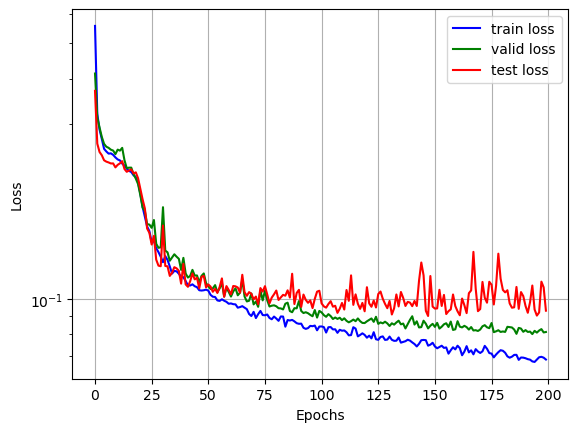

In [33]:
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(valid_loss, color='green', label='valid loss')
plt.plot(test_loss, color='red', label='test loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

In [51]:
model = PTPNet(1,3,32).cuda()
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool1_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)


这段代码定义了一个名为model的神经网络模型。该模型是一个PTPNet模型，输入维度为1，输出维度为3，隐藏层维度为32。通过调用.cuda()方法，将模型移动到GPU上进行计算。接下来，代码调用model.eval()将模型设置为评估模式，表示在进行推理时不进行梯度计算和参数更新。

总结：这段代码定义了一个PTPNet模型，并将其移动到GPU上进行评估模式的设置。

In [60]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_01_01%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[0], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[0], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[0], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[0], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[0], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[0], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[0], sorted(scores[i]['SAE'])[18]))

./UKDALE_seen_01_010.pth
./UKDALE_seen_01_011.pth
./UKDALE_seen_01_012.pth
./UKDALE_seen_01_013.pth
./UKDALE_seen_01_014.pth
./UKDALE_seen_01_015.pth
./UKDALE_seen_01_016.pth
./UKDALE_seen_01_017.pth
./UKDALE_seen_01_018.pth
./UKDALE_seen_01_019.pth
./UKDALE_seen_01_0110.pth
./UKDALE_seen_01_0111.pth
./UKDALE_seen_01_0112.pth
./UKDALE_seen_01_0113.pth
./UKDALE_seen_01_0114.pth
./UKDALE_seen_01_0115.pth
./UKDALE_seen_01_0116.pth
./UKDALE_seen_01_0117.pth
./UKDALE_seen_01_0118.pth
./UKDALE_seen_01_0119.pth

fridge
F1 score  : 0.890 (0.881, 0.896)
Precision : 0.894 (0.883, 0.898)
Recall    : 0.887 (0.870, 0.898)
Accuracy  : 0.901 (0.894, 0.905)
MCC       : 0.800 (0.785, 0.809)
MAE       : 13.44 (12.98, 13.70)
SAE       : -0.010 (-0.028, 0.005)

dish_washer
F1 score  : 0.935 (0.903, 0.958)
Precision : 0.918 (0.840, 0.952)
Recall    : 0.953 (0.924, 0.969)
Accuracy  : 0.997 (0.995, 0.998)
MCC       : 0.934 (0.903, 0.957)
MAE       : 21.00 (20.22, 21.57)
SAE       : 0.020 (-0.029, 0.059)

was

In [55]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5

for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './UKDALE_unseen_01_10%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[0], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[0], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[0], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[0], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[0], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[0], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[0], sorted(scores[i]['SAE'])[18]))

./UKDALE_unseen_01_100.pth
./UKDALE_unseen_01_101.pth
./UKDALE_unseen_01_102.pth
./UKDALE_unseen_01_103.pth
./UKDALE_unseen_01_104.pth
./UKDALE_unseen_01_105.pth
./UKDALE_unseen_01_106.pth
./UKDALE_unseen_01_107.pth
./UKDALE_unseen_01_108.pth
./UKDALE_unseen_01_109.pth
./UKDALE_unseen_01_1010.pth
./UKDALE_unseen_01_1011.pth
./UKDALE_unseen_01_1012.pth
./UKDALE_unseen_01_1013.pth
./UKDALE_unseen_01_1014.pth
./UKDALE_unseen_01_1015.pth
./UKDALE_unseen_01_1016.pth
./UKDALE_unseen_01_1017.pth
./UKDALE_unseen_01_1018.pth
./UKDALE_unseen_01_1019.pth

fridge
F1 score  : 0.865 (0.855, 0.872)
Precision : 0.879 (0.866, 0.887)
Recall    : 0.851 (0.833, 0.872)
Accuracy  : 0.899 (0.893, 0.904)
MCC       : 0.785 (0.770, 0.795)
MAE       : 17.56 (17.20, 17.83)
SAE       : -0.032 (-0.061, -0.002)

dish_washer
F1 score  : 0.784 (0.746, 0.805)
Precision : 0.747 (0.709, 0.795)
Recall    : 0.829 (0.749, 0.887)
Accuracy  : 0.987 (0.985, 0.988)
MCC       : 0.779 (0.738, 0.801)
MAE       : 35.54 (32.50, 37.5

In [33]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_11_1110%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

./UKDALE_seen_11_11100.pth
./UKDALE_seen_11_11101.pth
./UKDALE_seen_11_11102.pth
./UKDALE_seen_11_11103.pth
./UKDALE_seen_11_11104.pth
./UKDALE_seen_11_11105.pth
./UKDALE_seen_11_11106.pth
./UKDALE_seen_11_11107.pth
./UKDALE_seen_11_11108.pth
./UKDALE_seen_11_11109.pth
./UKDALE_seen_11_111010.pth
./UKDALE_seen_11_111011.pth
./UKDALE_seen_11_111012.pth
./UKDALE_seen_11_111013.pth
./UKDALE_seen_11_111014.pth
./UKDALE_seen_11_111015.pth
./UKDALE_seen_11_111016.pth
./UKDALE_seen_11_111017.pth
./UKDALE_seen_11_111018.pth
./UKDALE_seen_11_111019.pth

fridge
F1 score  : 0.899 (0.895, 0.902)
Precision : 0.902 (0.896, 0.907)
Recall    : 0.895 (0.890, 0.902)
Accuracy  : 0.908 (0.905, 0.911)
MCC       : 0.815 (0.809, 0.821)
MAE       : 12.77 (12.52, 13.03)
SAE       : -0.009 (-0.021, 0.006)

dish_washer
F1 score  : 0.943 (0.921, 0.966)
Precision : 0.938 (0.896, 0.965)
Recall    : 0.948 (0.923, 0.967)
Accuracy  : 0.997 (0.996, 0.998)
MCC       : 0.941 (0.919, 0.965)
MAE       : 20.58 (20.14, 21.33

 这段代码主要是为了评估一个模型在多个房屋的表现。首先，它创建了一个名为scores的字典，其中包含了每个房屋的评价指标，如F1得分、精度、召回率、准确率、MCC、MAE和SAE。然后，它对20个不同的模型进行了评估，每个模型分别对应一个.pth文件。对于每个模型和每个房屋，它计算了相应的预测结果，并将这些结果与真实结果进行比较，从而计算出每个房屋的评价指标。最后，它输出了每个房屋的平均评价指标，并显示了每个指标的最小值和最大值。

In [20]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []


In [21]:
mean = {}

for a in range(len(APPLIANCE)):
    data = ds_appliance[0][APPLIANCE[a]]
    non_zero_data = data[data != 0]
    mean[a] = np.mean(non_zero_data)
    print(mean[a])

88.08573913574219
654.533203125
489.18988037109375


ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

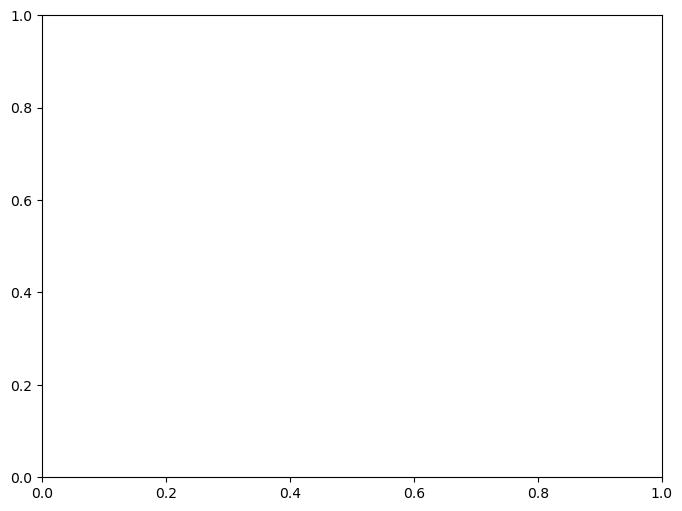

In [18]:
import matplotlib.pyplot as plt

# 初始化数据
a_values = [0, 1, 2]
f1_scores = [[] for _ in range(3)]  # 用于存储三种a值对应的F1分值

# 从scores字典中提取F1分值
for a in range(3):
    f1_scores[a] = scores[a]['F1']

# 家电设备名称
appliance_labels = ['Fridge', 'Dish Washer', 'Washing Machine']

# 绘制折线图
plt.figure(figsize=(8, 6))
for a in range(3):
    plt.plot(range(20), f1_scores[a], label=appliance_labels[a])  # 每种a值对应的F1分值折线
plt.xticks(range(0, 21, 2))  # 设置横坐标刻度为2一格
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Iteration for Different Appliances")
plt.legend()
# 设置分辨率为600ppi
dpi = 600

# 选择文件路径和文件名，保存为PNG格式
save_path = r'D:\NILM\绘图\F1折线图.png'

# 导出图片
#plt.savefig(save_path, dpi=dpi)
plt.show()


In [34]:
!pip install pillow

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)'))) - skipping


x_true: 包含了模型输入数据经过处理后的真实值。在该代码中，x_true 是一个一维数组，保存了经过处理后的输入数据 x 的值。

p_true: 包含了模型在数据加载器上对应位置的真实标签。在该代码中，p_true 是一个一维数组，保存了真实的标签值 p。

s_true: 包含了模型在数据加载器上对应位置的真实输出值。在该代码中，s_true 是一个一维数组，保存了真实的输出值 s。

s_hat: 包含了模型在数据加载器上对应位置的预测输出值。在该代码中，s_hat 是一个一维数组，保存了模型对应位置的预测输出值。

UKDALE_seen_01_0116.pth


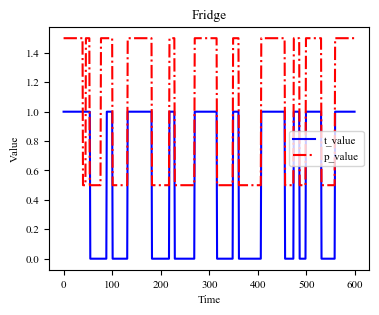

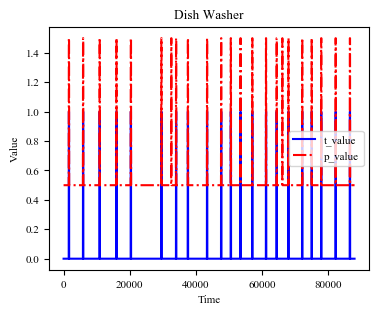

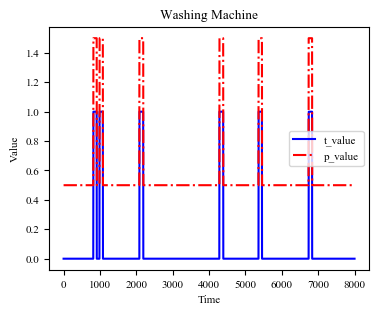

In [20]:
from PIL import Image
thr = 0.5
for i in range(1):
    filename = 'UKDALE_seen_01_01%d.pth' %(i+16)
    #filename =r'E:\jupyter\TPNILM-master\TPNILM-1108\UKDALE_seen_11_1110%d.pth' %(i+9)
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):#1为fridge，2为dish_washer，3为washing_machine
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = s_hat+0.5
        #scores[a]['F1'].append(f1_score(s_true, s_hat))
        #scores[a]['Precision'].append(precision_score(s_true, s_hat))
        #scores[a]['Recall'].append(recall_score(s_true, s_hat))
        #scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        #scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        #scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        #scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        # 绘制折线图
        #plt.plot(s_true[:1000], label='s_true')
        #plt.plot(p_true[:5000], label='p_true')
        #plt.plot(p_hat[:1000], label='p_hat')

        import matplotlib.pyplot as plt
        import matplotlib

        # 设置字体和大小
        matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 中文标签
        matplotlib.rcParams['font.size'] = 8
        matplotlib.rcParams['font.family'] = 'Times New Roman'
        matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

        # 假设 s_true 和 p_hat 是您的数据
        # 假设 mean 是您使用的平均值数组

        # 设置图表尺寸
        plt.figure(figsize=(4.13, 3.15))  # 半栏A4宽度约4.13英寸

        # 根据 a 的值绘制不同的设备
        if a == 0:
            device_name = "Fridge"
            plt.plot(s_true[:600], label='t_value', linestyle='-', color='blue')  # 使用实线和正方形标记，并指定颜色为蓝色
            plt.plot(p_hat[:600], label='p_value', linestyle='-.', color='red')  # 使用点划线和星形标记，并指定颜色为红色
        elif a == 1:
            device_name = "Dish Washer"
            plt.plot(s_true[:], label='t_value', linestyle='-', color='blue')
            plt.plot(p_hat[:], label='p_value', linestyle='-.',color='red')
        elif a == 2:
            device_name = "Washing Machine"
            s_true[0:100] = 0
            plt.plot(s_true[:8000], label='t_value', linestyle='-', color='blue')  # 使用实线和正方形标记，并指定颜色为蓝色
            plt.plot(p_hat[:8000], label='p_value', linestyle='-.', color='red')  # 使用点划线和星形标记，并指定颜色为红色
        else:
            device_name = "Appliance " + str(a)

        # 添加标题、x轴标签和y轴标签
        plt.title(device_name)
        plt.xlabel("Time")
        plt.ylabel("Value")

        # 添加图例
        plt.legend()

        # 设置分辨率为600ppi
        dpi = 600

        # 选择文件路径和文件名，保存为PNG格式
        temp_save_path = fr'D:\NILM\小论文\SKNILM\绘图\{device_name}图(3).png'
        final_save_path = fr'D:\NILM\小论文\SKNILM\绘图\{device_name}图(2000).png'

        # 导出图片
        plt.savefig(temp_save_path, dpi=dpi, format='png')

        # 使用Pillow转换为灰度图
        #img = Image.open(temp_save_path)
        #gray_img = img.convert('L')
        #gray_img.save(final_save_path)
        # 显示图形
        plt.show()


UKDALE_unseen_01_1016.pth


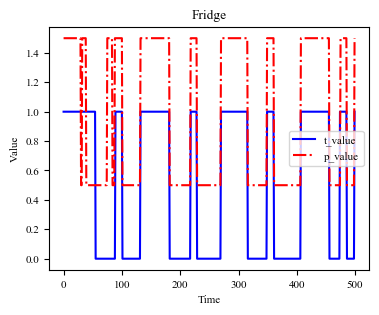

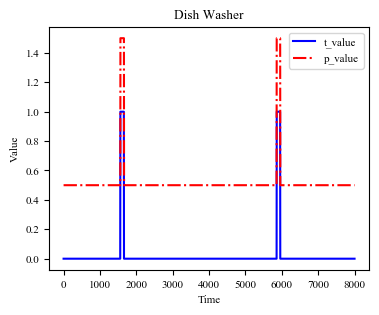

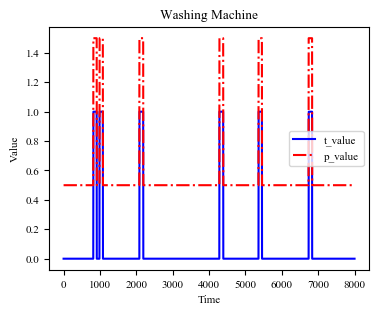

In [21]:
from PIL import Image
thr = 0.5
for i in range(1):
    filename = 'UKDALE_unseen_01_10%d.pth' %(i+16)
    #filename =r'E:\jupyter\TPNILM-master\TPNILM-1108\UKDALE_seen_11_1110%d.pth' %(i+9)
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):#1为fridge，2为dish_washer，3为washing_machine
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        #计算了一个家电设备的平均功率（pm），并将其除以最大功率（MAX_POWER）进行归一化处理。
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = s_hat+0.5
        #scores[a]['F1'].append(f1_score(s_true, s_hat))
        #scores[a]['Precision'].append(precision_score(s_true, s_hat))
        #scores[a]['Recall'].append(recall_score(s_true, s_hat))
        #scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        #scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        #scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        #scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        # 绘制折线图
        #plt.plot(s_true[:1000], label='s_true')
        #plt.plot(p_true[:5000], label='p_true')
        #plt.plot(p_hat[:1000], label='p_hat')

        import matplotlib.pyplot as plt
        import matplotlib

        # 设置字体和大小
        matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 中文标签
        matplotlib.rcParams['font.size'] = 8
        matplotlib.rcParams['font.family'] = 'Times New Roman'
        matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

        # 假设 s_true 和 p_hat 是您的数据
        # 假设 mean 是您使用的平均值数组

        # 设置图表尺寸
        plt.figure(figsize=(4.13, 3.15))  # 半栏A4宽度约4.13英寸

        # 根据 a 的值绘制不同的设备
        if a == 0:
            device_name = "Fridge"
            plt.plot(s_true[:500], label='t_value', linestyle='-', color='blue')  # 使用实线和正方形标记，并指定颜色为蓝色
            plt.plot(p_hat[:500], label='p_value', linestyle='-.', color='red')  # 使用点划线和星形标记，并指定颜色为红色
        elif a == 1:
            device_name = "Dish Washer"
            plt.plot(s_true[:8000], label='t_value', linestyle='-', color='blue')
            plt.plot(p_hat[:8000], label='p_value', linestyle='-.',color='red')
        elif a == 2:
            device_name = "Washing Machine"
            s_true[0:100] = 0
            plt.plot(s_true[:8000], label='t_value', linestyle='-', color='blue')  # 使用实线和正方形标记，并指定颜色为蓝色
            plt.plot(p_hat[:8000], label='p_value', linestyle='-.', color='red')  # 使用点划线和星形标记，并指定颜色为红色
        else:
            device_name = "Appliance " + str(a)

        # 添加标题、x轴标签和y轴标签
        plt.title(device_name)
        plt.xlabel("Time")
        plt.ylabel("Value")

        # 添加图例
        plt.legend()

        # 设置分辨率为600ppi
        dpi = 600

        # 选择文件路径和文件名，保存为PNG格式
        temp_save_path = fr'D:\NILM\小论文\SKNILM\绘图\{device_name}图(unseen).png'
        final_save_path = fr'D:\NILM\小论文\SKNILM\绘图\{device_name}图(2000).png'

        # 导出图片
        plt.savefig(temp_save_path, dpi=dpi, format='png')

        # 使用Pillow转换为灰度图
        #img = Image.open(temp_save_path)
        #gray_img = img.convert('L')
        #gray_img.save(final_save_path)
        # 显示图形
        plt.show()


In [36]:
scores = {}

for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []
    scores[a]['s_true'] = []
    scores[a]['s_hat'] = []

thr = 0.5

for i in range(1):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './UKDALE_unseen_8_1110%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['s_true'].append(s_true)
        scores[a]['s_hat'].append(s_hat)
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[0], sorted(scores[i]['F1'])[0]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[0], sorted(scores[i]['Precision'])[0]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[0], sorted(scores[i]['Recall'])[0]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[0], sorted(scores[i]['Accuracy'])[0]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[0], sorted(scores[i]['MCC'])[0]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[0], sorted(scores[i]['MAE'])[0]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[0], sorted(scores[i]['SAE'])[0]))

./UKDALE_unseen_8_11100.pth

fridge
F1 score  : 0.847 (0.847, 0.847)
Precision : 0.818 (0.818, 0.818)
Recall    : 0.877 (0.877, 0.877)
Accuracy  : 0.880 (0.880, 0.880)
MCC       : 0.750 (0.750, 0.750)
MAE       : 19.90 (19.90, 19.90)
SAE       : 0.072 (0.072, 0.072)

dish_washer
F1 score  : 0.776 (0.776, 0.776)
Precision : 0.704 (0.704, 0.704)
Recall    : 0.864 (0.864, 0.864)
Accuracy  : 0.986 (0.986, 0.986)
MCC       : 0.773 (0.773, 0.773)
MAE       : 38.38 (38.38, 38.38)
SAE       : 0.226 (0.226, 0.226)

washing_machine
F1 score  : 0.838 (0.838, 0.838)
Precision : 0.846 (0.846, 0.846)
Recall    : 0.830 (0.830, 0.830)
Accuracy  : 0.996 (0.996, 0.996)
MCC       : 0.836 (0.836, 0.836)
MAE       : 8.33 (8.33, 8.33)
SAE       : -0.020 (-0.020, -0.020)
